# Colima Seperate GS Inversion

In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from scipy.stats import beta, expon, truncnorm, norm, uniform
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re
pd.options.display.float_format = '{:,g}'.format
plt.style.use(['ggplot'])

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df, grid = io.import_colima(filename)

grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

display(raw_df.head())

Sample no.  Easting  Northing  MassArea  Thickness  [-5,-4)  [-4,-3)  \
16      VF00-04a     1499      1506     625.8         60       19       31   
18     VF00-06a3     1957      1997     417.2         40        7       30   
17     VF00-05a3     1787      2173    500.64         48       10       30   
37  VF06-03/5-09     -770      3082    594.51         57       11       25   
31     VF05-08a3    -1673      3152    125.16         12       10       22   

    [-3,-2)  [-2,-1)  [-1,0)  [0,1)  [1,2)  [2,3)  [3,4)   radius  
16       18       11       6      2      1      1      1 2,124.86  
18       25       17      11      5      1      1      1 2,796.04  
17       24       16       9      3      1      1      1 2,813.41  
37       25       19      11      4      1      1      1 3,176.73  
31       24       16      10      4      2      1      1 3,568.48

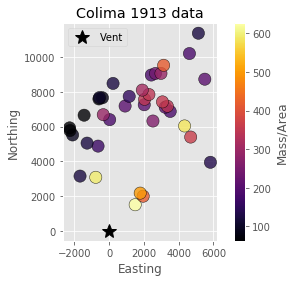

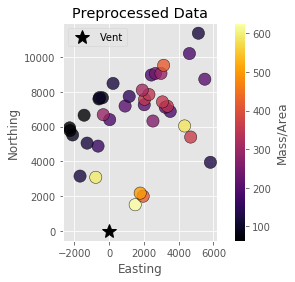

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
obs_df = obs_df.sort_values(by=['radius'])
plt.show()

In [4]:
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100
t2_df = t2_df.sort_values(by=['radius'])
display(t2_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506          0    732.73  23.1529  25.4668  22.2407   
18     1957      1997          0   691.154  21.3541  24.7682  22.4602   
17     1787      2173          0   709.841  21.2137    24.71  22.4801   
37     -770      3082          0   301.066  13.8022  19.2173  22.1297   
31    -1673      3152          0    149.68  9.51561  14.8613  20.3208   

    [-2,-1)  [-1,0)   [0,1)    [1,2)    [2,3)     [3,4)   radius  Residual  
16  15.7304 8.99492 3.44384 0.823464 0.136596 0.0103587 2,124.86   117.087  
18  16.5434 9.82586 3.90198 0.968656 0.164832 0.0128943 2,796.04   165.665  
17  16.6062 9.88889 3.93999 0.980849  0.16722  0.013114 2,813.41   141.787  
37  20.4626 14.7247 7.12663  2.10569 0.398324 0.0329064 3,176.73    50.641  
31  22.2637 18.4942 10.3172  3.45994 0.706562 0.0606982 3,568.48   119.591

In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100
t2_const_df = t2_const_df.sort_values(by=['radius'])
display(t2_const_df.head())

Easting  Northing  Elevation  MassArea  [-5,-4)  [-4,-3)  [-3,-2)  \
16     1499      1506       2500  1,394.46  17.2005  24.2121  24.7779   
18     1957      1997       2500  1,216.15   14.016  22.3619   24.864   
17     1787      2173       2500     1,251   13.877  22.2837  24.8861   
37     -770      3082       2500   359.399  14.8025  22.8299  24.5313   
31    -1673      3152       2500   134.301  15.3664  23.3283  24.4813   

    [-2,-1)  [-1,0)   [0,1)    [1,2)     [2,3)       [3,4)   radius  Residual  
16  18.9162 10.8457 3.58293 0.449327  0.015328 2.84769e-05 2,124.86   222.828  
18  20.2838 12.7356 4.93885  0.76913 0.0307052 6.30498e-05 2,796.04   291.503  
17  20.3522 12.8046 4.98427 0.780754 0.0313104 6.44789e-05 2,813.41    249.88  
37  19.4545 12.2828 5.13528 0.922533 0.0410962 9.09858e-05 3,176.73    60.453  
31  18.8191 11.7036 5.16746  1.07907  0.054478 0.000131905 3,568.48   107.303

In [6]:
config = io.read_tephra2_config("data/colima/colima_config.txt")

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

centroid  density interval  lower  probability  upper
0      -4.5    1,024  [-5,-4)     -5    0.0683375     -4
1      -3.5    1,024  [-4,-3)     -4     0.109203     -3
2      -2.5    1,024  [-3,-2)     -3     0.146694     -2
3      -1.5    1,024  [-2,-1)     -2      0.16565     -1
4      -0.5    1,024   [-1,0)     -1     0.157243      0
5       0.5  1,233.5    [0,1)      0     0.125474      1
6       1.5    1,443    [1,2)      1    0.0841661      2
7       2.5  1,652.5    [2,3)      2    0.0474595      3
8       3.5    1,862    [3,4)      3    0.0224962      4

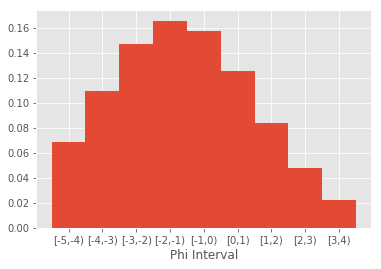

0.9267231127052998


In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

print(sum(probs))

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.00000 seconds
Total time: 0.04688 seconds


Northing  Easting  [-5,-4)  [-4,-3)  [-3,-2)  [-2,-1)  [-1,0)   [0,1)  \
0      1506     1499  17.0237  24.0587  24.7461  19.0106 10.9865 3.68062   
1      1997     1957   13.849  22.1879   24.803  20.3647 12.8847 5.06294   
2      2173     1787  13.8004  22.2099   24.865    20.38 12.8556 5.04311   
3      3082     -770  15.5611  23.6747  24.9019  19.0596 11.4484 4.52251   
4      3152    -1673  16.2556  24.3211  24.9428  18.4296 10.7682 4.36764   

     [1,2)     [2,3)       [3,4)  MassArea   radius  Residual  
0 0.476505 0.0172657 3.63504e-05   1,316.8 2,124.86   210.419  
1 0.813217 0.0344694  8.0275e-05  1,148.99 2,796.04   275.405  
2 0.811521 0.0345019 8.06424e-05  1,166.99 2,813.41   233.099  
3 0.794749 0.0368917 9.33995e-05   300.905 3,176.73   50.6139  
4 0.869463 0.0453801 0.000126158   111.015 3,568.48   88.6983

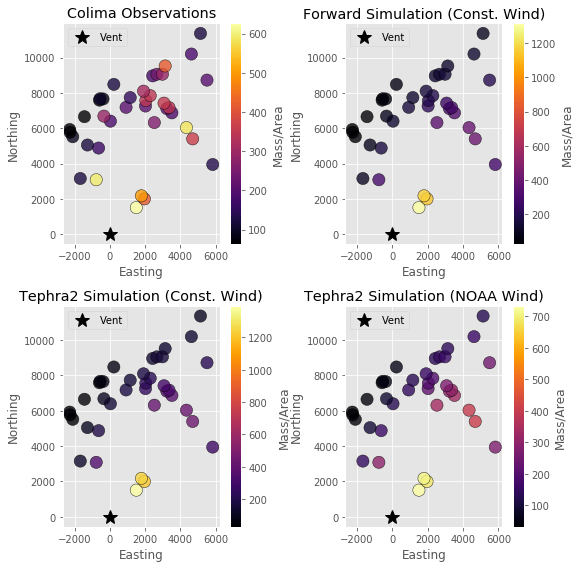

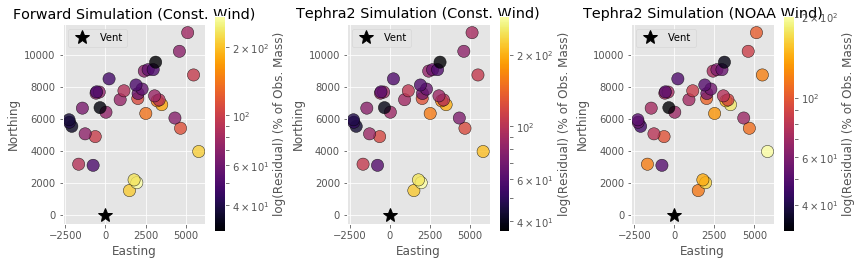

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

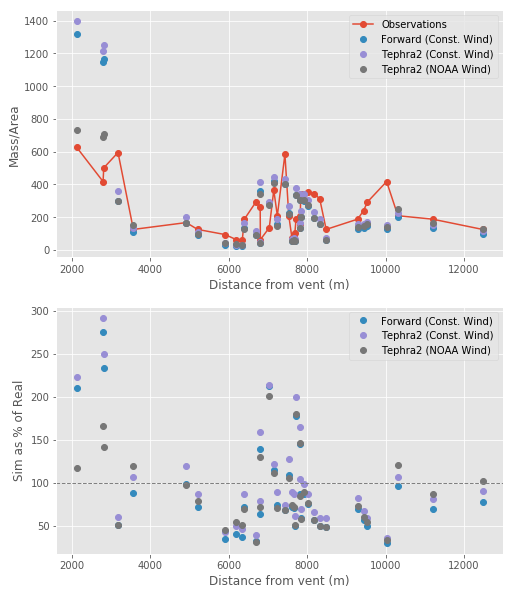

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

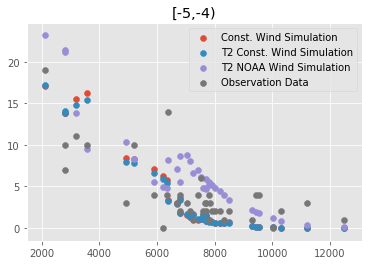

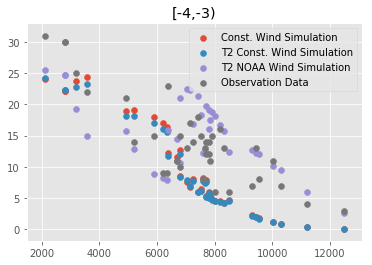

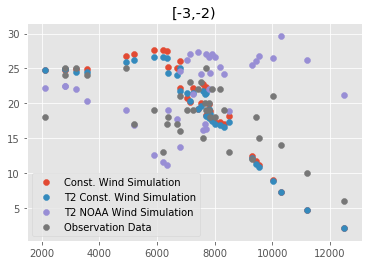

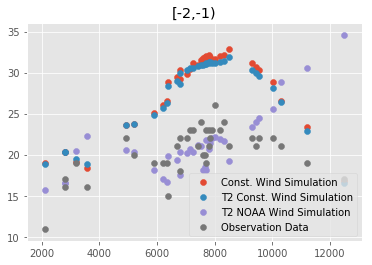

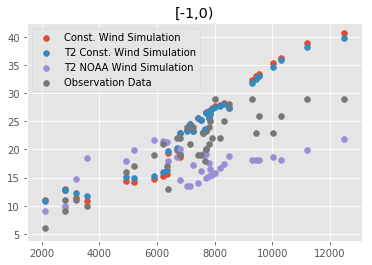

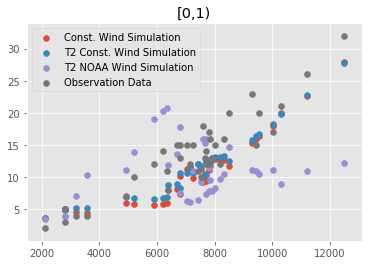

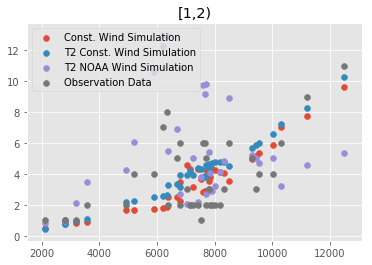

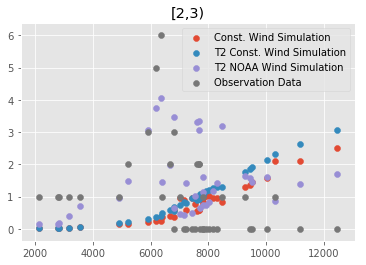

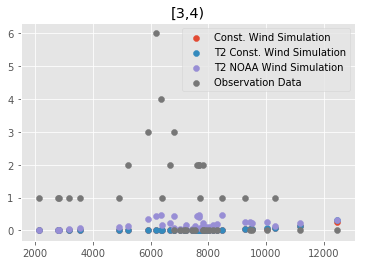

In [11]:
#TGSD calculation?
forward_tgsd = []
t2_const_tgsd = []
t2_tgsd = []
obs_tgsd = []
for phi_step in phi_steps:
    plt.scatter(forward_df["radius"], forward_df[phi_step["interval"]], label="Const. Wind Simulation")
    plt.scatter(t2_const_df["radius"], t2_const_df[phi_step["interval"]], label="T2 Const. Wind Simulation")
    plt.scatter(t2_df["radius"], t2_df[phi_step["interval"]], label="T2 NOAA Wind Simulation")
    plt.scatter(obs_df["radius"], obs_df[phi_step["interval"]], label="Observation Data")
    plt.legend()
    plt.title(phi_step["interval"])
    plt.show()
    
    forward_tgsd += [forward_df[phi_step["interval"]].sum()/len(forward_df)]
    t2_const_tgsd += [t2_const_df[phi_step["interval"]].sum()/len(t2_const_df)]
    t2_tgsd += [t2_df[phi_step["interval"]].sum()/len(t2_df)]
    obs_tgsd += [obs_df[phi_step["interval"]].sum()/len(obs_df)]




[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5]


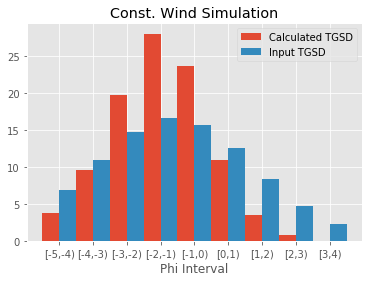

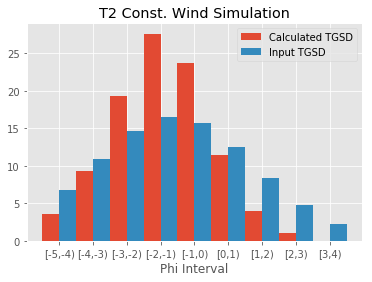

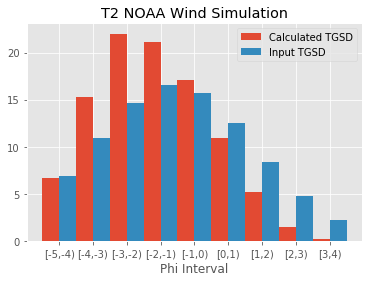

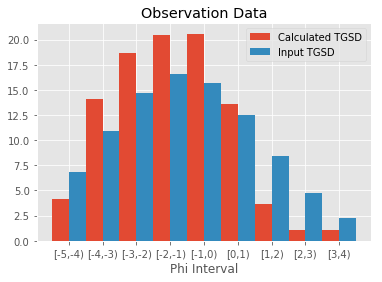

In [12]:
probs = np.array([phi["probability"] for phi in phi_steps])
x = np.array([phi["centroid"] for phi in phi_steps])
labels = [phi["interval"] for phi in phi_steps]

print(x)
fig, ax = plt.subplots()
ax.bar(x-0.25, forward_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("Const. Wind Simulation")
plt.show()

fig, ax = plt.subplots()
ax.bar(x-0.25, t2_const_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("T2 Const. Wind Simulation")
plt.show()

fig, ax = plt.subplots()
ax.bar(x-0.25, t2_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("T2 NOAA Wind Simulation")
plt.show()

fig, ax = plt.subplots()
ax.bar(x-0.25, obs_tgsd, width=0.5, align="center", label="Calculated TGSD")
ax.bar(x+0.25, np.array(probs)*100, width=0.5, align="center", label="Input TGSD")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.legend()
plt.title("Observation Data")
plt.show()

    

In [15]:
H = 30000

def col_truncnorm(mean, top=45000):
    bottom = 5000
    std = (top - bottom)/4
    standard_a, standard_b = (bottom - mean) / std, (top - mean) / std
    return truncnorm.rvs(standard_a, standard_b, loc=mean, scale=std)

def lognorm(prior, bottom=0):
    std_norm = norm.rvs()
    std_lognorm = np.exp(std_norm)
    lognorm = bottom + (prior-bottom)*std_lognorm
    return lognorm

def normal(prior):
    std_norm = norm.rvs()
    normal = prior*std_norm
    return normal

def uninformed(bottom, top):
    unif = uniform.rvs(loc = bottom, scale = (top-bottom))
    return unif


invert                                 sample_function            value
a     True        <function lognorm at 0x0000013B30BFDB70>           [2, 1]
b     True        <function lognorm at 0x0000013B30BFDB70>           [2, 1]
h1    True  <function col_truncnorm at 0x0000013B30BFD510>   [20000, 30000]
u    False         <function normal at 0x0000013B30BFDBF8>            [5.6]
v    False         <function normal at 0x0000013B30BFDBF8>            [8.2]
D    False        <function lognorm at 0x0000013B30BFDB70>           [4000]
ftt  False        <function lognorm at 0x0000013B30BFDB70>           [6000]
M    False        <function lognorm at 0x0000013B30BFDB70>  [55000000000.0]

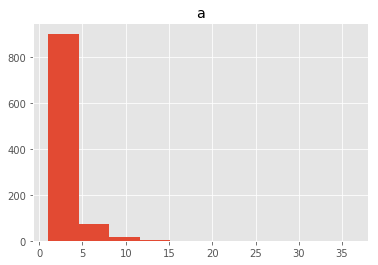

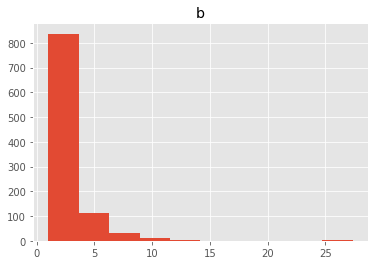

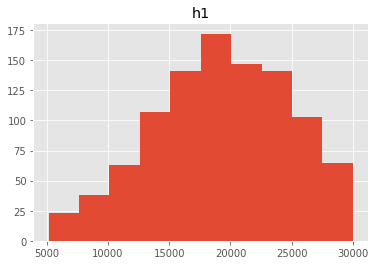

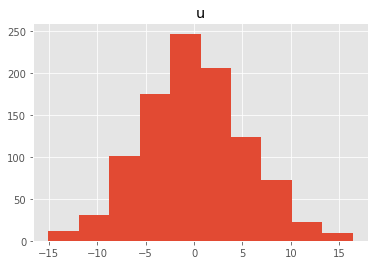

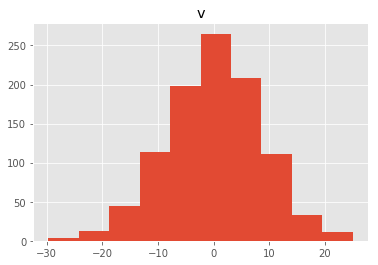

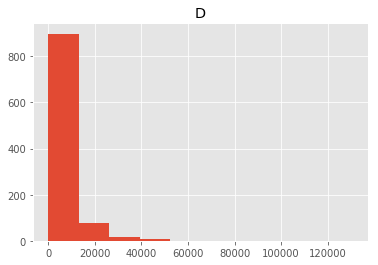

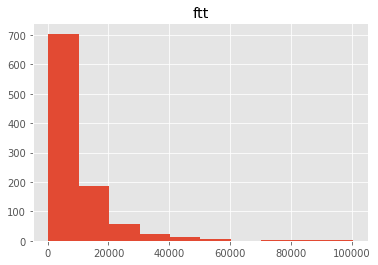

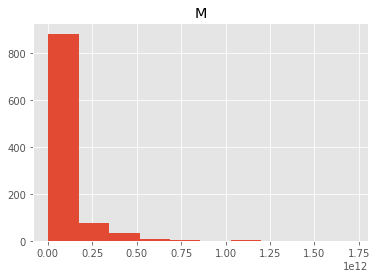

In [16]:
param_config = {
    "a": {
        "value":[2, 1],
        "invert":True,
        "sample_function": lognorm
    },
    "b": {
        "value":[2, 1],
        "invert":True,
        "sample_function": lognorm
    },
    "h1": {
        "value":[20000, H],
        "invert":True,
        "sample_function": col_truncnorm
    },
    "u": {
        "value":[5.6],
        "invert":False,
        "sample_function": normal
    },
    "v": {
        "value":[8.2],
        "invert":False,
        "sample_function": normal
    },
    "D": {
        "value":[4000],
        "invert":False,
        "sample_function": lognorm
    },
    "ftt": {
        "value":[6000],
        "invert":False,
        "sample_function": lognorm
    },
    "M": {
        "value":[config["ERUPTION_MASS"]],
        "invert":False,
        "sample_function": lognorm
    }
}
param_config_df = pd.DataFrame(param_config)
display(param_config_df.T)

for key, val in param_config.items():
    x = [val["sample_function"](*val["value"]) for i in range(1000)]
    plt.hist(x)
    plt.title(key)
    plt.show()



3758564623.1204
========[-5,-4)========
Run 0===========================================================================
5.283414989411762
a* = 0.89220	b* = -2.30059	            h1* = 3.28176	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44049	b = 1.10020	            h1 = 28894.04364	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 180
SSE: 0.3145339435169501


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    5.28341     3.44049
b    4.79202      1.1002
ftt    6,000       6,000
h1  18,660.6      28,894
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.060 minutes


Estimated remaining run time: 1.143 minutes


Run 1===========================================================================
2.4249244749162124
a* = 1.12822	b* = -2.40546	            h1* = 2.68023	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 4.09015	b = 1.09022	            h1 = 28012.46880	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 149
SSE: 0.3168826751790862


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.42492     4.09015
b    1.61725     1.09022
ftt    6,000       6,000
h1  15,719.9    28,012.5
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.052 minutes


Estimated remaining run time: 0.933 minutes


Run 2===========================================================================
3.438553725246057
a* = -3.29945	b* = 2.55247	            h1* = 2.62516	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83880	            h1 = 27903.97972	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 153
SSE: 0.26429255385965567


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.43855      1.0369
b     4.7349     13.8388
ftt    6,000       6,000
h1  16,052.7      27,904
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.051 minutes


Estimated remaining run time: 0.872 minutes


Run 3===========================================================================
1.6566508530847979
a* = 0.89221	b* = -2.30060	            h1* = 3.28174	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44053	b = 1.10020	            h1 = 28894.01212	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 139
SSE: 0.3145339435228649


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.65665     3.44053
b    2.31219      1.1002
ftt    6,000       6,000
h1  28,215.7      28,894
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.046 minutes


Estimated remaining run time: 0.738 minutes


Run 4===========================================================================
2.033262847731309
a* = 0.89219	b* = -2.30055	            h1* = 3.28174	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44048	b = 1.10020	            h1 = 28894.01800	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 139
SSE: 0.3145339435213597


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   2.03326     3.44048
b    2.2229      1.1002
ftt   6,000       6,000
h1   18,156      28,894
u       5.6         5.6
v       8.2         8.2

Run 4 Time: 0.047 minutes


Estimated remaining run time: 0.707 minutes


Run 5===========================================================================
1.0951219081763508
a* = -3.29945	b* = 2.55248	            h1* = 2.62519	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83885	            h1 = 27904.04207	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 172
SSE: 0.2642925538599066


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.09512      1.0369
b    3.92559     13.8388
ftt    6,000       6,000
h1  19,992.6      27,904
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.058 minutes


Estimated remaining run time: 0.817 minutes


Run 6===========================================================================
2.950042858723232
a* = 0.89220	b* = -2.30057	            h1* = 3.28174	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44049	b = 1.10020	            h1 = 28894.01458	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 250
SSE: 0.31453394351627245


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.95004     3.44049
b    1.22458      1.1002
ftt    6,000       6,000
h1  14,651.1      28,894
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.084 minutes


Estimated remaining run time: 1.097 minutes


Run 7===========================================================================
5.211106777479226
a* = -3.29953	b* = 2.55247	            h1* = 2.62513	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83874	            h1 = 27903.92319	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 162
SSE: 0.2642925538601767


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    5.21111      1.0369
b    4.51023     13.8387
ftt    6,000       6,000
h1  8,298.22    27,903.9
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.055 minutes


Estimated remaining run time: 0.656 minutes


Run 8===========================================================================
1.196721401924954
a* = -3.29946	b* = 2.55247	            h1* = 2.62514	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83876	            h1 = 27903.94240	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 163
SSE: 0.26429255386003686


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.19672      1.0369
b    2.91662     13.8388
ftt    6,000       6,000
h1  20,209.1    27,903.9
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.057 minutes


Estimated remaining run time: 0.630 minutes


Run 9===========================================================================
1.6427623308887878
a* = -3.29950	b* = 2.55247	            h1* = 2.62517	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83879	            h1 = 27903.99147	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 265
SSE: 0.2642925538597404


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.64276      1.0369
b    1.49054     13.8388
ftt    6,000       6,000
h1  11,484.6      27,904
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.090 minutes


Estimated remaining run time: 0.904 minutes


Run 10===========================================================================
1.6128729940191624
a* = -3.29949	b* = 2.55247	            h1* = 2.62514	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83876	            h1 = 27903.92927	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 228
SSE: 0.26429255385967276


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.61287      1.0369
b    1.32174     13.8388
ftt    6,000       6,000
h1  12,087.2    27,903.9
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.078 minutes


Estimated remaining run time: 0.705 minutes


Run 11===========================================================================
4.821053141123819
a* = 0.89220	b* = -2.30056	            h1* = 3.28173	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44048	b = 1.10020	            h1 = 28894.00960	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 212
SSE: 0.31453394351942926


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   4.82105     3.44048
b   3.84181      1.1002
ftt   6,000       6,000
h1   19,239      28,894
u       5.6         5.6
v       8.2         8.2

Run 11 Time: 0.071 minutes


Estimated remaining run time: 0.571 minutes


Run 12===========================================================================
1.1864475836699495
a* = -3.29940	b* = 2.55248	            h1* = 2.62519	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03691	b = 13.83886	            h1 = 27904.03991	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 198
SSE: 0.2642925538607783


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.18645     1.03691
b    2.51008     13.8389
ftt    6,000       6,000
h1  18,453.9      27,904
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.067 minutes


Estimated remaining run time: 0.467 minutes


Run 13===========================================================================
2.9803814799004584
a* = -3.29946	b* = 2.55247	            h1* = 2.62514	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83876	            h1 = 27903.92953	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 219
SSE: 0.26429255385988637


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   2.98038      1.0369
b   2.60165     13.8388
ftt   6,000       6,000
h1  9,278.5    27,903.9
u       5.6         5.6
v       8.2         8.2

Run 13 Time: 0.075 minutes


Estimated remaining run time: 0.450 minutes


Run 14===========================================================================
2.5700485522676946
a* = 0.89221	b* = -2.30055	            h1* = 3.28175	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44051	b = 1.10020	            h1 = 28894.02615	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 117
SSE: 0.314533943515897


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   2.57005     3.44051
b   1.33061      1.1002
ftt   6,000       6,000
h1   17,601      28,894
u       5.6         5.6
v       8.2         8.2

Run 14 Time: 0.040 minutes


Estimated remaining run time: 0.202 minutes


Run 15===========================================================================
1.1937624848566863
a* = -3.29945	b* = 2.55247	            h1* = 2.62518	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83881	            h1 = 27904.01972	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 200
SSE: 0.2642925538598016


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.19376      1.0369
b    3.41284     13.8388
ftt    6,000       6,000
h1  22,960.7      27,904
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.069 minutes


Estimated remaining run time: 0.276 minutes


Run 16===========================================================================
1.662977624152484
a* = -3.29948	b* = 2.55247	            h1* = 2.62511	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83871	            h1 = 27903.87471	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 166
SSE: 0.2642925538605086


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.66298      1.0369
b    13.6669     13.8387
ftt    6,000       6,000
h1  20,472.6    27,903.9
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.056 minutes


Estimated remaining run time: 0.169 minutes


Run 17===========================================================================
1.8093615525981446
a* = -3.29952	b* = 2.55247	            h1* = 2.62515	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83876	            h1 = 27903.94748	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 218
SSE: 0.2642925538599576


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.80936      1.0369
b     1.6213     13.8388
ftt    6,000       6,000
h1  17,593.9    27,903.9
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.074 minutes


Estimated remaining run time: 0.148 minutes


Run 18===========================================================================
1.8453339942950504
a* = -3.29944	b* = 2.55248	            h1* = 2.62521	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.03690	b = 13.83886	            h1 = 27904.07444	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 158
SSE: 0.2642925538598472


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.84533      1.0369
b    7.26074     13.8389
ftt    6,000       6,000
h1  15,892.7    27,904.1
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.052 minutes


Estimated remaining run time: 0.052 minutes


Run 19===========================================================================
2.469422697339788
a* = 0.89220	b* = -2.30055	            h1* = 3.28174	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.44049	b = 1.10020	            h1 = 28894.01646	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 118
SSE: 0.314533943517881


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.46942     3.44049
b     2.4825      1.1002
ftt    6,000       6,000
h1  28,677.6      28,894
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.041 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.22578 minutes


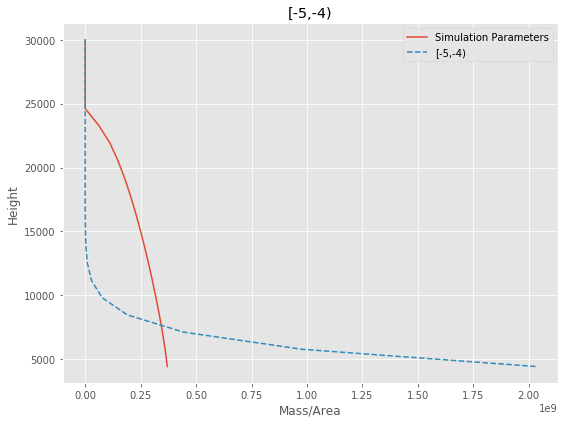

[-5,-4) Run Time: 1.22812 minutes


6006169166.091817
========[-4,-3)========
Run 0===========================================================================
3.0345711693138413
a* = -0.38127	b* = -2.34045	            h1* = 2.57790	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.68299	b = 1.09628	            h1 = 27806.33433	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 111
SSE: 0.14700459867389595


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.03457     1.68299
b    4.54571     1.09628
ftt    6,000       6,000
h1  18,263.4    27,806.3
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.038 minutes


Estimated remaining run time: 0.722 minutes


Run 1===========================================================================
1.6789646230304731
a* = -0.47686	b* = -1.94975	            h1* = 3.21488	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14231	            h1 = 28819.06389	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 133
SSE: 0.14598504091770834


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.67896     1.62073
b    1.92232     1.14231
ftt    6,000       6,000
h1  29,818.4    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.046 minutes


Estimated remaining run time: 0.820 minutes


Run 2===========================================================================
1.9384587021729658
a* = -0.20086	b* = -2.57869	            h1* = 2.23167	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.81802	b = 1.07587	            h1 = 26946.37021	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 252
SSE: 0.14916773524110657


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.93846     1.81802
b    3.62766     1.07587
ftt    6,000       6,000
h1  11,577.6    26,946.4
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.089 minutes


Estimated remaining run time: 1.518 minutes


Run 3===========================================================================
1.5178947245470185
a* = -0.47689	b* = -1.94983	            h1* = 3.21487	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62071	b = 1.14230	            h1 = 28819.05810	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 112
SSE: 0.14598504092107537


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.51789     1.62071
b    1.53895      1.1423
ftt    6,000       6,000
h1  20,865.7    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.037 minutes


Estimated remaining run time: 0.600 minutes


Run 4===========================================================================
2.460485363432972
a* = -0.47686	b* = -1.94974	            h1* = 3.21489	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14231	            h1 = 28819.07705	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 97
SSE: 0.14598504091905104


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.46049     1.62073
b    1.67803     1.14231
ftt    6,000       6,000
h1  23,046.9    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.034 minutes


Estimated remaining run time: 0.516 minutes


Run 5===========================================================================
3.093879662364024
a* = -0.47687	b* = -1.94977	            h1* = 3.21486	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62072	b = 1.14231	            h1 = 28819.04530	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 0.14598504091715617


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.09388     1.62072
b    2.27241     1.14231
ftt    6,000       6,000
h1  26,695.5      28,819
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.035 minutes


Estimated remaining run time: 0.492 minutes


Run 6===========================================================================
1.79209227109747
a* = -0.47685	b* = -1.94973	            h1* = 3.21489	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62074	b = 1.14231	            h1 = 28819.07757	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 0.14598504092436795


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.79209     1.62074
b    1.65155     1.14231
ftt    6,000       6,000
h1  25,142.6    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.033 minutes


Estimated remaining run time: 0.433 minutes


Run 7===========================================================================
3.4311163053811087
a* = -0.47687	b* = -1.94980	            h1* = 3.21490	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62072	b = 1.14230	            h1 = 28819.09608	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 122
SSE: 0.14598504092793757


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.43112     1.62072
b    2.40291      1.1423
ftt    6,000       6,000
h1  20,214.1    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.043 minutes


Estimated remaining run time: 0.519 minutes


Run 8===========================================================================
1.5340213133283718
a* = -0.47686	b* = -1.94974	            h1* = 3.21489	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14231	            h1 = 28819.07399	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 138
SSE: 0.14598504091849926


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.53402     1.62073
b    2.22168     1.14231
ftt    6,000       6,000
h1  14,700.8    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.048 minutes


Estimated remaining run time: 0.524 minutes


Run 9===========================================================================
1.435336458938043
a* = -0.47689	b* = -1.94979	            h1* = 3.21490	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62071	b = 1.14230	            h1 = 28819.08973	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 141
SSE: 0.14598504092652395


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.43534     1.62071
b    2.11712      1.1423
ftt    6,000       6,000
h1  19,363.7    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.048 minutes


Estimated remaining run time: 0.482 minutes


Run 10===========================================================================
1.8336858279829846
a* = -0.47686	b* = -1.94977	            h1* = 3.21488	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14231	            h1 = 28819.06529	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 136
SSE: 0.14598504091862435


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.83369     1.62073
b    1.79726     1.14231
ftt    6,000       6,000
h1  21,574.5    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.047 minutes


Estimated remaining run time: 0.422 minutes


Run 11===========================================================================
1.5167517154534158
a* = -0.47686	b* = -1.94974	            h1* = 3.21489	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14231	            h1 = 28819.08006	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 115
SSE: 0.14598504091899944


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.51675     1.62073
b    3.24496     1.14231
ftt    6,000       6,000
h1  23,163.1    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.039 minutes


Estimated remaining run time: 0.315 minutes


Run 12===========================================================================
11.026698119142


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:431: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 22.23054	b* = 2.86236	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 4514387374.62878	b = 18.50283	            h1 = 12505.25131	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 196
SSE: 0.32288103908962423


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    11.0267 4.51439e+09
b    1.64976     18.5028
ftt    6,000       6,000
h1  12,905.1    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.078 minutes


Estimated remaining run time: 0.545 minutes


Run 13===========================================================================
2.9164293463449082
a* = -0.47689	b* = -1.94978	            h1* = 3.21487	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62071	b = 1.14230	            h1 = 28819.05603	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 179
SSE: 0.1459850409223111


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.91643     1.62071
b    8.37148      1.1423
ftt    6,000       6,000
h1  15,161.2    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.056 minutes


Estimated remaining run time: 0.336 minutes


Run 14===========================================================================
2.023908243058231
a* = -0.47687	b* = -1.94977	            h1* = 3.21486	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62072	b = 1.14231	            h1 = 28819.03893	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 136
SSE: 0.1459850409192173


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.02391     1.62072
b    1.83633     1.14231
ftt    6,000       6,000
h1  15,649.5      28,819
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.047 minutes


Estimated remaining run time: 0.237 minutes


Run 15===========================================================================
1.7176837699972496
a* = -0.47686	b* = -1.94979	            h1* = 3.21486	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14230	            h1 = 28819.04707	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 135
SSE: 0.14598504091951733


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.71768     1.62073
b    2.09888      1.1423
ftt    6,000       6,000
h1  24,361.1      28,819
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.048 minutes


Estimated remaining run time: 0.194 minutes


Run 16===========================================================================
1.193782921550431
a* = -0.47686	b* = -1.94974	            h1* = 3.21488	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14231	            h1 = 28819.06683	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 110
SSE: 0.14598504091913658


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.19378     1.62073
b    3.45256     1.14231
ftt    6,000       6,000
h1  23,697.7    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.036 minutes


Estimated remaining run time: 0.109 minutes


Run 17===========================================================================
2.2516059615820225
a* = -0.38126	b* = -2.34043	            h1* = 2.57793	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.68300	b = 1.09629	            h1 = 27806.40191	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 215
SSE: 0.14700459867730656


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.25161       1.683
b    1.34507     1.09629
ftt    6,000       6,000
h1  12,484.1    27,806.4
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.074 minutes


Estimated remaining run time: 0.148 minutes


Run 18===========================================================================
5.250997693186421
a* = -0.47686	b* = -1.94979	            h1* = 3.21484	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62073	b = 1.14230	            h1 = 28819.02672	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 113
SSE: 0.14598504092257816


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a      5.251     1.62073
b    7.37754      1.1423
ftt    6,000       6,000
h1  25,684.7      28,819
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.038 minutes


Estimated remaining run time: 0.038 minutes


Run 19===========================================================================
2.7691478515257497
a* = -0.47690	b* = -1.94982	            h1* = 3.21488	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.62071	b = 1.14230	            h1 = 28819.06477	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 100
SSE: 0.1459850409234538


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.76915     1.62071
b    1.69068      1.1423
ftt    6,000       6,000
h1  21,000.3    28,819.1
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.034 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.95078 minutes


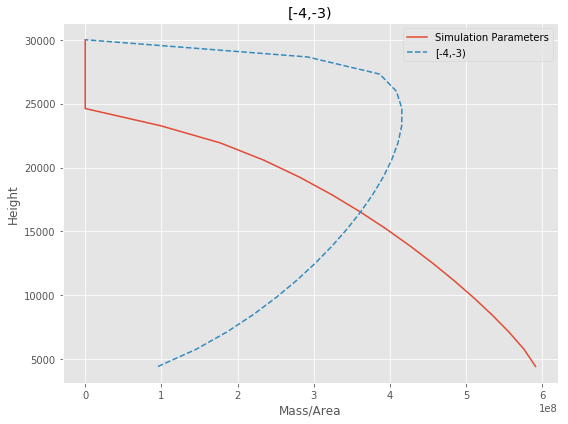

[-4,-3) Run Time: 0.95339 minutes


8068164622.312117
========[-3,-2)========
Run 0===========================================================================
2.6545727634753713
a* = -0.55336	b* = -1.73508	            h1* = 3.28642	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17639	            h1 = 28899.08724	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 130
SSE: 0.1846282129586257


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.65457     1.57501
b    1.73747     1.17639
ftt    6,000       6,000
h1  13,323.2    28,899.1
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.043 minutes


Estimated remaining run time: 0.826 minutes


Run 1===========================================================================
1.4119532425785344
a* = -0.55337	b* = -1.73515	            h1* = 3.28636	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17637	            h1 = 28899.01842	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 0.18462821296125861


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.41195     1.57501
b    5.86689     1.17637
ftt    6,000       6,000
h1  27,027.1      28,899
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.034 minutes


Estimated remaining run time: 0.605 minutes


Run 2===========================================================================
4.10164665566858
a* = -0.55335	b* = -1.73507	            h1* = 3.28641	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57502	b = 1.17639	            h1 = 28899.07916	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 128
SSE: 0.18462821295944154


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.10165     1.57502
b    3.17299     1.17639
ftt    6,000       6,000
h1  16,662.5    28,899.1
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.046 minutes


Estimated remaining run time: 0.779 minutes


Run 3===========================================================================
4.594664366049648
a* = 6.26693	b* = 2.90389	            h1* = 0.26122	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 527.85500	b = 19.24507	            h1 = 13888.84279	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 347
SSE: 0.2367345846312408


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.59466     527.855
b    4.86039     19.2451
ftt    6,000       6,000
h1  12,920.9    13,888.8
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.112 minutes


Estimated remaining run time: 1.788 minutes


Run 4===========================================================================
1.7555824544502263
a* = -0.55337	b* = -1.73514	            h1* = 3.28638	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17638	            h1 = 28899.04098	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 101
SSE: 0.1846282129560139


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.75558     1.57501
b    3.80207     1.17638
ftt    6,000       6,000
h1  27,254.9      28,899
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.035 minutes


Estimated remaining run time: 0.527 minutes


Run 5===========================================================================
1.662623402465413
a* = -0.55336	b* = -1.73510	            h1* = 3.28641	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17638	            h1 = 28899.07547	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 113
SSE: 0.18462821295644063


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.66262     1.57501
b   1.75839     1.17638
ftt   6,000       6,000
h1   24,565    28,899.1
u       5.6         5.6
v       8.2         8.2

Run 5 Time: 0.040 minutes


Estimated remaining run time: 0.558 minutes


Run 6===========================================================================
1.7008127983548975
a* = -0.55338	b* = -1.73512	            h1* = 3.28637	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57500	b = 1.17638	            h1 = 28899.03004	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 128
SSE: 0.1846282129613009


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.70081       1.575
b    1.06715     1.17638
ftt    6,000       6,000
h1  17,708.1      28,899
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.047 minutes


Estimated remaining run time: 0.616 minutes


Run 7===========================================================================
1.0950093424409444
a* = 1.16207	b* = -2.84559	            h1* = 0.65961	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 4.19656	b = 1.05810	            h1 = 17888.25002	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 115
SSE: 0.22131483114621225


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.09501     4.19656
b    1.31247      1.0581
ftt    6,000       6,000
h1  14,154.5    17,888.3
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.042 minutes


Estimated remaining run time: 0.509 minutes


Run 8===========================================================================
4.543632400587492
a* = 11.91776	b* = 8.18119	            h1* = 0.01957	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 149906.01627	b = 3574.10492	            h1 = 11252.39388	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 180
SSE: 0.41579401617938466


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.54363     149,906
b    1.14666     3,574.1
ftt    6,000       6,000
h1  11,853.6    11,252.4
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.070 minutes


Estimated remaining run time: 0.773 minutes


Run 9===========================================================================
1.1840219587586607
a* = 11.52772	b* = 10.00223	            h1* = 0.27473	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 101491.18797	b = 22076.59398	            h1 = 14033.16867	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 159
SSE: 0.28298662558588433


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.18402     101,491
b    1.61264    22,076.6
ftt    6,000       6,000
h1  11,464.2    14,033.2
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.062 minutes


Estimated remaining run time: 0.620 minutes


Run 10===========================================================================
1.125326151651736
a* = -0.55336	b* = -1.73509	            h1* = 3.28642	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17639	            h1 = 28899.08603	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 132
SSE: 0.18462821295758713


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.12533     1.57501
b     2.3106     1.17639
ftt    6,000       6,000
h1  23,659.4    28,899.1
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.044 minutes


Estimated remaining run time: 0.398 minutes


Run 11===========================================================================
8.481756148716823
a* = 35.24923	b* = -11.24703	            h1* = 0.25768	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2034904960063396.25000	b = 1.00001	            h1 = 13851.00000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 313
SSE: 0.23673855887411127


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    8.48176  2.0349e+15
b    3.37036     1.00001
ftt    6,000       6,000
h1  12,184.6      13,851
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.116 minutes


Estimated remaining run time: 0.925 minutes


Run 12===========================================================================
1.7955690164903797
a* = -0.39470	b* = -2.08531	            h1* = 2.34110	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.67389	b = 1.12427	            h1 = 27247.89040	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 129
SSE: 0.1890446291119409


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.79557     1.67389
b    6.08715     1.12427
ftt    6,000       6,000
h1  15,836.8    27,247.9
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.042 minutes


Estimated remaining run time: 0.292 minutes


Run 13===========================================================================
2.1671631576194064
a* = -0.55338	b* = -1.73514	            h1* = 3.28635	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57500	b = 1.17638	            h1 = 28899.01128	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 121
SSE: 0.1846282129687201


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.16716       1.575
b    3.38698     1.17638
ftt    6,000       6,000
h1  19,399.8      28,899
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.043 minutes


Estimated remaining run time: 0.261 minutes


Run 14===========================================================================
3.649668170707507
a* = -0.55338	b* = -1.73514	            h1* = 3.28640	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17638	            h1 = 28899.06605	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 112
SSE: 0.18462821295762694


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.64967     1.57501
b    1.69587     1.17638
ftt    6,000       6,000
h1  20,328.5    28,899.1
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.039 minutes


Estimated remaining run time: 0.193 minutes


Run 15===========================================================================
6.657893863343989
a* = -0.50531	b* = -1.98159	            h1* = 2.67461	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.60332	b = 1.13785	            h1 = 28001.64931	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 167
SSE: 0.18631762981239816


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    6.65789     1.60332
b    4.67532     1.13785
ftt    6,000       6,000
h1  15,138.7    28,001.6
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.058 minutes


Estimated remaining run time: 0.232 minutes


Run 16===========================================================================
1.27720155200201
a* = -0.55337	b* = -1.73513	            h1* = 3.28640	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17638	            h1 = 28899.06153	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 175
SSE: 0.18462821295852086


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     1.2772     1.57501
b    1.80501     1.17638
ftt    6,000       6,000
h1  13,126.6    28,899.1
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.058 minutes


Estimated remaining run time: 0.175 minutes


Run 17===========================================================================
1.2910502060827425
a* = -0.55335	b* = -1.73511	            h1* = 3.28635	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57502	b = 1.17638	            h1 = 28899.00731	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 99
SSE: 0.18462821296868753


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.29105     1.57502
b    6.65353     1.17638
ftt    6,000       6,000
h1  22,707.1      28,899
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.033 minutes


Estimated remaining run time: 0.066 minutes


Run 18===========================================================================
2.411138401668423
a* = -0.55338	b* = -1.73510	            h1* = 3.28642	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17638	            h1 = 28899.08677	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 83
SSE: 0.18462821296132428


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.41114     1.57501
b    1.52967     1.17638
ftt    6,000       6,000
h1  18,176.9    28,899.1
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.029 minutes


Estimated remaining run time: 0.029 minutes


Run 19===========================================================================
1.1826145109046802
a* = -0.55336	b* = -1.73509	            h1* = 3.28638	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.57501	b = 1.17638	            h1 = 28899.04450	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 132
SSE: 0.18462821295798154


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.18261     1.57501
b    1.51044     1.17638
ftt    6,000       6,000
h1  19,630.6      28,899
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.045 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.03932 minutes


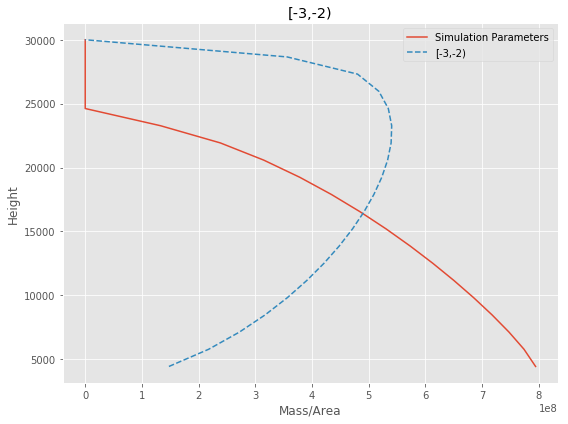

[-3,-2) Run Time: 1.04141 minutes


9110738766.610346
========[-2,-1)========
Run 0===========================================================================
1.976105046465483
a* = -0.87235	b* = -2.09172	            h1* = 3.22962	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12348	            h1 = 28836.00967	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 134
SSE: 0.1838127439658666


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.97611     1.41797
b    2.25102     1.12348
ftt    6,000       6,000
h1  10,000.8      28,836
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.044 minutes


Estimated remaining run time: 0.836 minutes


Run 1===========================================================================
2.051552822629154
a* = -0.87236	b* = -2.09177	            h1* = 3.22958	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41796	b = 1.12347	            h1 = 28835.95621	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 126
SSE: 0.18381274396662609


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.05155     1.41796
b    4.35178     1.12347
ftt    6,000       6,000
h1  21,107.4      28,836
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.043 minutes


Estimated remaining run time: 0.783 minutes


Run 2===========================================================================
2.044443403329204
a* = -0.87235	b* = -2.09172	            h1* = 3.22957	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12348	            h1 = 28835.94992	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 116
SSE: 0.18381274396625558


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.04444     1.41797
b    4.01635     1.12348
ftt    6,000       6,000
h1  6,860.44    28,835.9
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.040 minutes


Estimated remaining run time: 0.686 minutes


Run 3===========================================================================
1.3346192648798103
a* = -0.87236	b* = -2.09175	            h1* = 3.22958	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41796	b = 1.12347	            h1 = 28835.95629	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 142
SSE: 0.18381274396228015


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.33462     1.41796
b    1.89634     1.12347
ftt    6,000       6,000
h1  25,553.9      28,836
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.048 minutes


Estimated remaining run time: 0.762 minutes


Run 4===========================================================================
2.2979430780225534
a* = -0.87233	b* = -2.09179	            h1* = 3.22953	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41798	b = 1.12347	            h1 = 28835.90655	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 105
SSE: 0.18381274400340802


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.29794     1.41798
b    2.80619     1.12347
ftt    6,000       6,000
h1  15,845.9    28,835.9
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.035 minutes


Estimated remaining run time: 0.531 minutes


Run 5===========================================================================
1.520680621332246
a* = -0.78907	b* = -2.54322	            h1* = 2.23630	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.45427	b = 1.07861	            h1 = 26959.72023	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 84
SSE: 0.19177372563750772


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.52068     1.45427
b   4.72574     1.07861
ftt   6,000       6,000
h1   17,844    26,959.7
u       5.6         5.6
v       8.2         8.2

Run 5 Time: 0.030 minutes


Estimated remaining run time: 0.419 minutes


Run 6===========================================================================
3.7812636804532267
a* = -0.85448	b* = -2.39391	            h1* = 2.58759	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.42550	b = 1.09127	            h1 = 27826.70993	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 117
SSE: 0.18677367295429803


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.78126      1.4255
b    1.51574     1.09127
ftt    6,000       6,000
h1  17,359.2    27,826.7
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.042 minutes


Estimated remaining run time: 0.542 minutes


Run 7===========================================================================
1.3053899538089844
a* = -0.78906	b* = -2.54321	            h1* = 2.23630	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.45427	b = 1.07861	            h1 = 26959.74073	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 76
SSE: 0.19177372563947495


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.30539     1.45427
b    1.09419     1.07861
ftt    6,000       6,000
h1  21,415.3    26,959.7
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.026 minutes


Estimated remaining run time: 0.306 minutes


Run 8===========================================================================
1.9240257748629688
a* = -0.87235	b* = -2.09173	            h1* = 3.22963	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12347	            h1 = 28836.01636	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 118
SSE: 0.18381274397136727


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.92403     1.41797
b    2.22172     1.12347
ftt    6,000       6,000
h1  15,145.4      28,836
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.041 minutes


Estimated remaining run time: 0.447 minutes


Run 9===========================================================================
1.4566376424976881
a* = -0.87235	b* = -2.09179	            h1* = 3.22955	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12347	            h1 = 28835.92572	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 0.1838127439773465


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.45664     1.41797
b    1.22487     1.12347
ftt    6,000       6,000
h1  20,855.4    28,835.9
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.032 minutes


Estimated remaining run time: 0.323 minutes


Run 10===========================================================================
3.231401342971694
a* = -0.87235	b* = -2.09171	            h1* = 3.22962	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12348	            h1 = 28836.00645	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 118
SSE: 0.1838127439647251


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     3.2314     1.41797
b    1.79538     1.12348
ftt    6,000       6,000
h1  16,584.3      28,836
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.037 minutes


Estimated remaining run time: 0.330 minutes


Run 11===========================================================================
1.274638471793322
a* = -0.87234	b* = -2.09172	            h1* = 3.22958	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12347	            h1 = 28835.95683	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 115
SSE: 0.18381274396124925


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.27464     1.41797
b    2.62484     1.12347
ftt    6,000       6,000
h1  13,213.7      28,836
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.040 minutes


Estimated remaining run time: 0.321 minutes


Run 12===========================================================================
4.952388716028432
a* = -0.85449	b* = -2.39386	            h1* = 2.58765	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.42550	b = 1.09128	            h1 = 27826.84115	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 90
SSE: 0.18677367295131908


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.95239      1.4255
b     1.2661     1.09128
ftt    6,000       6,000
h1  24,121.1    27,826.8
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.030 minutes


Estimated remaining run time: 0.213 minutes


Run 13===========================================================================
1.806243891056358
a* = -0.87234	b* = -2.09174	            h1* = 3.22959	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12347	            h1 = 28835.97742	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 137
SSE: 0.18381274395931138


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.80624     1.41797
b    1.75422     1.12347
ftt    6,000       6,000
h1  18,849.6      28,836
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.043 minutes


Estimated remaining run time: 0.261 minutes


Run 14===========================================================================
1.3995868451604216
a* = -0.87233	b* = -2.09170	            h1* = 3.22959	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41798	b = 1.12348	            h1 = 28835.96729	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 0.18381274396867434


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.39959     1.41798
b     1.3934     1.12348
ftt    6,000       6,000
h1  19,689.2      28,836
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.033 minutes


Estimated remaining run time: 0.163 minutes


Run 15===========================================================================
1.5584271613426406
a* = -0.85449	b* = -2.39386	            h1* = 2.58765	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.42550	b = 1.09128	            h1 = 27826.83849	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 168
SSE: 0.1867736729500967


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.55843      1.4255
b    2.69862     1.09128
ftt    6,000       6,000
h1  11,509.5    27,826.8
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.056 minutes


Estimated remaining run time: 0.225 minutes


Run 16===========================================================================
1.5035646844849113
a* = -0.78906	b* = -2.54325	            h1* = 2.23628	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.45427	b = 1.07861	            h1 = 26959.67796	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 115
SSE: 0.19177372563946943


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.50356     1.45427
b    4.69185     1.07861
ftt    6,000       6,000
h1  17,243.7    26,959.7
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.043 minutes


Estimated remaining run time: 0.128 minutes


Run 17===========================================================================
1.8655665939800508
a* = -0.87232	b* = -2.09172	            h1* = 3.22962	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41798	b = 1.12347	            h1 = 28836.00198	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 124
SSE: 0.1838127439732775


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.86557     1.41798
b    3.47256     1.12347
ftt    6,000       6,000
h1  21,969.6      28,836
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.042 minutes


Estimated remaining run time: 0.085 minutes


Run 18===========================================================================
1.7881667192363389
a* = -0.87236	b* = -2.09176	            h1* = 3.22959	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41796	b = 1.12347	            h1 = 28835.96710	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 100
SSE: 0.18381274396497393


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.78817     1.41796
b    4.27198     1.12347
ftt    6,000       6,000
h1  29,187.8      28,836
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.035 minutes


Estimated remaining run time: 0.035 minutes


Run 19===========================================================================
3.178345290383424
a* = -0.87235	b* = -2.09174	            h1* = 3.22957	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.41797	b = 1.12347	            h1 = 28835.94486	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 98
SSE: 0.18381274396392153


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.17835     1.41797
b    3.02899     1.12347
ftt    6,000       6,000
h1  21,713.6    28,835.9
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.033 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.77370 minutes


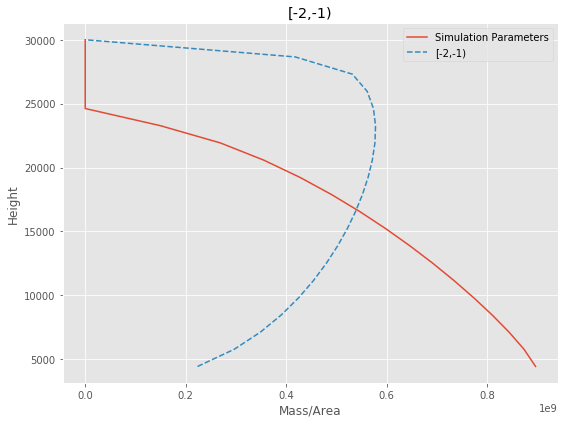

[-2,-1) Run Time: 0.77656 minutes


8648366582.16272
========[-1,0)========
Run 0===========================================================================
1.2680497463773204
a* = -0.07085	b* = -1.34113	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26155	            h1 = 20583.75831	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 209
SSE: 0.15807507468880924


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.26805      1.9316
b     1.8779     1.26155
ftt    6,000       6,000
h1  21,567.9    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.071 minutes


Estimated remaining run time: 1.351 minutes


Run 1===========================================================================
3.5001561948374267
a* = -0.07086	b* = -1.34112	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93159	b = 1.26155	            h1 = 20583.75996	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 154
SSE: 0.15807507468932305


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.50016     1.93159
b    1.79728     1.26155
ftt    6,000       6,000
h1  20,720.4    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.051 minutes


Estimated remaining run time: 0.923 minutes


Run 2===========================================================================
1.3264602390191744
a* = -0.11775	b* = -1.69519	            h1* = 0.97580	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.88892	b = 1.18356	            h1 = 20579.74505	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 135
SSE: 0.15810021442680938


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.32646     1.88892
b    1.81148     1.18356
ftt    6,000       6,000
h1  9,134.31    20,579.7
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.047 minutes


Estimated remaining run time: 0.797 minutes


Run 3===========================================================================
3.0855695080515577
a* = -0.07085	b* = -1.34111	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26155	            h1 = 20583.75748	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 186
SSE: 0.15807507469202225


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.08557      1.9316
b    2.20316     1.26155
ftt    6,000       6,000
h1  21,217.7    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.062 minutes


Estimated remaining run time: 0.988 minutes


Run 4===========================================================================
24.440894188387496
a* = -0.07085	b* = -1.34108	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26156	            h1 = 20583.76316	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 207
SSE: 0.15807507468960863


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    24.4409      1.9316
b    3.02742     1.26156
ftt    6,000       6,000
h1  21,275.3    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.068 minutes


Estimated remaining run time: 1.023 minutes


Run 5===========================================================================
1.8920353015379368
a* = -0.07085	b* = -1.34112	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26155	            h1 = 20583.76074	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 176
SSE: 0.15807507468981374


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.89204      1.9316
b    1.49504     1.26155
ftt    6,000       6,000
h1  18,853.6    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.060 minutes


Estimated remaining run time: 0.835 minutes


Run 6===========================================================================
5.249381671524615
a* = 0.02742	b* = -0.80299	            h1* = 1.04854	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.02780	b = 1.44799	            h1 = 21131.11925	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 193
SSE: 0.1581318035292431


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    5.24938      2.0278
b    1.13866     1.44799
ftt    6,000       6,000
h1  11,706.8    21,131.1
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.067 minutes


Estimated remaining run time: 0.867 minutes


Run 7===========================================================================
1.271958623153131
a* = -0.07085	b* = -1.34110	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26156	            h1 = 20583.76082	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 228
SSE: 0.15807507468846937


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.27196      1.9316
b    1.61865     1.26156
ftt    6,000       6,000
h1  18,968.8    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.077 minutes


Estimated remaining run time: 0.928 minutes


Run 8===========================================================================
4.067765310931889
a* = -0.11640	b* = -1.68239	            h1* = 0.97363	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.89012	b = 1.18593	            h1 = 20562.90777	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 335
SSE: 0.15810083795035015


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.06777     1.89012
b    1.50802     1.18593
ftt    6,000       6,000
h1  6,702.39    20,562.9
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.115 minutes


Estimated remaining run time: 1.266 minutes


Run 9===========================================================================
1.4821060379194737
a* = -0.11754	b* = -1.69455	            h1* = 0.97580	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.88911	b = 1.18368	            h1 = 20579.74980	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 144
SSE: 0.158100213551365


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.48211     1.88911
b    1.25037     1.18368
ftt    6,000       6,000
h1  24,260.7    20,579.7
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.048 minutes


Estimated remaining run time: 0.479 minutes


Run 10===========================================================================
2.8568582571558796
a* = -0.07086	b* = -1.34112	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93159	b = 1.26155	            h1 = 20583.75827	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 145
SSE: 0.1580750746898433


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.85686     1.93159
b    1.65883     1.26155
ftt    6,000       6,000
h1  14,715.2    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.047 minutes


Estimated remaining run time: 0.427 minutes


Run 11===========================================================================
1.939390519106532
a* = -0.11861	b* = -1.60768	            h1* = 0.97580	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.88815	b = 1.20035	            h1 = 20579.75520	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 168
SSE: 0.1580899028051528


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.93939     1.88815
b    4.61872     1.20035
ftt    6,000       6,000
h1  25,511.8    20,579.8
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.055 minutes


Estimated remaining run time: 0.444 minutes


Run 12===========================================================================
7.522014726244573
a* = -0.07084	b* = -1.34107	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93161	b = 1.26157	            h1 = 20583.76310	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 153
SSE: 0.15807507468944584


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    7.52201     1.93161
b    1.46809     1.26157
ftt    6,000       6,000
h1  20,830.5    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.051 minutes


Estimated remaining run time: 0.357 minutes


Run 13===========================================================================
2.455938596288586
a* = -0.07085	b* = -1.34110	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26156	            h1 = 20583.76055	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 251
SSE: 0.1580750746887033


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.45594      1.9316
b    2.48812     1.26156
ftt    6,000       6,000
h1  15,986.4    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.082 minutes


Estimated remaining run time: 0.494 minutes


Run 14===========================================================================
2.099775758926382
a* = -0.07084	b* = -1.34105	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93161	b = 1.26157	            h1 = 20583.76477	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 201
SSE: 0.15807507469008836


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.09978     1.93161
b    1.76361     1.26157
ftt    6,000       6,000
h1  16,686.5    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.067 minutes


Estimated remaining run time: 0.333 minutes


Run 15===========================================================================
4.608291278587253
a* = -0.07086	b* = -1.34111	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26156	            h1 = 20583.76093	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 215
SSE: 0.15807507468936188


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.60829      1.9316
b    3.48619     1.26156
ftt    6,000       6,000
h1  21,132.2    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.071 minutes


Estimated remaining run time: 0.284 minutes


Run 16===========================================================================
1.325260362605265
a* = -0.07085	b* = -1.34112	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26155	            h1 = 20583.75853	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 313
SSE: 0.15807507468902235


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.32526      1.9316
b   2.08668     1.26155
ftt   6,000       6,000
h1   22,579    20,583.8
u       5.6         5.6
v       8.2         8.2

Run 16 Time: 0.102 minutes


Estimated remaining run time: 0.306 minutes


Run 17===========================================================================
2.0718438652379776
a* = -0.07085	b* = -1.34110	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26156	            h1 = 20583.76132	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 163
SSE: 0.15807507468912205


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.07184      1.9316
b    1.50512     1.26156
ftt    6,000       6,000
h1  15,657.4    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.053 minutes


Estimated remaining run time: 0.105 minutes


Run 18===========================================================================
3.8218551269257004
a* = -0.07085	b* = -1.34111	            h1* = 0.97632	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.93160	b = 1.26155	            h1 = 20583.75915	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 232
SSE: 0.1580750746887974


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.82186      1.9316
b    2.65168     1.26155
ftt    6,000       6,000
h1  27,034.7    20,583.8
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.077 minutes


Estimated remaining run time: 0.077 minutes


Run 19===========================================================================
1.5887945230859053
a* = -0.11756	b* = -1.69462	            h1* = 0.97580	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.88909	b = 1.18367	            h1 = 20579.74962	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 128
SSE: 0.15810021356307838


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.58879     1.88909
b    4.43844     1.18367
ftt    6,000       6,000
h1  16,740.9    20,579.7
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.043 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.31406 minutes


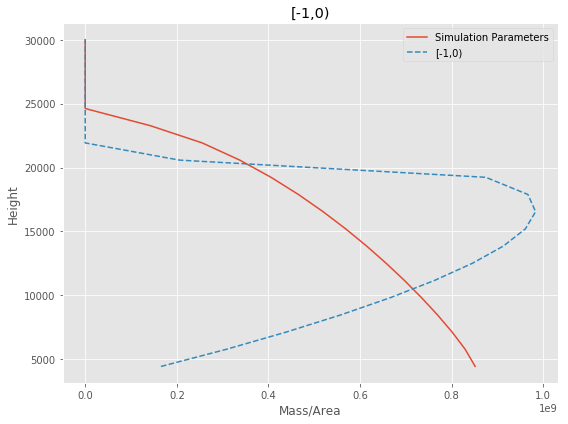

[-1,0) Run Time: 1.31693 minutes


6901066909.641724
========[0,1)========
Run 0===========================================================================
2.593104502021925
a* = 0.41679	b* = -2.41717	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51709	b = 1.08917	            h1 = 12505.26576	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 271
SSE: 0.1666306222393907


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     2.5931     2.51709
b    1.48407     1.08917
ftt    6,000       6,000
h1  22,255.8    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.089 minutes


Estimated remaining run time: 1.697 minutes


Run 1===========================================================================
6.316639262646388
a* = 0.41826	b* = -2.40030	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51932	b = 1.09069	            h1 = 12505.26915	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 349
SSE: 0.1666306592194924


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    6.31664     2.51932
b    7.62734     1.09069
ftt    6,000       6,000
h1  21,819.8    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.112 minutes


Estimated remaining run time: 2.016 minutes


Run 2===========================================================================
2.1637704177787485
a* = 0.41688	b* = -2.41554	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51722	b = 1.08932	            h1 = 12505.26608	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 353
SSE: 0.1666306225554481


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.16377     2.51722
b    2.02406     1.08932
ftt    6,000       6,000
h1  20,544.4    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.115 minutes


Estimated remaining run time: 1.952 minutes


Run 3===========================================================================
1.21479260981396
a* = 0.41719	b* = -2.41719	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51769	b = 1.08917	            h1 = 12505.26556	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 342
SSE: 0.166630627903047


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.21479     2.51769
b      2.365     1.08917
ftt    6,000       6,000
h1  14,866.1    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.111 minutes


Estimated remaining run time: 1.775 minutes


Run 4===========================================================================
2.041160364246449
a* = 0.41690	b* = -2.41458	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51725	b = 1.08941	            h1 = 12505.26630	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 344
SSE: 0.16663062289633962


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.04116     2.51725
b    1.83645     1.08941
ftt    6,000       6,000
h1  16,061.4    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.117 minutes


Estimated remaining run time: 1.754 minutes


Run 5===========================================================================
1.884185022796949
a* = 0.41684	b* = -2.41651	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51716	b = 1.08923	            h1 = 12505.26589	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 355
SSE: 0.16663062227514935


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.88419     2.51716
b    1.16209     1.08923
ftt    6,000       6,000
h1  15,062.7    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.114 minutes


Estimated remaining run time: 1.601 minutes


Run 6===========================================================================
4.836151897973828
a* = 0.72882	b* = -0.09503	            h1* = 0.26735	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.07262	b = 1.90935	            h1 = 13954.40247	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 73
SSE: 0.16725508712645798


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.83615     3.07262
b    1.94272     1.90935
ftt    6,000       6,000
h1  22,512.5    13,954.4
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.024 minutes


Estimated remaining run time: 0.318 minutes


Run 7===========================================================================
1.6348648110965702
a* = 0.41680	b* = -2.41713	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51709	b = 1.08918	            h1 = 12505.26577	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 331
SSE: 0.1666306222390146


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.63486     2.51709
b    2.37013     1.08918
ftt    6,000       6,000
h1  19,053.1    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.111 minutes


Estimated remaining run time: 1.331 minutes


Run 8===========================================================================
1.5937338831420755
a* = 0.55244	b* = -1.02345	            h1* = 0.15475	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.73749	b = 1.35935	            h1 = 12737.70342	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 352
SSE: 0.16686284879708052


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.59373     2.73749
b    5.61018     1.35935
ftt    6,000       6,000
h1  23,036.1    12,737.7
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.113 minutes


Estimated remaining run time: 1.243 minutes


Run 9===========================================================================
3.396168226257538
a* = 0.41686	b* = -2.41579	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51719	b = 1.08930	            h1 = 12505.26606	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 345
SSE: 0.16663062240361737


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.39617     2.51719
b    4.66878      1.0893
ftt    6,000       6,000
h1  22,471.2    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.117 minutes


Estimated remaining run time: 1.174 minutes


Run 10===========================================================================
1.5637604945798291
a* = 0.41680	b* = -2.41715	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51709	b = 1.08918	            h1 = 12505.26576	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 169
SSE: 0.16663062223940636


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.56376     2.51709
b    1.40305     1.08918
ftt    6,000       6,000
h1  14,726.6    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.057 minutes


Estimated remaining run time: 0.509 minutes


Run 11===========================================================================
1.1657972403016645
a* = 0.42163	b* = -2.31814	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.52445	b = 1.09846	            h1 = 12505.30444	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 344
SSE: 0.1666314910182172


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     1.1658     2.52445
b    2.06499     1.09846
ftt    6,000       6,000
h1  25,511.1    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.113 minutes


Estimated remaining run time: 0.900 minutes


Run 12===========================================================================
14.47727179771381
a* = 0.42256	b* = -2.29841	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.52586	b = 1.10042	            h1 = 12505.31694	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 348
SSE: 0.16663200409218767


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    14.4773     2.52586
b    2.54943     1.10042
ftt    6,000       6,000
h1  28,117.6    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.113 minutes


Estimated remaining run time: 0.787 minutes


Run 13===========================================================================
4.908586501912679
a* = 0.43545	b* = -2.11908	            h1* = 0.13352	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.54566	b = 1.12014	            h1 = 12505.70903	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 346
SSE: 0.1666384036522747


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.90859     2.54566
b    1.23125     1.12014
ftt    6,000       6,000
h1  18,523.8    12,505.7
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.118 minutes


Estimated remaining run time: 0.706 minutes


Run 14===========================================================================
4.75200165370963
a* = 0.42410	b* = -2.27574	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.52821	b = 1.10272	            h1 = 12505.34218	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 346
SSE: 0.1666324052636637


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a      4.752     2.52821
b    4.74949     1.10272
ftt    6,000       6,000
h1  7,154.78    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.116 minutes


Estimated remaining run time: 0.581 minutes


Run 15===========================================================================
1.6658707179089178
a* = 0.41680	b* = -2.41709	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51710	b = 1.08918	            h1 = 12505.26577	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 269
SSE: 0.1666306222389397


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.66587      2.5171
b    1.32628     1.08918
ftt    6,000       6,000
h1  15,530.6    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.089 minutes


Estimated remaining run time: 0.354 minutes


Run 16===========================================================================
1.36700357281584
a* = 0.42074	b* = -2.36074	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.52309	b = 1.09435	            h1 = 12505.28130	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 340
SSE: 0.16663091353463608


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a      1.367     2.52309
b     2.0768     1.09435
ftt    6,000       6,000
h1  12,496.1    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.112 minutes


Estimated remaining run time: 0.335 minutes


Run 17===========================================================================
1.102158274445351
a* = 0.42881	b* = -2.17855	            h1* = 0.13350	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.53543	b = 1.11321	            h1 = 12505.49549	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 348
SSE: 0.1666364431967093


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.10216     2.53543
b    2.96986     1.11321
ftt    6,000       6,000
h1  26,018.7    12,505.5
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.116 minutes


Estimated remaining run time: 0.232 minutes


Run 18===========================================================================
1.4062078611774143
a* = 0.41680	b* = -2.41708	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.51710	b = 1.08918	            h1 = 12505.26578	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 314
SSE: 0.16663062223902408


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.40621      2.5171
b    1.66852     1.08918
ftt    6,000       6,000
h1  19,231.4    12,505.3
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.106 minutes


Estimated remaining run time: 0.106 minutes


Run 19===========================================================================
1.6484628646919426
a* = 0.41929	b* = -2.32686	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.52088	b = 1.09760	            h1 = 12505.30092	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 347
SSE: 0.1666316295138607


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.64846     2.52088
b   2.32732      1.0976
ftt   6,000       6,000
h1   29,448    12,505.3
u       5.6         5.6
v       8.2         8.2

Run 19 Time: 0.116 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 2.07786 minutes


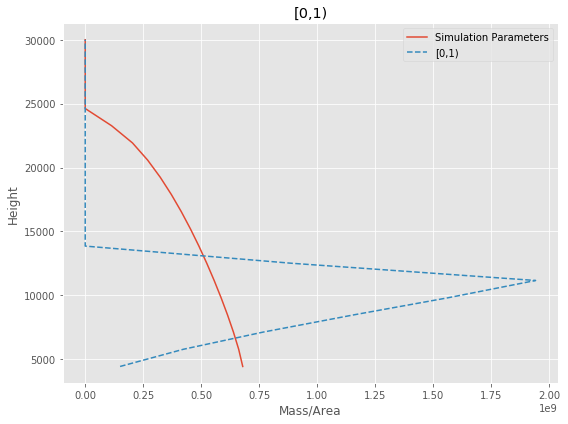

[0,1) Run Time: 2.08021 minutes


4629137051.124315
========[1,2)========
Run 0===========================================================================
1.3192569718962628
a* = 0.64417	b* = -1.70683	            h1* = -0.10258	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.90440	b = 1.18144	            h1 = 9906.25754	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 352
SSE: 0.2617811034590353


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.31926      2.9044
b    2.32043     1.18144
ftt    6,000       6,000
h1  17,222.6    9,906.26
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.120 minutes


Estimated remaining run time: 2.271 minutes


Run 1===========================================================================
3.4933882935309915
a* = 0.62415	b* = -2.02822	            h1* = -0.10859	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.86666	b = 1.13157	            h1 = 9840.37690	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 343
SSE: 0.26175612969444373


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.49339     2.86666
b    2.48576     1.13157
ftt    6,000       6,000
h1  15,309.7    9,840.38
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.115 minutes


Estimated remaining run time: 2.077 minutes


Run 2===========================================================================
4.130355813509608
a* = 0.60857	b* = -2.36666	            h1* = -0.11065	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.83779	b = 1.09379	            h1 = 9817.76939	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 241
SSE: 0.26174674535039494


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.13036     2.83779
b    1.63053     1.09379
ftt    6,000       6,000
h1  14,903.1    9,817.77
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.083 minutes


Estimated remaining run time: 1.408 minutes


Run 3===========================================================================
3.2638804822890055
a* = 0.60855	b* = -2.36715	            h1* = -0.11065	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.83776	b = 1.09375	            h1 = 9817.75712	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 337
SSE: 0.26174674536948156


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.26388     2.83776
b    1.52156     1.09375
ftt    6,000       6,000
h1  20,840.1    9,817.76
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.111 minutes


Estimated remaining run time: 1.779 minutes


Run 4===========================================================================
2.1242617742991268
a* = 0.57324	b* = -1.12663	            h1* = 0.01116	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.77401	b = 1.32412	            h1 = 11159.49852	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 147
SSE: 0.26244963496093093


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.12426     2.77401
b    1.57927     1.32412
ftt    6,000       6,000
h1  16,912.1    11,159.5
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.053 minutes


Estimated remaining run time: 0.797 minutes


Run 5===========================================================================
2.363747651563876
a* = 0.91035	b* = 0.25910	            h1* = 0.06431	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.48520	b = 2.29576	            h1 = 11745.59948	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 0.262267931847476


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.36375      3.4852
b    2.13249     2.29576
ftt    6,000       6,000
h1  26,322.5    11,745.6
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.034 minutes


Estimated remaining run time: 0.474 minutes


Run 6===========================================================================
1.9076282950988936
a* = 0.62063	b* = -2.10964	            h1* = -0.10948	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.86010	b = 1.12128	            h1 = 9830.60047	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 347
SSE: 0.261752825249689


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.90763      2.8601
b    2.74477     1.12128
ftt    6,000       6,000
h1  23,940.2     9,830.6
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.115 minutes


Estimated remaining run time: 1.493 minutes


Run 7===========================================================================
1.4631544095186864
a* = 0.63190	b* = -1.94577	            h1* = -0.10786	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.88119	b = 1.14288	            h1 = 9848.35842	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 345
SSE: 0.2617615199820826


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.46315     2.88119
b    2.28212     1.14288
ftt    6,000       6,000
h1  24,490.7    9,848.36
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.111 minutes


Estimated remaining run time: 1.334 minutes


Run 8===========================================================================
1.499072828977352
a* = -0.16188	b* = -3.48445	            h1* = 0.13348	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.85054	b = 1.03067	            h1 = 12505.25000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 197
SSE: 0.2875961890839139


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.49907     1.85054
b    1.08695     1.03067
ftt    6,000       6,000
h1  21,722.8    12,505.2
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.064 minutes


Estimated remaining run time: 0.699 minutes


Run 9===========================================================================
2.4458786781047226
a* = 0.62142	b* = -2.05835	            h1* = -0.10894	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.86157	b = 1.12766	            h1 = 9836.46502	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 342
SSE: 0.26175537796885545


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.44588     2.86157
b    2.50938     1.12766
ftt    6,000       6,000
h1  21,174.8    9,836.47
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.099 minutes


Estimated remaining run time: 0.995 minutes


Run 10===========================================================================
1.7222851600560265
a* = 0.08246	b* = -3.67190	            h1* = 0.01116	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.08596	b = 1.02543	            h1 = 11159.50000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 265
SSE: 0.27426238642116135


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.72229     2.08596
b    1.1747     1.02543
ftt   6,000       6,000
h1   20,483    11,159.5
u       5.6         5.6
v       8.2         8.2

Run 10 Time: 0.081 minutes


Estimated remaining run time: 0.731 minutes


Run 11===========================================================================
1.6951225074767016
a* = 0.60918	b* = -2.33071	            h1* = -0.11055	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.83891	b = 1.09723	            h1 = 9818.90016	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 344
SSE: 0.2617469346823339


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.69512     2.83891
b    1.92253     1.09723
ftt    6,000       6,000
h1  16,897.1     9,818.9
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.111 minutes


Estimated remaining run time: 0.890 minutes


Run 12===========================================================================
1.7537746106968988
a* = 0.61951	b* = -2.14436	            h1* = -0.10970	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.85802	b = 1.11714	            h1 = 9828.18011	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 346
SSE: 0.2617506316602592


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.75377     2.85802
b    2.26183     1.11714
ftt    6,000       6,000
h1  28,972.7    9,828.18
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.112 minutes


Estimated remaining run time: 0.782 minutes


Run 13===========================================================================
1.5592431622853355
a* = 0.64948	b* = -1.62165	            h1* = -0.09983	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.91454	b = 1.19757	            h1 = 9936.54710	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 348
SSE: 0.2617909802978125


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.55924     2.91454
b    6.23491     1.19757
ftt    6,000       6,000
h1  8,635.36    9,936.55
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.117 minutes


Estimated remaining run time: 0.703 minutes


Run 14===========================================================================
1.369651381211292
a* = 0.77982	b* = -0.38739	            h1* = 0.01144	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.18109	b = 1.67883	            h1 = 11162.63021	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 356
SSE: 0.26199474356621605


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.36965     3.18109
b    2.89013     1.67883
ftt    6,000       6,000
h1  22,994.5    11,162.6
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.114 minutes


Estimated remaining run time: 0.569 minutes


Run 15===========================================================================
3.019581474462157
a* = 0.60856	b* = -2.36677	            h1* = -0.11065	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.83778	b = 1.09378	            h1 = 9817.76710	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 340
SSE: 0.261746745350691


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   3.01958     2.83778
b   1.35798     1.09378
ftt   6,000       6,000
h1   12,575    9,817.77
u       5.6         5.6
v       8.2         8.2

Run 15 Time: 0.111 minutes


Estimated remaining run time: 0.444 minutes


Run 16===========================================================================
1.3753721261376768
a* = 0.90627	b* = 0.23843	            h1* = 0.06122	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.47509	b = 2.26926	            h1 = 11711.57358	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 68
SSE: 0.2622580005747303


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.37537     3.47509
b    2.10796     2.26926
ftt    6,000       6,000
h1  19,232.3    11,711.6
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.024 minutes


Estimated remaining run time: 0.073 minutes


Run 17===========================================================================
1.9200512286960696
a* = -0.03499	b* = -3.80811	            h1* = 0.01116	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.96561	b = 1.02219	            h1 = 11159.50000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 330
SSE: 0.2792699716208487


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.92005     1.96561
b    1.19583     1.02219
ftt    6,000       6,000
h1  19,482.9    11,159.5
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.109 minutes


Estimated remaining run time: 0.219 minutes


Run 18===========================================================================
1.043475204613225
a* = 0.60856	b* = -2.36667	            h1* = -0.11065	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.83779	b = 1.09379	            h1 = 9817.76971	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 263
SSE: 0.26174674535046094


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.04348     2.83779
b    1.51061     1.09379
ftt    6,000       6,000
h1  27,891.4    9,817.77
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.085 minutes


Estimated remaining run time: 0.085 minutes


Run 19===========================================================================
1.1156622867302757
a* = 1.02596	b* = 0.93341	            h1* = 0.22008	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 3.78978	b = 3.54316	            h1 = 13446.85158	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 350
SSE: 0.262657875511606


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.11566     3.78978
b    6.80631     3.54316
ftt    6,000       6,000
h1  22,628.8    13,446.9
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.110 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.88021 minutes


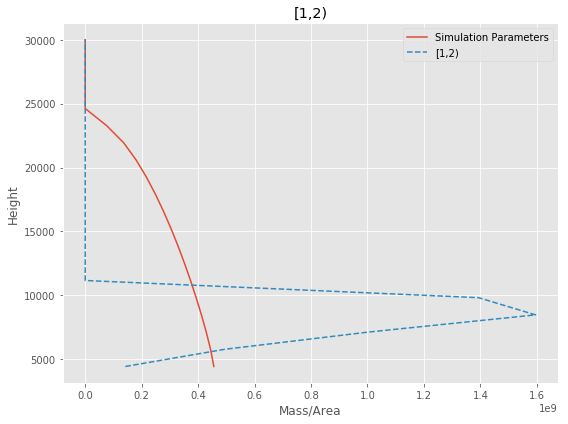

[1,2) Run Time: 1.88255 minutes


2610270359.5739555
========[2,3)========
Run 0===========================================================================
1.563951427346007
a* = -0.29059	b* = 3.39847	            h1* = 1.17416	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74782	b = 30.91834	            h1 = 22023.72529	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 264
SSE: 0.9663375518319626


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.56395     1.74782
b     1.5062     30.9183
ftt    6,000       6,000
h1  10,665.8    22,023.7
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.087 minutes


Estimated remaining run time: 1.663 minutes


Run 1===========================================================================
1.8951040503907504
a* = -0.29059	b* = 3.39845	            h1* = 1.17412	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74782	b = 30.91783	            h1 = 22023.45091	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 228
SSE: 0.9663375518319677


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     1.8951     1.74782
b    1.17387     30.9178
ftt    6,000       6,000
h1  23,625.4    22,023.5
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.074 minutes


Estimated remaining run time: 1.341 minutes


Run 2===========================================================================
5.379419491610848
a* = -0.29060	b* = 3.39846	            h1* = 1.17415	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74781	b = 30.91808	            h1 = 22023.62755	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 160
SSE: 0.9663375518319637


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    5.37942     1.74781
b    4.00937     30.9181
ftt    6,000       6,000
h1  18,377.7    22,023.6
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.052 minutes


Estimated remaining run time: 0.881 minutes


Run 3===========================================================================
1.2753200410099816
a* = 2.89371	b* = 0.60355	            h1* = -0.49914	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 19.06015	b = 2.82860	            h1 = 5777.03657	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 341
SSE: 0.9663602683759621


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.27532     19.0601
b    1.57696      2.8286
ftt    6,000       6,000
h1  19,791.4    5,777.04
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.109 minutes


Estimated remaining run time: 1.738 minutes


Run 4===========================================================================
1.7536325093384604
a* = 2.00212	b* = -1.02184	            h1* = -0.49920	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 8.40473	b = 1.35993	            h1 = 5776.50001	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 331
SSE: 0.9663740287898771


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.75363     8.40473
b    1.62137     1.35993
ftt    6,000       6,000
h1  24,021.3     5,776.5
u        5.6         5.6
v        8.2         8.2

Run 4 Time: 0.109 minutes


Estimated remaining run time: 1.633 minutes


Run 5===========================================================================
1.1542055066816634
a* = 0.43798	b* = -2.50584	            h1* = -0.49920	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.54957	b = 1.08161	            h1 = 5776.50000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 267
SSE: 0.966677886513243


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.15421     2.54957
b    1.47296     1.08161
ftt    6,000       6,000
h1  15,963.4     5,776.5
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.090 minutes


Estimated remaining run time: 1.265 minutes


Run 6===========================================================================
3.7645059258327547
a* = 2.44481	b* = 0.14072	            h1* = -0.49917	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 12.52837	b = 2.15110	            h1 = 5776.77383	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 335
SSE: 0.966362068496322


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.76451     12.5284
b    1.55324      2.1511
ftt    6,000       6,000
h1  28,044.1    5,776.77
u        5.6         5.6
v        8.2         8.2

Run 6 Time: 0.108 minutes


Estimated remaining run time: 1.398 minutes


Run 7===========================================================================
1.9174612096784864
a* = -0.29058	b* = 3.39846	            h1* = 1.17413	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74783	b = 30.91804	            h1 = 22023.49345	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 188
SSE: 0.9663375518319686


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.91746     1.74783
b    4.22745      30.918
ftt    6,000       6,000
h1  21,145.7    22,023.5
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.061 minutes


Estimated remaining run time: 0.728 minutes


Run 8===========================================================================
1.720773503746535
a* = 21.21448	b* = -21.93470	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1634307445.42298	b = 1.00000	            h1 = 4430.75058	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 305
SSE: 0.9670156838757771


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.72077 1.63431e+09
b    1.43532           1
ftt    6,000       6,000
h1  22,132.6    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.109 minutes


Estimated remaining run time: 1.200 minutes


Run 9===========================================================================
1.6742787479960515
a* = 2.64260	b* = 0.06441	            h1* = -0.49920	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 15.04965	b = 2.06653	            h1 = 5776.52713	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 340
SSE: 0.9663617270242902


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.67428     15.0496
b    1.55089     2.06653
ftt    6,000       6,000
h1  23,518.6    5,776.53
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.109 minutes


Estimated remaining run time: 1.086 minutes


Run 10===========================================================================
1.18024541294391
a* = 1.90155	b* = -1.36246	            h1* = -0.49920	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 7.69628	b = 1.25603	            h1 = 5776.50000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 335
SSE: 0.9663823452575269


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.18025     7.69628
b     1.4948     1.25603
ftt    6,000       6,000
h1  23,312.3     5,776.5
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.108 minutes


Estimated remaining run time: 0.968 minutes


Run 11===========================================================================
1.829794197716103
a* = -0.29055	b* = 3.39849	            h1* = 1.17419	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74785	b = 30.91894	            h1 = 22023.90105	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 216
SSE: 0.9663375518319675


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.82979     1.74785
b    4.27569     30.9189
ftt    6,000       6,000
h1  18,173.7    22,023.9
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.066 minutes


Estimated remaining run time: 0.531 minutes


Run 12===========================================================================
1.055136771838298
a* = 15.73715	b* = -1.00566	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 6832171.71946	b = 1.36580	            h1 = 4430.75181	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 318
SSE: 0.9669379760938188


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.05514 6.83217e+06
b     1.7329      1.3658
ftt    6,000       6,000
h1  18,684.8    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.111 minutes


Estimated remaining run time: 0.777 minutes


Run 13===========================================================================
12.974228091768635
a* = 28.19675	b* = -3.34640	            h1* = 0.51875	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1760733857690.69604	b = 1.03521	            h1 = 16542.50000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 198
SSE: 200348345.17886144


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    12.9742 1.76073e+12
b    1.27703     1.03521
ftt    6,000       6,000
h1  20,873.6    16,542.5
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.076 minutes


Estimated remaining run time: 0.456 minutes


Run 14===========================================================================
1.2093534410242928
a* = 3.17855	b* = 1.91320	            h1* = -0.48928	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 25.01191	b = 7.77475	            h1 = 5871.20381	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 341
SSE: 0.9663593074924474


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.20935     25.0119
b    2.64735     7.77475
ftt    6,000       6,000
h1  20,511.1     5,871.2
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.107 minutes


Estimated remaining run time: 0.533 minutes


Run 15===========================================================================
2.109945787845326
a* = -0.29055	b* = 3.39848	            h1* = 1.17416	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74785	b = 30.91855	            h1 = 22023.70774	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 231
SSE: 0.966337551831967


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.10995     1.74785
b     1.6075     30.9186
ftt    6,000       6,000
h1  22,213.4    22,023.7
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.073 minutes


Estimated remaining run time: 0.292 minutes


Run 16===========================================================================
1.4532817119293184
a* = 2.57038	b* = 0.04406	            h1* = -0.49919	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 14.07080	b = 2.04505	            h1 = 5776.54154	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 345
SSE: 0.96636198267544


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.45328     14.0708
b    1.97058     2.04505
ftt    6,000       6,000
h1  14,308.7    5,776.54
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.107 minutes


Estimated remaining run time: 0.321 minutes


Run 17===========================================================================
3.4797708031305445
a* = 2.90980	b* = 0.69523	            h1* = -0.49910	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 19.35316	b = 3.00416	            h1 = 5777.46104	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 340
SSE: 0.9663601519250473


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.47977     19.3532
b    1.68316     3.00416
ftt    6,000       6,000
h1  17,926.6    5,777.46
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.109 minutes


Estimated remaining run time: 0.218 minutes


Run 18===========================================================================
1.6723883882530903
a* = -0.29058	b* = 3.39849	            h1* = 1.17420	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74783	b = 30.91888	            h1 = 22023.99792	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 182
SSE: 0.9663375518319643


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.67239     1.74783
b    3.25634     30.9189
ftt    6,000       6,000
h1  9,644.63      22,024
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.057 minutes


Estimated remaining run time: 0.057 minutes


Run 19===========================================================================
4.183839442367729
a* = -0.29058	b* = 3.39848	            h1* = 1.17419	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.74783	b = 30.91872	            h1 = 22023.86622	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 202
SSE: 0.9663375518319716


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.18384     1.74783
b     3.2107     30.9187
ftt    6,000       6,000
h1  19,326.2    22,023.9
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.066 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.78776 minutes


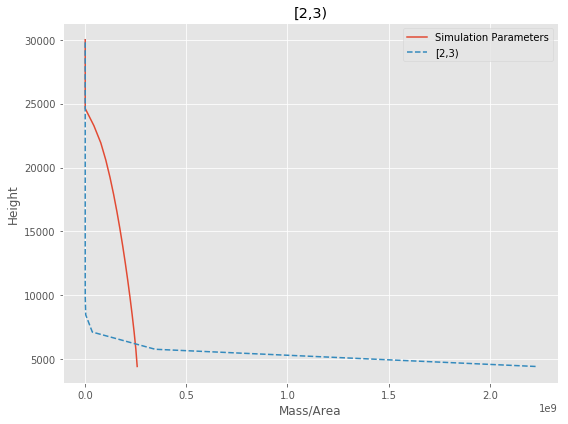

[2,3) Run Time: 1.78984 minutes


1237293118.1540995
========[3,4)========
Run 0===========================================================================
1.5132162506420757
a* = -5.83849	b* = 8.56019	            h1* = 0.19809	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.00291	b = 5220.67167	            h1 = 13208.99125	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 200
SSE: 130.2547850305995


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.51322     1.00291
b    1.39322    5,220.67
ftt    6,000       6,000
h1  19,856.4      13,209
u        5.6         5.6
v        8.2         8.2

Run 0 Time: 0.068 minutes


Estimated remaining run time: 1.296 minutes


Run 1===========================================================================
2.0284187630647112
a* = -0.03951	b* = 0.08593	            h1* = -0.49920	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.96126	b = 2.08973	            h1 = 5776.48467	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 108
SSE: 130.25940816484584


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.02842     1.96126
b    1.86971     2.08973
ftt    6,000       6,000
h1  17,691.6    5,776.48
u        5.6         5.6
v        8.2         8.2

Run 1 Time: 0.038 minutes


Estimated remaining run time: 0.689 minutes


Run 2===========================================================================
1.775197061942762
a* = -2.09762	b* = 8.99015	            h1* = 0.69965	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.12275	b = 8024.65076	            h1 = 18254.98477	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 220
SSE: 130.25428614313086


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     1.7752     1.12275
b    1.46494    8,024.65
ftt    6,000       6,000
h1  28,864.3      18,255
u        5.6         5.6
v        8.2         8.2

Run 2 Time: 0.075 minutes


Estimated remaining run time: 1.279 minutes


Run 3===========================================================================
1.1791844951587394
a* = -1.13913	b* = 8.72487	            h1* = 0.35335	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.32010	b = 6155.10555	            h1 = 14862.88577	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 199
SSE: 130.2542792510528


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.17918      1.3201
b    4.65632    6,155.11
ftt    6,000       6,000
h1  25,543.2    14,862.9
u        5.6         5.6
v        8.2         8.2

Run 3 Time: 0.070 minutes


Estimated remaining run time: 1.113 minutes


Run 4===========================================================================
1.7338487098066677
a* = 11.44616	b* = 12.82971	            h1* = -0.17564	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 93542.21258	b = 373141.09080	            h1 = 9108.36047	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 210
SSE: 130.25427488285462


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.73385    93,542.2
b   8.79459     373,141
ftt   6,000       6,000
h1   16,482    9,108.36
u       5.6         5.6
v       8.2         8.2

Run 4 Time: 0.079 minutes


Estimated remaining run time: 1.191 minutes


Run 5===========================================================================
2.6262154663789774
a* = 34.49775	b* = -23.47856	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 959799358766010.25000	b = 1.00000	            h1 = 4430.75000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 321
SSE: 130.2542749663192


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.62622 9.59799e+14
b    2.71015           1
ftt    6,000       6,000
h1  16,530.3    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 5 Time: 0.110 minutes


Estimated remaining run time: 1.546 minutes


Run 6===========================================================================
1.808927763045745
a* = 4.50421	b* = 8.15213	            h1* = -0.25268	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 91.39733	b = 3471.77848	            h1 = 8278.99649	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 266
SSE: 130.25427490196748


Priors  Posteriors
D     4,000       4,000
M   5.5e+10     5.5e+10
a   1.80893     91.3973
b   2.14194    3,471.78
ftt   6,000       6,000
h1   19,168       8,279
u       5.6         5.6
v       8.2         8.2

Run 6 Time: 0.091 minutes


Estimated remaining run time: 1.178 minutes


Run 7===========================================================================
1.5638655059698587
a* = 14.45809	b* = 0.52453	            h1* = -0.64841	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1901375.78797	b = 2.68966	            h1 = 4431.28990	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 311
SSE: 130.25427488444015


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.56387 1.90138e+06
b    2.04344     2.68966
ftt    6,000       6,000
h1  21,478.3    4,431.29
u        5.6         5.6
v        8.2         8.2

Run 7 Time: 0.106 minutes


Estimated remaining run time: 1.272 minutes


Run 8===========================================================================
1.2737826492053679
a* = 27.77713	b* = -4.56494	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1157323613472.52368	b = 1.01041	            h1 = 4430.75000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 250
SSE: 130.25427488285487


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.27378 1.15732e+12
b    1.63592     1.01041
ftt    6,000       6,000
h1  18,527.8    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 8 Time: 0.090 minutes


Estimated remaining run time: 0.991 minutes


Run 9===========================================================================
1.247477900843971
a* = 19.91090	b* = 5.25103	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 443808107.96464	b = 191.76300	            h1 = 4430.75075	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 164
SSE: 130.2542748828545


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.24748 4.43808e+08
b    2.92954     191.763
ftt    6,000       6,000
h1  14,565.7    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 9 Time: 0.063 minutes


Estimated remaining run time: 0.628 minutes


Run 10===========================================================================
2.2316631925470602
a* = -3.09115	b* = 8.37834	            h1* = 0.05475	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.04545	b = 4352.77805	            h1 = 11640.34006	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 199
SSE: 130.25431075260502


c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.23166     1.04545
b    1.26907    4,352.78
ftt    6,000       6,000
h1  18,935.1    11,640.3
u        5.6         5.6
v        8.2         8.2

Run 10 Time: 0.071 minutes


Estimated remaining run time: 0.640 minutes


Run 11===========================================================================
1.4545775899708895
a* = 12.21849	b* = 14.80049	            h1* = 1.41758	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 202499.40902	b = 2677756.50797	            h1 = 23544.62747	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 137
SSE: 130.25427488285447


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.45458     202,499
b    1.32859 2.67776e+06
ftt    6,000       6,000
h1  24,574.6    23,544.6
u        5.6         5.6
v        8.2         8.2

Run 11 Time: 0.055 minutes


Estimated remaining run time: 0.438 minutes


Run 12===========================================================================
2.2771057258273464
a* = -2.10916	b* = 8.11210	            h1* = -0.11189	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.12134	b = 3335.58329	            h1 = 9804.16115	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 151
SSE: 130.2542908226622


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.27711     1.12134
b    2.95712    3,335.58
ftt    6,000       6,000
h1  26,557.4    9,804.16
u        5.6         5.6
v        8.2         8.2

Run 12 Time: 0.052 minutes


Estimated remaining run time: 0.366 minutes


Run 13===========================================================================
2.3553471495568803
a* = 1.79729	b* = 8.71952	            h1* = 0.30597	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 7.03327	b = 6122.25366	            h1 = 14364.95332	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 197
SSE: 130.25427510843394


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.35535     7.03327
b    3.53617    6,122.25
ftt    6,000       6,000
h1  16,754.1      14,365
u        5.6         5.6
v        8.2         8.2

Run 13 Time: 0.067 minutes


Estimated remaining run time: 0.400 minutes


Run 14===========================================================================
9.179581246452916
a* = 30.38600	b* = -2.40481	            h1* = 3.08139	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 15720649642042.14258	b = 1.09028	            h1 = 28654.25000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 239
SSE: 11391544835.279112


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    9.17958 1.57206e+13
b    2.07749     1.09028
ftt    6,000       6,000
h1  22,069.2    28,654.3
u        5.6         5.6
v        8.2         8.2

Run 14 Time: 0.086 minutes


Estimated remaining run time: 0.431 minutes


Run 15===========================================================================
1.169916146084679
a* = 11.63081	b* = 13.42907	            h1* = 0.06635	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 112512.09901	b = 679475.42084	            h1 = 11768.12668	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 96
SSE: 130.25427488285453


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.16992     112,512
b    3.40212     679,475
ftt    6,000       6,000
h1  17,700.5    11,768.1
u        5.6         5.6
v        8.2         8.2

Run 15 Time: 0.039 minutes


Estimated remaining run time: 0.157 minutes


Run 16===========================================================================
1.1271427685081559
a* = 20.76445	b* = -0.10909	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1042047266.34754	b = 1.89665	            h1 = 4430.75095	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 315
SSE: 130.2542748828599


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.12714 1.04205e+09
b    1.86311     1.89665
ftt    6,000       6,000
h1  15,467.9    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 16 Time: 0.105 minutes


Estimated remaining run time: 0.316 minutes


Run 17===========================================================================
1.480619733320325
a* = -4.51941	b* = 8.25558	            h1* = -0.02715	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.01090	b = 3850.03891	            h1 = 10736.81352	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 213
SSE: 130.25443611986628


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.48062      1.0109
b    1.48711    3,850.04
ftt    6,000       6,000
h1  28,985.2    10,736.8
u        5.6         5.6
v        8.2         8.2

Run 17 Time: 0.077 minutes


Estimated remaining run time: 0.153 minutes


Run 18===========================================================================
4.958169496562483
a* = 25.64189	b* = -2.26298	            h1* = -0.64848	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 136813595388.06358	b = 1.10404	            h1 = 4430.75000	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 236
SSE: 130.2542748828548


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    4.95817 1.36814e+11
b    1.28911     1.10404
ftt    6,000       6,000
h1  24,250.3    4,430.75
u        5.6         5.6
v        8.2         8.2

Run 18 Time: 0.084 minutes


Estimated remaining run time: 0.084 minutes


Run 19===========================================================================
2.7484848309159813
a* = 14.47411	b* = -7.37142	            h1* = -0.64842	u* = 5.60000	v* = 8.20000	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1932077.58222	b = 1.00063	            h1 = 4431.26952	u = 5.60000	v = 8.20000	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 314
SSE: 130.25427907490084


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.74848 1.93208e+06
b    2.26957     1.00063
ftt    6,000       6,000
h1  25,221.2    4,431.27
u        5.6         5.6
v        8.2         8.2

Run 19 Time: 0.105 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.53255 minutes


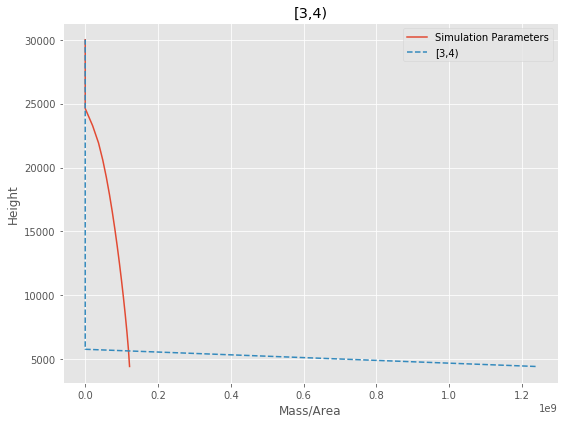

[3,4) Run Time: 1.53490 minutes


Total Run Time: 12.60391 minutes


In [17]:
data = obs_df

H = 30000

wind_angle = np.radians(55.5)

t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = data.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    print(mass_in_phi)
    
    print("========%s========"%phi_step["interval"])
    
#     out = gaussian_stack_inversion(
#         phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
#         H, 2500, [phi_step],
#         invert_params=invert_params,
#         priors=priors_vals,
#         column_cap=H)
#     inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    
    out = gaussian_stack_multi_run(
        phi_df, len(data), 20, 
        config["VENT_ELEVATION"], 
        H, 2500, [phi_step], 
        param_config, runs=20, column_cap=H
    )
    
    masses_list, sse_list, params_runs, priors_list, heights = out
    
    best = np.argsort(sse_list)
    
    params = params_runs[best[0]]
    

    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                                config["VENT_ELEVATION"], 
                                params["h1"], 
                                heights,
                                mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]

     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                heights,
                                mass_in_phi)

    ax1.plot(q_mass, heights, label="Simulation Parameters")
    
    ax1.plot(inv_mass, heights, 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

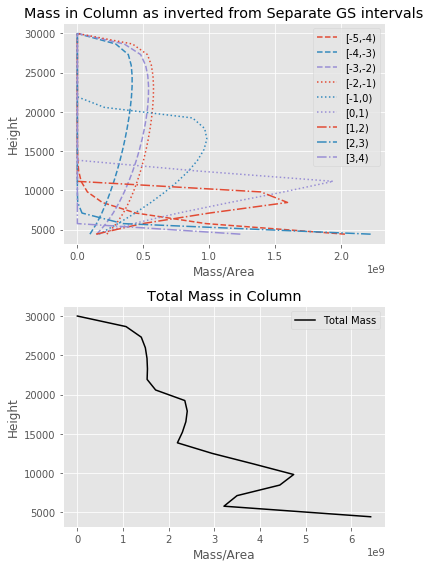

In [18]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            heights,
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]

# ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         heights, 
         linestyles[i], label=phi_step["interval"])
    
ax2.plot(totmass, heights, "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

In [19]:
params_df = pd.DataFrame(params_list)

params_df["Phi"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Phi", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

Phi       a           b       h1   u   v     D   ftt       M
0  [-5,-4)  1.0369     13.8388   27,904 5.6 8.2 4,000 6,000 5.5e+10
1  [-4,-3) 1.62072     1.14231   28,819 5.6 8.2 4,000 6,000 5.5e+10
2  [-3,-2) 1.57501     1.17638   28,899 5.6 8.2 4,000 6,000 5.5e+10
3  [-2,-1) 1.41797     1.12347   28,836 5.6 8.2 4,000 6,000 5.5e+10
4   [-1,0)  1.9316     1.26156 20,583.8 5.6 8.2 4,000 6,000 5.5e+10
5    [0,1)  2.5171     1.08918 12,505.3 5.6 8.2 4,000 6,000 5.5e+10
6    [1,2) 2.83779     1.09379 9,817.77 5.6 8.2 4,000 6,000 5.5e+10
7    [2,3) 1.74782     30.9183 22,023.7 5.6 8.2 4,000 6,000 5.5e+10
8    [3,4) 202,499 2.67776e+06 23,544.6 5.6 8.2 4,000 6,000 5.5e+10

In [ ]:
param_config = {
    "a": {
        "value":[2, 1],
        "invert":True,
        "sample_function": lognorm
    },
    "b": {
        "value":[2, 1],
        "invert":True,
        "sample_function": lognorm
    },
    "h1": {
        "value":[20000, H],
        "invert":False,
        "sample_function": col_truncnorm
    },
    "u": {
        "value":[5],
        "invert":False,
        "sample_function": normal
    },
    "v": {
        "value":[6],
        "invert":False,
        "sample_function": normal
    },
    "D": {
        "value":[4000],
        "invert":False,
        "sample_function": lognorm
    },
    "ftt": {
        "value":[6000],
        "invert":False,
        "sample_function": lognorm
    },
    "M": {
        "value":[config["ERUPTION_MASS"]],
        "invert":False,
        "sample_function": lognorm
    }
}

3758564623.1204
========[-5,-4)========
Run 0===========================================================================
2.2575831986571613


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:433: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = 9.08716	b* = 7.01552	            h1* = -0.03571	u* = 3.03461	v* = 5.91189	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 8842.02765	b = 1114.78083	            h1 = 10642.32411	u = 3.03461	v = 5.91189	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 566
SSE: 4.49962309759261


Priors  Posteriors
D        4,000       4,000
M      5.5e+10     5.5e+10
a      2.25758    8,842.03
b      2.44319    1,114.78
ftt      6,000       6,000
h1    29,025.5    10,642.3
u   -0.0497526     3.03461
v      1.81941     5.91189

Run 0 Time: 0.189 minutes


Estimated remaining run time: 0.755 minutes


Run 1===========================================================================
3.4649627134508334


Priors  Posteriors
D       4,000       4,000
M     5.5e+10     5.5e+10
a     3.46496     130.619
b     2.14198     2.28682
ftt     6,000       6,000
h1   18,625.7    7,720.85
u   -0.113356     1.05517
v     4.78393     12.7599

Run 1 Time: 0.064 minutes


Estimated remaining run time: 0.191 minutes


Run 2===========================================================================
1.354777230223341


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.35478     1.04787
b    1.35634     1.58022
ftt    6,000       6,000
h1  19,791.3    24,621.9
u   -7.53014     5.73043
v   -6.43902     7.94669

Run 2 Time: 0.154 minutes


Estimated remaining run time: 0.309 minutes


Run 3===========================================================================
1.6206448478695759


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.62064     1.05716
b    1.52529     1.59794
ftt    6,000       6,000
h1  25,940.4    24,657.4
u    2.60472     5.72773
v    1.87609     7.93176

Run 3 Time: 0.201 minutes


Estimated remaining run time: 0.201 minutes


Run 4===========================================================================
1.2677635357531818


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.26776     1.00557
b    5.13308     1.46904
ftt    6,000       6,000
h1  19,662.3      23,827
u    10.1002     5.74103
v    4.09851     8.00393

Run 4 Time: 0.186 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.79401 minutes


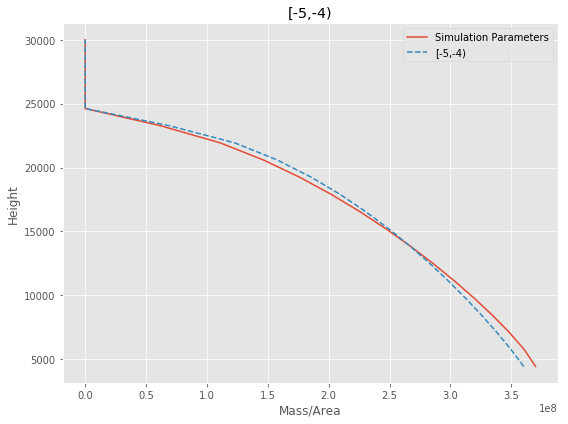

[-5,-4) Run Time: 0.79609 minutes


6006169166.091817
========[-4,-3)========
Run 0===========================================================================
1.516207977093369
a* = -3.73655	b* = -3.61603	            h1* = -0.36322	u* = 0.69933	v* = 14.15281	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.02384	b = 1.02689	            h1 = 7122.38003	u = 0.69933	v = 14.15281	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 619
SSE: 51.83783355552181


Priors  Posteriors
D       4,000       4,000
M     5.5e+10     5.5e+10
a     1.51621     1.02384
b      11.149     1.02689
ftt     6,000       6,000
h1   18,220.9    7,122.38
u   -0.743778    0.699335
v     3.55847     14.1528

Run 0 Time: 0.203 minutes


Estimated remaining run time: 0.810 minutes


Run 1===========================================================================
2.2678321488817987


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.26783     1.18506
b    3.29372     2.23871
ftt    6,000       6,000
h1  23,784.5    28,749.2
u   -1.60857     5.70085
v    6.23989     7.86575

Run 1 Time: 0.213 minutes


Estimated remaining run time: 0.640 minutes


Run 2===========================================================================
3.9500699869503277


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.95007     1.01356
b    1.77171     1.50761
ftt    6,000       6,000
h1  16,196.8    24,296.7
u   -6.74652     5.72566
v    3.84284     8.00857

Run 2 Time: 0.209 minutes


Estimated remaining run time: 0.418 minutes


Run 3===========================================================================
3.772898259163022


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     3.7729     1.02021
b    1.52899     1.53978
ftt    6,000       6,000
h1  20,551.7    24,609.2
u    2.19385     5.72392
v    1.59295     8.00169

Run 3 Time: 0.207 minutes


Estimated remaining run time: 0.207 minutes


Run 4===========================================================================
1.2577521762683954


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.25775     1.03983
b    2.17881     1.59679
ftt    6,000       6,000
h1  29,149.7    24,801.9
u   -5.01862      5.7137
v     3.4272     7.97211

Run 4 Time: 0.198 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 1.03073 minutes


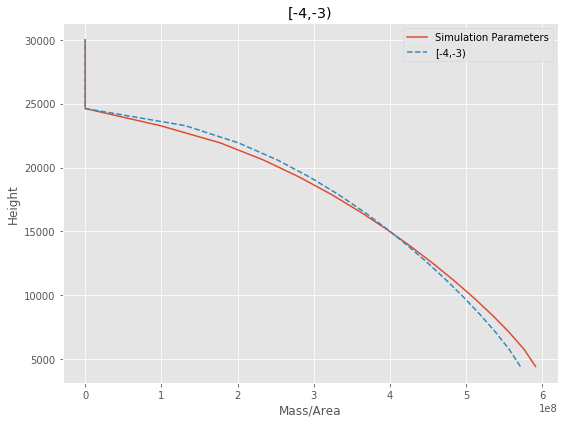

[-4,-3) Run Time: 1.03333 minutes


8068164622.312117
========[-3,-2)========
Run 0===========================================================================
1.5582365518445707
a* = -5.30715	b* = -0.56731	            h1* = 1.67636	u* = 5.70682	v* = 8.05271	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.00496	b = 1.56705	            h1 = 24881.97167	u = 5.70682	v = 8.05271	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 635
SSE: 0.006081099406956805


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.55824     1.00496
b    2.06665     1.56705
ftt    6,000       6,000
h1  22,348.4      24,882
u    5.16211     5.70682
v    2.97213     8.05271

Run 0 Time: 0.212 minutes


Estimated remaining run time: 0.849 minutes


Run 1===========================================================================
3.192839284711191


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.19284     1.25228
b    1.79412      1.0656
ftt    6,000       6,000
h1  20,363.4    17,744.8
u   -2.17267     5.92926
v   -13.1778     8.67158

Run 1 Time: 0.120 minutes


Estimated remaining run time: 0.359 minutes


Run 2===========================================================================
1.799240278159164


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.79924     1.08765
b    1.77818     1.98738
ftt    6,000       6,000
h1  20,217.7    27,805.6
u   -2.05065     5.70625
v   -3.93764     8.04258

Run 2 Time: 0.210 minutes


Estimated remaining run time: 0.420 minutes


Run 3===========================================================================
3.556207687068341


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.55621     1.01598
b    3.34589     1.10049
ftt    6,000       6,000
h1  19,846.8    20,567.7
u   0.450036     5.73879
v    4.20165     8.12921

Run 3 Time: 0.201 minutes


Estimated remaining run time: 0.201 minutes


Run 4===========================================================================
1.9681775527462242


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.96818      1.0835
b    1.26926     2.03615
ftt    6,000       6,000
h1  17,969.9    28,311.7
u   -1.99155     5.71155
v    1.67677     8.05671

Run 4 Time: 0.207 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.95052 minutes


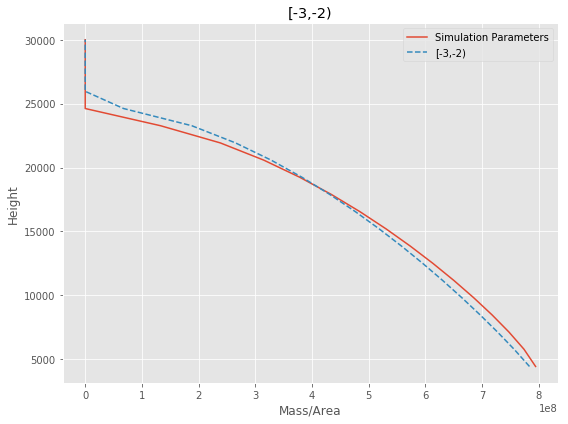

[-3,-2) Run Time: 0.95417 minutes


9110738766.610346
========[-2,-1)========
Run 0===========================================================================
9.196400472391812
a* = 8.37156	b* = -1.98549	            h1* = 0.13412	u* = 4.37260	v* = 5.50303	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 4323.38387	b = 1.13731	            h1 = 12512.32395	u = 4.37260	v = 5.50303	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 214
SSE: 48.76282302800564


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     9.1964    4,323.38
b    1.27928     1.13731
ftt    6,000       6,000
h1  18,931.7    12,512.3
u   0.583656      4.3726
v   -5.60928     5.50303

Run 0 Time: 0.074 minutes


Estimated remaining run time: 0.298 minutes


Run 1===========================================================================
1.1978447480718617


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.19784     1.02241
b    2.11729      1.6389
ftt    6,000       6,000
h1  17,258.5    25,169.8
u    5.30319     5.70803
v   -2.37104     8.10861

Run 1 Time: 0.202 minutes


Estimated remaining run time: 0.606 minutes


Run 2===========================================================================
3.179267292343307


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.17927     1.01154
b    2.02615     1.59179
ftt    6,000       6,000
h1  17,674.8    24,836.2
u    -7.8341     5.71419
v    4.03741     8.11878

Run 2 Time: 0.212 minutes


Estimated remaining run time: 0.424 minutes


Run 3===========================================================================
1.6784895890853757


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.67849     1.01762
b    5.22386     1.23045
ftt    6,000       6,000
h1  18,354.5    20,836.4
u   -6.38514     5.69228
v    -6.4825     7.95707

Run 3 Time: 0.181 minutes


Estimated remaining run time: 0.181 minutes


Run 4===========================================================================
3.0375531100244686


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.03755     1.00629
b    1.34633     1.59102
ftt    6,000       6,000
h1  16,939.2    24,920.1
u    1.91954     5.71415
v    6.18945     8.12502

Run 4 Time: 0.202 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.87109 minutes


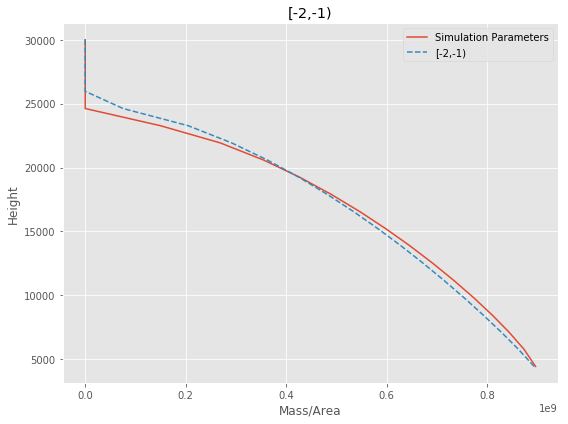

[-2,-1) Run Time: 0.87344 minutes


8648366582.16272
========[-1,0)========
Run 0===========================================================================
3.753924001452959
a* = -4.46342	b* = -0.41327	            h1* = 1.71496	u* = 5.70709	v* = 8.16272	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.01152	b = 1.66148	            h1 = 25058.82853	u = 5.70709	v = 8.16272	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 509
SSE: 0.08429976168909324


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.75392     1.01152
b    2.71141     1.66148
ftt    6,000       6,000
h1  22,677.7    25,058.8
u   -2.15851     5.70709
v     4.7492     8.16272

Run 0 Time: 0.159 minutes


Estimated remaining run time: 0.637 minutes


Run 1===========================================================================
2.858152123891438


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.85815     1.00367
b    2.58044     1.11202
ftt    6,000       6,000
h1  23,454.8    20,550.6
u   0.323784     5.71701
v   -5.47478      7.6628

Run 1 Time: 0.205 minutes


Estimated remaining run time: 0.616 minutes


Run 2===========================================================================
3.4035149015997606


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.40351     27.0394
b    1.53855      1.1429
ftt    6,000       6,000
h1  20,818.4    11,159.5
u   -2.86391     4.27081
v   -2.17761     4.51534

Run 2 Time: 0.161 minutes


Estimated remaining run time: 0.323 minutes


Run 3===========================================================================
6.6193139008407815


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    6.61931     1.00716
b      2.229     1.64656
ftt    6,000       6,000
h1  20,807.3      24,997
u    2.07641     5.70345
v    6.65078     8.15855

Run 3 Time: 0.196 minutes


Estimated remaining run time: 0.196 minutes


Run 4===========================================================================
3.5318257111035956


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.53183     1.00716
b    2.00123     1.64654
ftt    6,000       6,000
h1  20,777.1    24,996.7
u    3.68757     5.70353
v    6.20624     8.15856

Run 4 Time: 0.196 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.91745 minutes


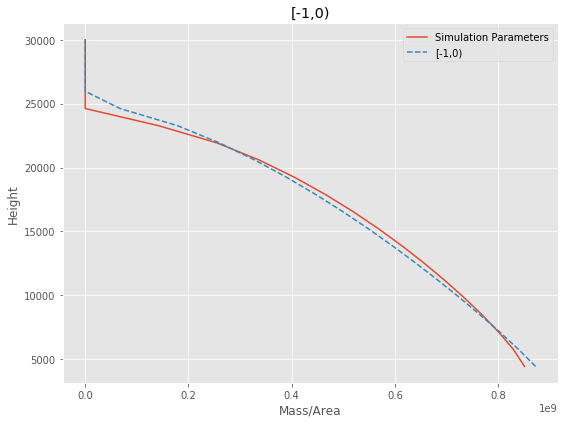

[-1,0) Run Time: 0.92005 minutes


6901066909.641724
========[0,1)========
Run 0===========================================================================
9.778799233093315
a* = -5.12865	b* = -0.28553	            h1* = 2.24729	u* = 5.50241	v* = 7.53310	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.00592	b = 1.75162	            h1 = 26991.23277	u = 5.50241	v = 7.53310	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 642
SSE: 0.15377896884528225


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     9.7788     1.00592
b    1.13469     1.75162
ftt    6,000       6,000
h1  16,793.1    26,991.2
u    7.83559     5.50241
v   -3.40255      7.5331

Run 0 Time: 0.205 minutes


Estimated remaining run time: 0.821 minutes


Run 1===========================================================================
1.278597349002184


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     1.2786     1.00888
b    2.57933     1.87616
ftt    6,000       6,000
h1  28,552.8    28,203.3
u   -6.80799     5.51138
v   -3.29274     7.59004

Run 1 Time: 0.151 minutes


Estimated remaining run time: 0.453 minutes


Run 2===========================================================================
13.941828218842357


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    13.9418     1.00017
b    2.67634     326.573
ftt    6,000       6,000
h1  6,418.21     4,583.4
u   -12.2496     1.46956
v    10.4195    -2.44753

Run 2 Time: 0.204 minutes


Estimated remaining run time: 0.408 minutes


Run 3===========================================================================
2.2663128337727096


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.26631     1.05078
b      1.519     1.01252
ftt    6,000       6,000
h1  28,767.4    19,715.3
u   -2.18753     5.29893
v   -6.02867     6.41666

Run 3 Time: 0.203 minutes


Estimated remaining run time: 0.203 minutes


Run 4===========================================================================
2.239784659194935


Priors  Posteriors
D       4,000       4,000
M     5.5e+10     5.5e+10
a     2.23978     1.00888
b     1.66182     1.87617
ftt     6,000       6,000
h1     16,834    28,203.4
u   -0.956459     5.51139
v       3.102     7.59005

Run 4 Time: 0.184 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.94818 minutes


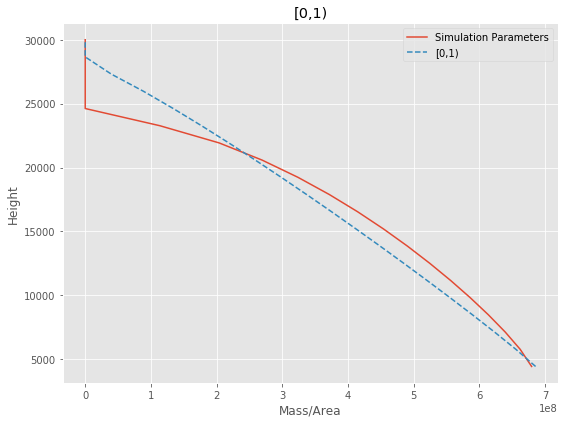

[0,1) Run Time: 0.95052 minutes


4629137051.124315
========[1,2)========
Run 0===========================================================================
1.947696452173933
a* = 0.22475	b* = 0.50847	            h1* = -0.59700	u* = 15.94721	v* = -4.86903	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 2.25201	b = 2.66275	            h1 = 4877.04696	u = 15.94721	v = -4.86903	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 349
SSE: 55.079359927829344


Priors  Posteriors
D       4,000       4,000
M     5.5e+10     5.5e+10
a      1.9477     2.25201
b     1.78485     2.66275
ftt     6,000       6,000
h1   5,089.19    4,877.05
u   -0.526861     15.9472
v     5.37236    -4.86903

Run 0 Time: 0.110 minutes


Estimated remaining run time: 0.439 minutes


Run 1===========================================================================
2.532998220298486


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a      2.533      1.2224
b     2.0432     2.35012
ftt    6,000       6,000
h1  29,875.3    29,752.9
u   -10.2115     5.35145
v    -2.3644      6.7679

Run 1 Time: 0.164 minutes


Estimated remaining run time: 0.491 minutes


Run 2===========================================================================
1.6927583011676952


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.69276     2.47183
b    2.94181     3.73553
ftt    6,000       6,000
h1  25,498.6    26,872.9
u   -2.98135     4.47687
v   0.563022     3.88906

Run 2 Time: 0.198 minutes


Estimated remaining run time: 0.397 minutes


Run 3===========================================================================
2.755593910715377


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.75559     1.07482
b    1.74771     1.27316
ftt    6,000       6,000
h1  28,565.1    21,563.8
u   -2.20088     5.34811
v    4.73486     6.86272

Run 3 Time: 0.121 minutes


Estimated remaining run time: 0.121 minutes


Run 4===========================================================================
3.070229283049837


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.07023     1.72903
b    1.18238     1.04814
ftt    6,000       6,000
h1  26,731.6    27,305.9
u     10.664     3.08096
v    5.24389     2.41876

Run 4 Time: 0.145 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.73802 minutes


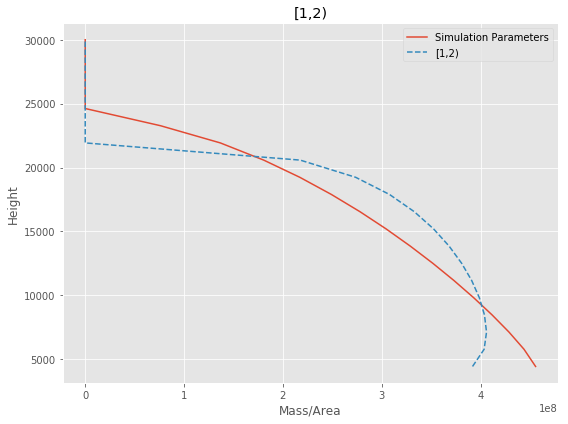

[1,2) Run Time: 0.74141 minutes


2610270359.5739555
========[2,3)========
Run 0===========================================================================
2.9472119331391613
a* = -0.72528	b* = -1.01759	            h1* = 0.38546	u* = 5.56913	v* = 6.39970	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.48419	b = 1.36147	            h1 = 15196.36957	u = 5.56913	v = 6.39970	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 626
SSE: 0.019159106354283938


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.94721     1.48419
b    1.40213     1.36147
ftt    6,000       6,000
h1  13,429.8    15,196.4
u    0.66999     5.56913
v    1.15268      6.3997

Run 0 Time: 0.204 minutes


Estimated remaining run time: 0.818 minutes


Run 1===========================================================================
1.1255167586028973


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.12552     1.06051
b    1.71532     1.71892
ftt    6,000       6,000
h1  29,228.3    25,871.5
u   -3.82239      5.5832
v   -1.71578     6.67623

Run 1 Time: 0.201 minutes


Estimated remaining run time: 0.604 minutes


Run 2===========================================================================
1.5637715927652036


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.56377     1.50577
b    2.46472     1.22171
ftt    6,000       6,000
h1  9,981.22      13,851
u    2.07922     5.71288
v    5.93154      6.3495

Run 2 Time: 0.092 minutes


Estimated remaining run time: 0.183 minutes


Run 3===========================================================================
1.356323596373517


Priors  Posteriors
D       4,000       4,000
M     5.5e+10     5.5e+10
a     1.35632     1.06644
b      1.2383     1.01066
ftt     6,000       6,000
h1   19,556.1    23,271.2
u   -0.661074     1.00927
v    -8.39558     10.5847

Run 3 Time: 0.183 minutes


Estimated remaining run time: 0.183 minutes


Run 4===========================================================================
3.3333331813194325


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    3.33333     1.08058
b     3.4094     1.44626
ftt    6,000       6,000
h1  26,328.4    22,003.9
u   -2.59371     5.58083
v    6.27878     6.65789

Run 4 Time: 0.186 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.86693 minutes


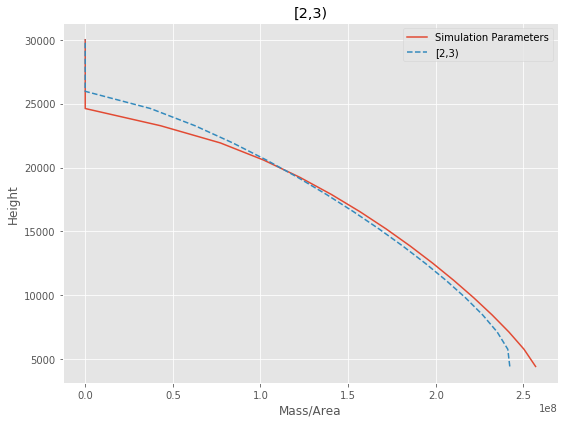

[2,3) Run Time: 0.86875 minutes


1237293118.1540995
========[3,4)========
Run 0===========================================================================
1.5012096220002433
a* = -4.03773	b* = 2.78245	            h1* = 1.40460	u* = 8.66515	v* = 5.04853	            D* = 8.29405	ftt* = 8.69951	TM* = 24.73060
a = 1.01764	b = 17.15855	            h1 = 23470.21820	u = 8.66515	v = 5.04853	            D = 4000.00000	ftt = 6000.00000	TM = 55000000000.00002
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 579
SSE: 0.00982651101246216


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.50121     1.01764
b    2.67274     17.1586
ftt    6,000       6,000
h1  16,015.9    23,470.2
u   -2.19867     8.66515
v   -1.16018     5.04853

Run 0 Time: 0.186 minutes


Estimated remaining run time: 0.745 minutes


Run 1===========================================================================
1.5567801617064787


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    1.55678      1.4026
b    3.98108     4.40811
ftt    6,000       6,000
h1  8,353.46    29,857.2
u   -11.3608     5.74438
v   -1.08132     6.68582

Run 1 Time: 0.190 minutes


Estimated remaining run time: 0.569 minutes


Run 2===========================================================================
1.8007010567051145


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a     1.8007     1.56222
b    1.52276     1.55262
ftt    6,000       6,000
h1  26,778.8    12,504.4
u    13.6642     5.76184
v    5.70121     6.81366

Run 2 Time: 0.118 minutes


Estimated remaining run time: 0.237 minutes


Run 3===========================================================================
2.654918837985721


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.65492      29.158
b    1.14515     150.948
ftt    6,000       6,000
h1  19,460.7    21,149.4
u   -2.29031       4.846
v   -1.24203     4.72503

Run 3 Time: 0.114 minutes


Estimated remaining run time: 0.114 minutes


Run 4===========================================================================
2.567088528971251


Priors  Posteriors
D      4,000       4,000
M    5.5e+10     5.5e+10
a    2.56709     1.90348
b    1.59781     1.18255
ftt    6,000       6,000
h1  17,685.5    9,813.75
u   -2.53535     5.70726
v    8.24403     6.84093

Run 4 Time: 0.199 minutes


Estimated remaining run time: 0.000 minutes


Total Run Time: 0.80703 minutes


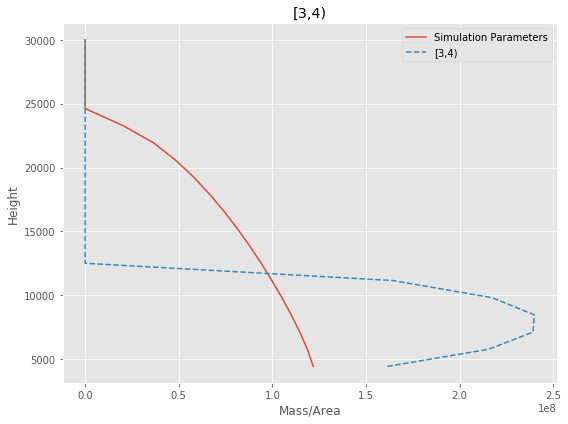

[3,4) Run Time: 0.80937 minutes


Total Run Time: 7.94740 minutes


In [17]:
data = forward_df

H = 30000

wind_angle = np.radians(55.5)

t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = data.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    print(mass_in_phi)
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_multi_run(
        phi_df, len(data), 20, 
        config["VENT_ELEVATION"], 
        H, 2500, [phi_step], 
        param_config, runs=5, column_cap=H
    )
    
    masses_list, sse_list, params_list, priors_list, heights = out
    
    best = np.argsort(sse_list)
    
    params = params_list[best[0]]
    

    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                                config["VENT_ELEVATION"], 
                                params["h1"], 
                                heights,
                                mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]

     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                heights,
                                mass_in_phi)

    ax1.plot(q_mass, heights, label="Simulation Parameters")
    
    ax1.plot(inv_mass, heights, 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

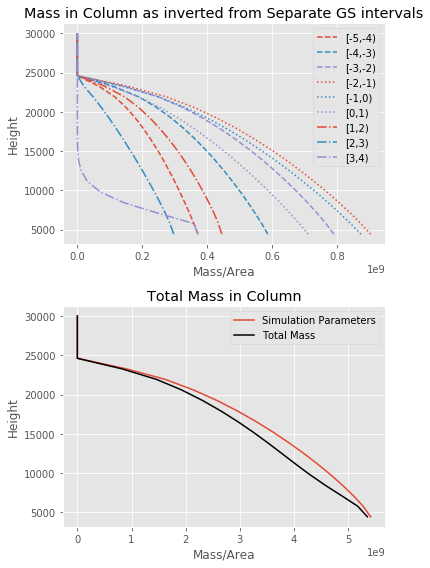

Dataset       a       b     h1       u       v     D   ftt       M
0  [-5,-4) 1.00314 1.52566 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
1  [-4,-3) 1.00568  1.5115 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
2  [-3,-2) 1.00904 1.52414 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
3  [-2,-1) 1.00711 1.53941 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
4   [-1,0) 1.00421 1.56202 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
5    [0,1) 1.00518 1.59679 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
6    [1,2) 1.01882 1.52046 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
7    [2,3) 1.02853  1.8407 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
8    [3,4) 1.99603 11.1447 24,000 5.66406 8.24126 4,016 6,458 5.5e+10

In [61]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]


totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])
ax2.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Dataset"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Dataset", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

Now, why is the column shape not preserved? We are assuming a well mixed plume, but that does not appear to be the case here, since each phi class inverts with a different phi. 


========[-5,-4)========
3758564623.1204


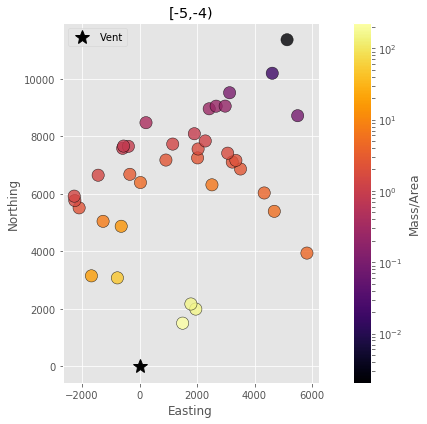

a* = -6.02852	b* = -0.68527	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.00241	b = 1.50395	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 88
SSE: 0.009313988182763914


Height  Suspended Mass
0  4,430.75     5.37943e+09
1   5,776.5     5.19838e+09
2  7,122.25     5.00613e+09
3     8,468     4.80415e+09
4  9,813.75     4.59213e+09
5  11,159.5     4.36909e+09
6  12,505.2     4.13353e+09
7    13,851     3.88337e+09
8  15,196.8     3.61574e+09
9  16,542.5     3.32658e+09
10 17,888.2     3.00983e+09
11   19,234     2.65583e+09
12 20,579.8     2.24733e+09
13 21,925.5     1.74708e+09
14 23,271.2     1.03139e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

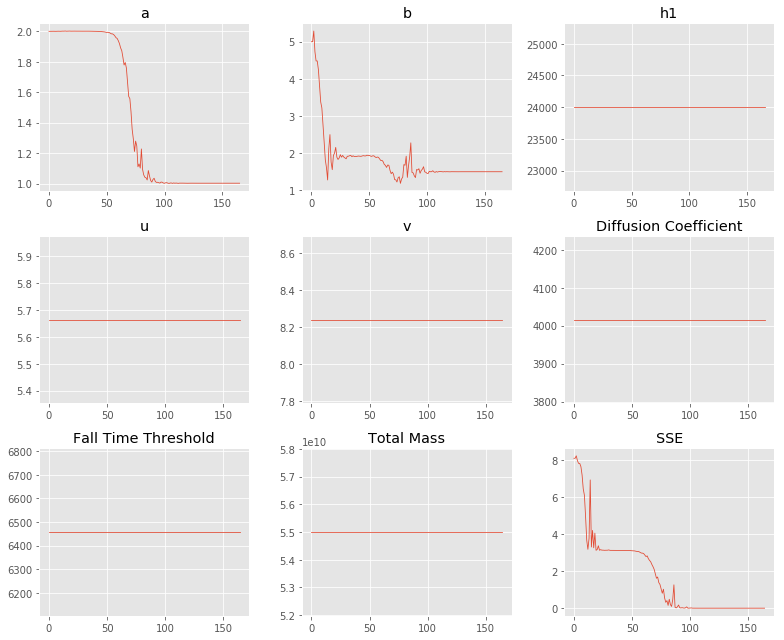

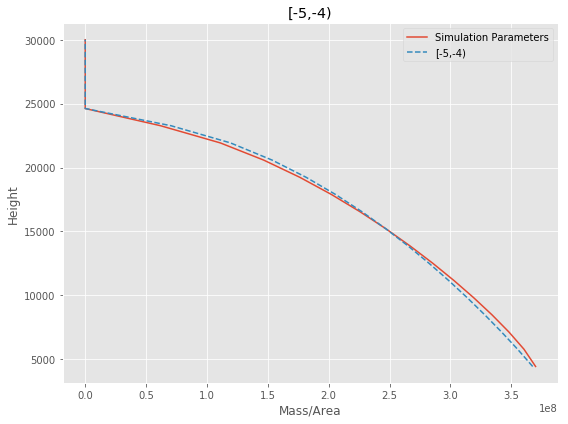

[-5,-4) Run Time: 0.05260 minutes


========[-4,-3)========
6006169166.091817


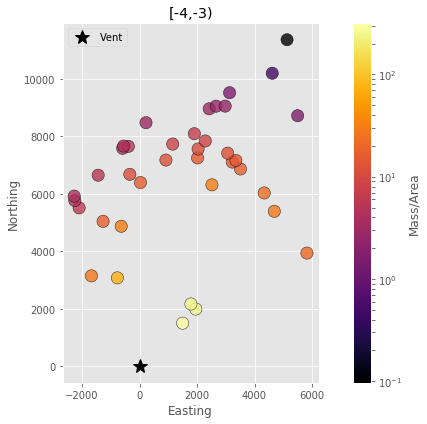

a* = -5.37964	b* = -0.69512	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.00461	b = 1.49901	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 93
SSE: 0.01883242813876549


Height  Suspended Mass
0  4,430.75     5.34334e+09
1   5,776.5      5.1732e+09
2  7,122.25     4.98822e+09
3     8,468     4.79196e+09
4  9,813.75     4.58478e+09
5  11,159.5       4.366e+09
6  12,505.2     4.13427e+09
7    13,851      3.8876e+09
8  15,196.8     3.62316e+09
9  16,542.5     3.33691e+09
10 17,888.2     3.02278e+09
11   19,234     2.67105e+09
12 20,579.8     2.26431e+09
13 21,925.5     1.76493e+09
14 23,271.2     1.04748e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

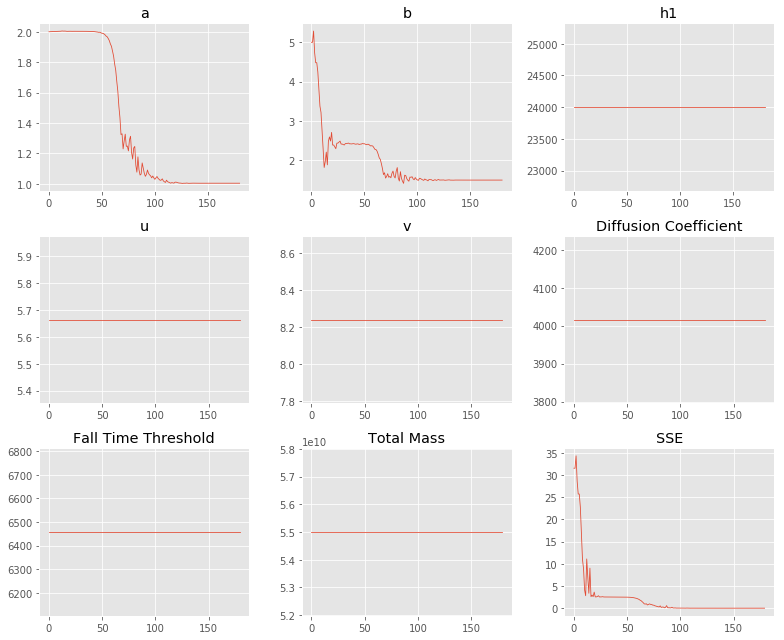

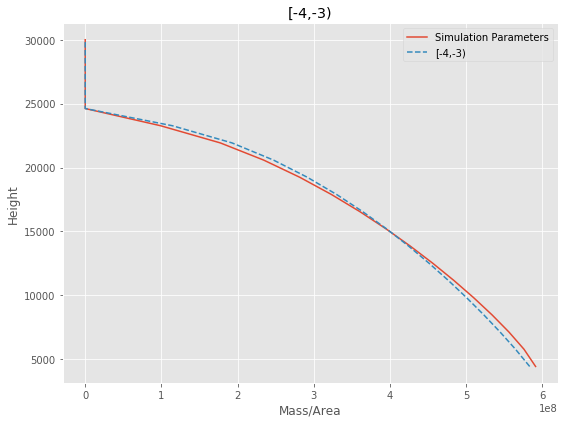

[-4,-3) Run Time: 0.05469 minutes


========[-3,-2)========
8068164622.312117


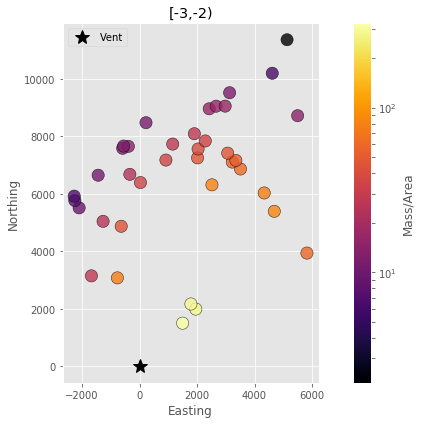

a* = -5.03303	b* = -0.66942	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.00652	b = 1.51201	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 92
SSE: 0.03675456314670423


Height  Suspended Mass
0  4,430.75     5.37082e+09
1   5,776.5     5.20188e+09
2  7,122.25     5.01475e+09
3     8,468      4.8149e+09
4  9,813.75     4.60327e+09
5  11,159.5     4.37946e+09
6  12,505.2     4.14227e+09
7    13,851     3.88981e+09
8  15,196.8     3.61935e+09
9  16,542.5     3.32689e+09
10 17,888.2     3.00647e+09
11   19,234      2.6485e+09
12 20,579.8     2.23588e+09
13 21,925.5     1.73172e+09
14 23,271.2     1.01403e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

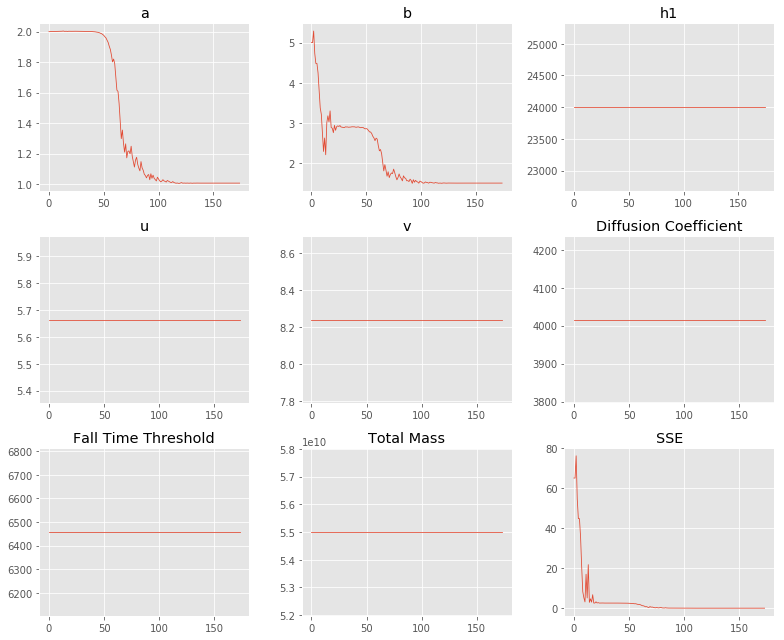

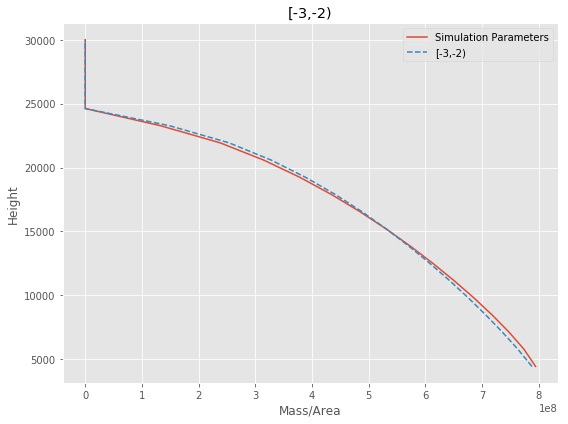

[-3,-2) Run Time: 0.05417 minutes


========[-2,-1)========
9110738766.610346


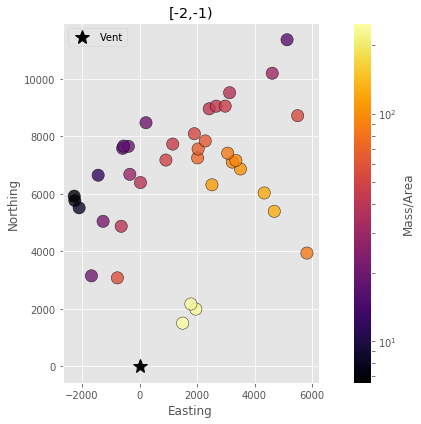

a* = -5.33114	b* = -0.64337	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.00484	b = 1.52552	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 95
SSE: 0.06898634081868443


Height  Suspended Mass
0  4,430.75     5.43148e+09
1   5,776.5     5.24945e+09
2  7,122.25     5.05193e+09
3     8,468     4.84281e+09
4  9,813.75     4.62256e+09
5  11,159.5     4.39054e+09
6  12,505.2     4.14547e+09
7    13,851     3.88541e+09
8  15,196.8     3.60759e+09
9  16,542.5     3.30807e+09
10 17,888.2     2.98096e+09
11   19,234     2.61684e+09
12 20,579.8     2.19898e+09
13 21,925.5     1.69147e+09
14 23,271.2     9.76444e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

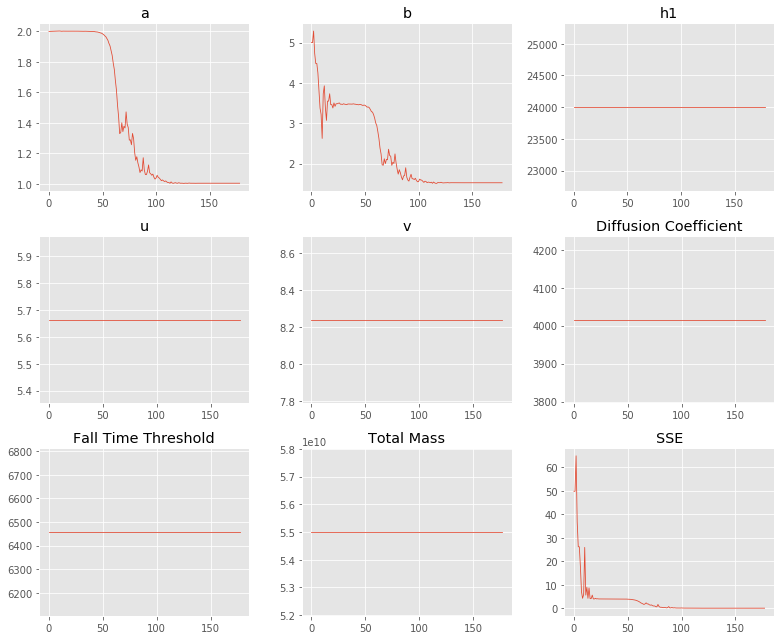

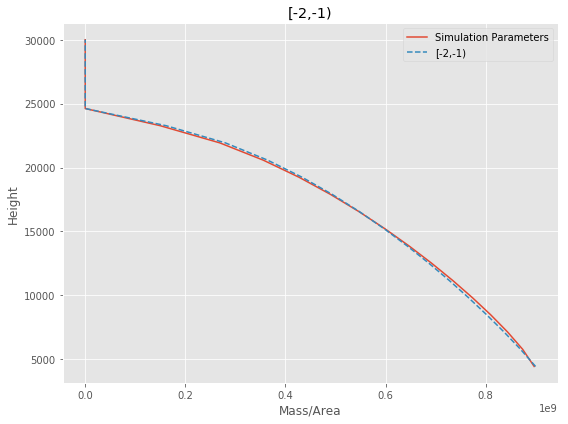

[-2,-1) Run Time: 0.05521 minutes


========[-1,0)========
8648366582.16272


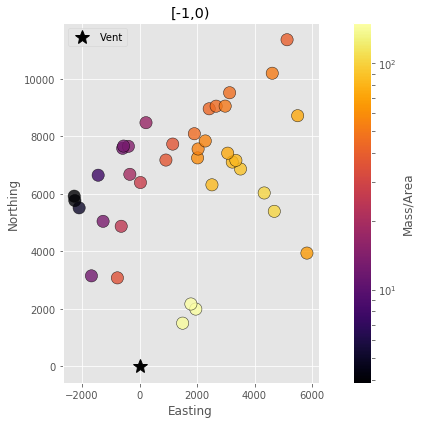

a* = -5.54605	b* = -0.57700	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.00390	b = 1.56158	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 79
SSE: 0.11122501822352723


Height  Suspended Mass
0  4,430.75     5.56231e+09
1   5,776.5     5.35863e+09
2  7,122.25      5.1408e+09
3     8,468     4.91193e+09
4  9,813.75     4.67225e+09
5  11,159.5     4.42107e+09
6  12,505.2     4.15706e+09
7    13,851     3.87832e+09
8  15,196.8     3.58219e+09
9  16,542.5     3.26487e+09
10 17,888.2     2.92073e+09
11   19,234     2.54086e+09
12 20,579.8     2.10957e+09
13 21,925.5     1.59359e+09
14 23,271.2     8.85822e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

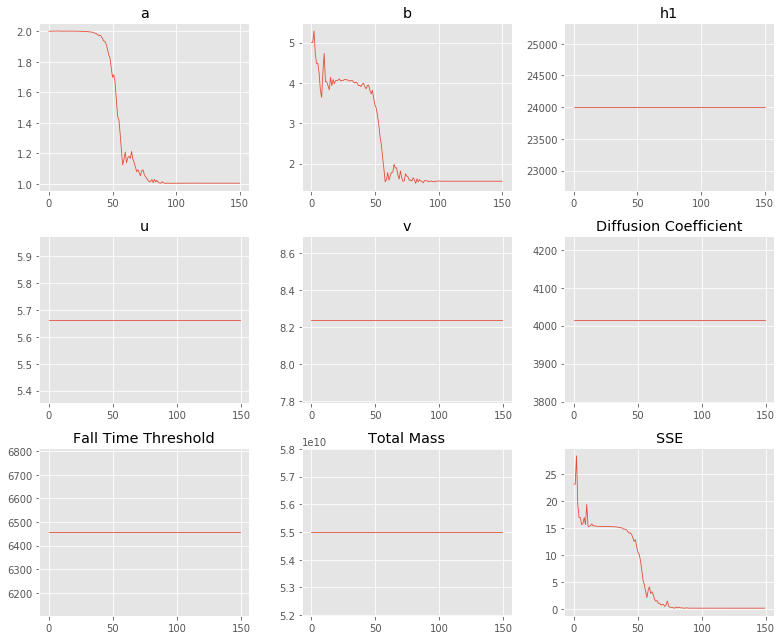

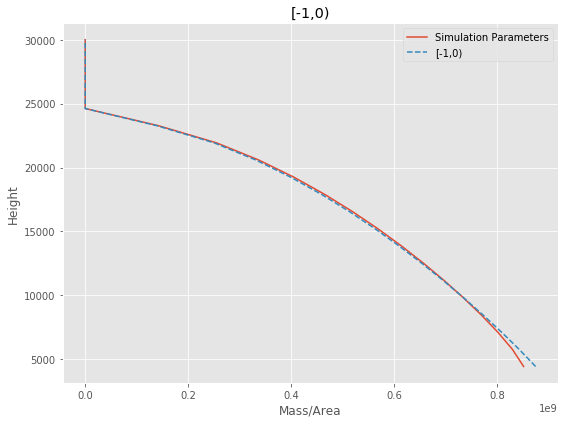

[-1,0) Run Time: 0.04714 minutes


========[0,1)========
6901066909.641724


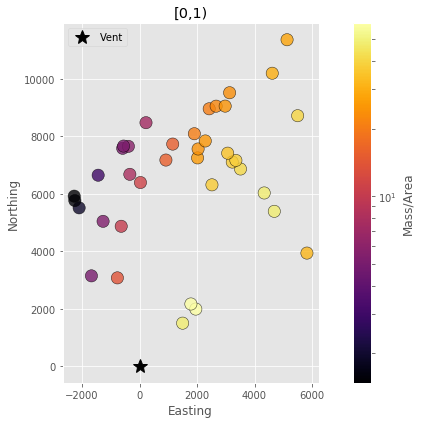

a* = -5.32958	b* = -0.49139	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.00485	b = 1.61177	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 80
SSE: 0.476841457748753


Height  Suspended Mass
0  4,430.75     5.72388e+09
1   5,776.5     5.49819e+09
2  7,122.25     5.25642e+09
3     8,468     5.00286e+09
4  9,813.75     4.73815e+09
5  11,159.5     4.46182e+09
6  12,505.2     4.17273e+09
7    13,851     3.86918e+09
8  15,196.8     3.54872e+09
9  16,542.5     3.20786e+09
10 17,888.2     2.84146e+09
11   19,234     2.44144e+09
12 20,579.8      1.9937e+09
13 21,925.5     1.46883e+09
14 23,271.2     7.74761e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

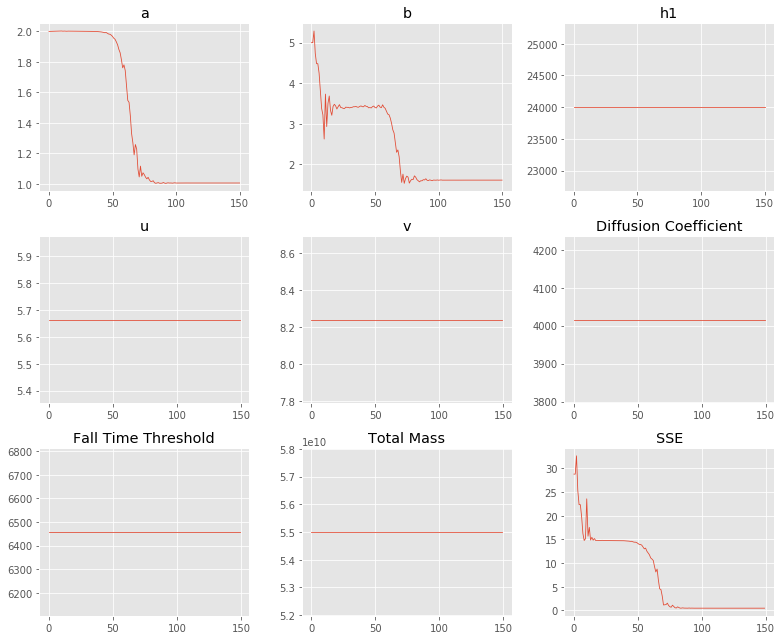

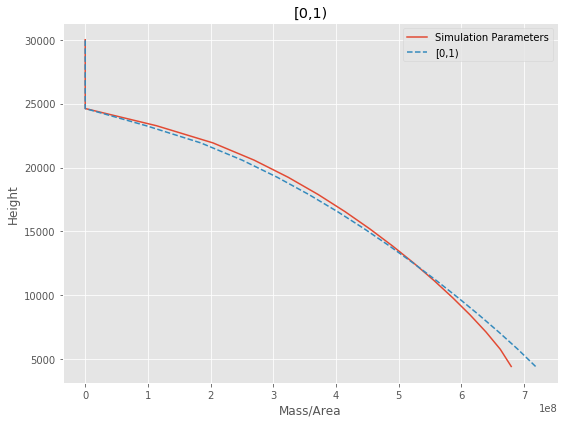

[0,1) Run Time: 0.04740 minutes


========[1,2)========
4629137051.124315


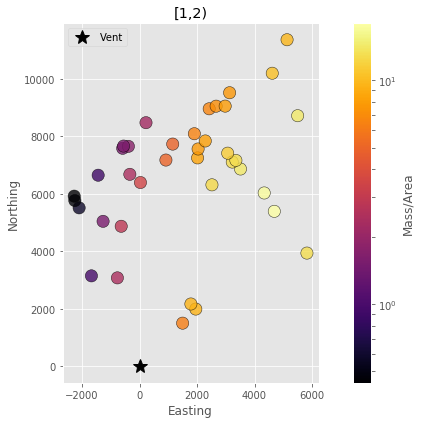

a* = -3.87981	b* = -0.61594	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.02065	b = 1.54013	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 83
SSE: 0.4529230509611526


Height  Suspended Mass
0  4,430.75     5.34227e+09
1   5,776.5     5.21471e+09
2  7,122.25     5.04512e+09
3     8,468     4.85244e+09
4  9,813.75     4.64197e+09
5  11,159.5     4.41528e+09
6  12,505.2     4.17224e+09
7    13,851     3.91164e+09
8  15,196.8     3.63117e+09
9  16,542.5     3.32717e+09
10 17,888.2     2.99397e+09
11   19,234     2.62233e+09
12 20,579.8      2.1957e+09
13 21,925.5     1.67862e+09
14 23,271.2     9.55364e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

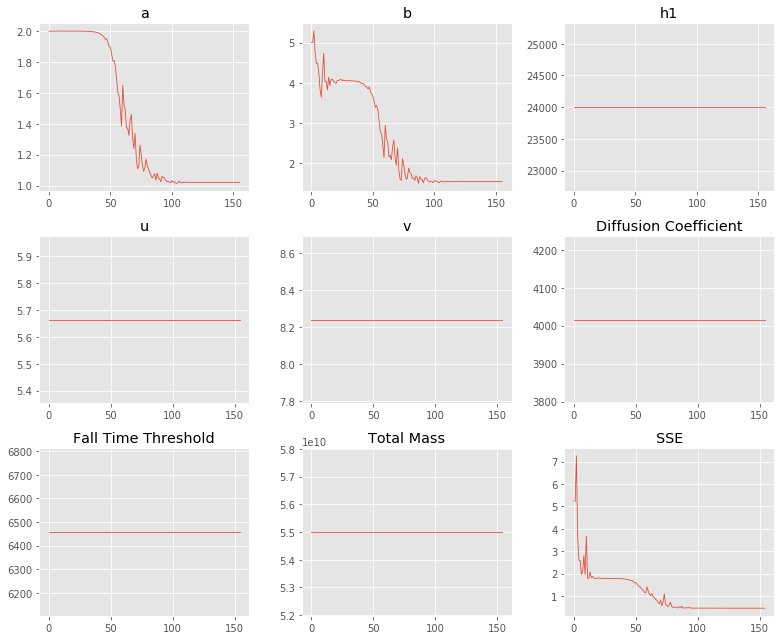

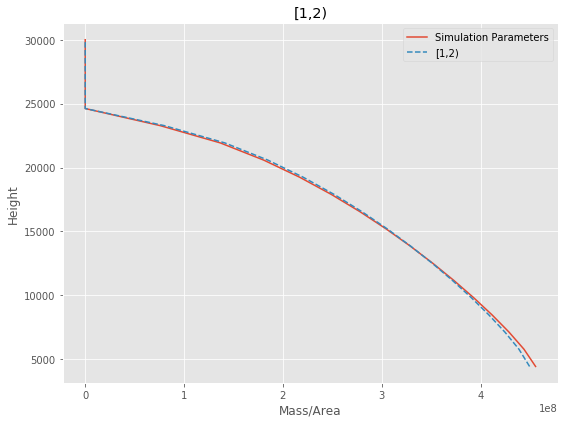

[1,2) Run Time: 0.04792 minutes


========[2,3)========
2610270359.5739555


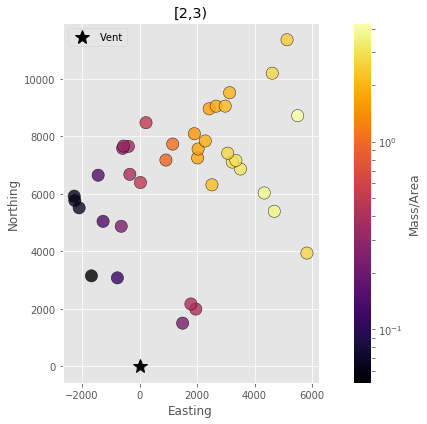

a* = -3.57541	b* = -0.15146	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.02800	b = 1.85945	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 90
SSE: 0.39197799861278354


Height  Suspended Mass
0  4,430.75     6.32985e+09
1   5,776.5     6.07058e+09
2  7,122.25     5.74813e+09
3     8,468     5.39524e+09
4  9,813.75     5.02223e+09
5  11,159.5     4.63353e+09
6  12,505.2     4.23119e+09
7    13,851     3.81602e+09
8  15,196.8     3.38802e+09
9  16,542.5     2.94649e+09
10 17,888.2     2.48991e+09
11   19,234     2.01563e+09
12 20,579.8     1.51894e+09
13 21,925.5     9.90419e+08
14 23,271.2     4.03813e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

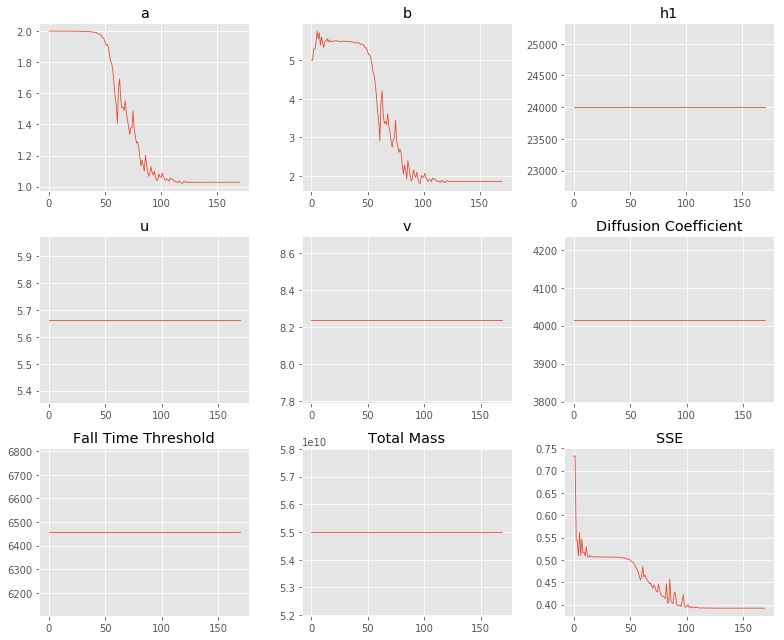

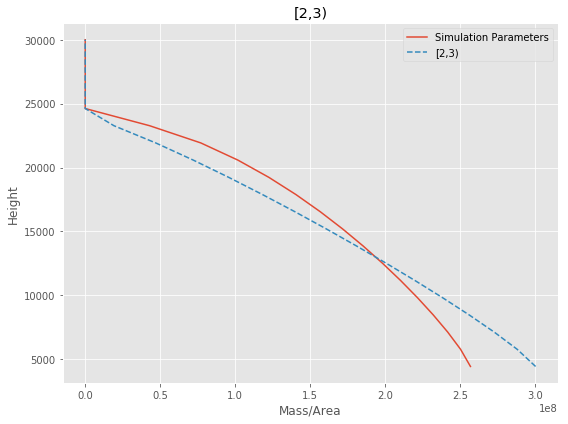

[2,3) Run Time: 0.05104 minutes


========[3,4)========
1237293118.1540995


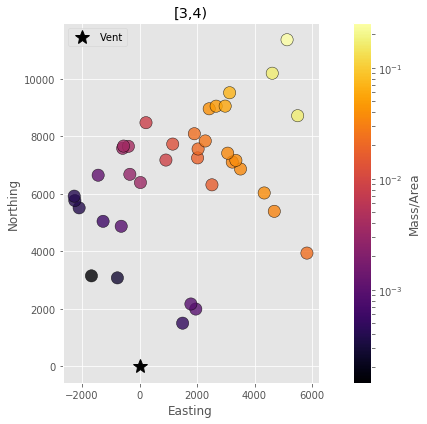

a* = -0.00386	b* = 2.33605	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.99614	b = 11.34036	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 27
SSE: 0.011029437917206024


Height  Suspended Mass
0  4,430.75     1.68633e+10
1   5,776.5     1.61011e+10
2  7,122.25     1.09083e+10
3     8,468     6.15261e+09
4  9,813.75     3.01024e+09
5  11,159.5     1.28792e+09
6  12,505.2     4.77955e+08
7    13,851     1.50656e+08
8  15,196.8     3.89146e+07
9  16,542.5     7.77451e+06
10 17,888.2     1.09198e+06
11   19,234        90,986.6
12 20,579.8        3,188.59
13 21,925.5         19.5123
14 23,271.2     0.000418956
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

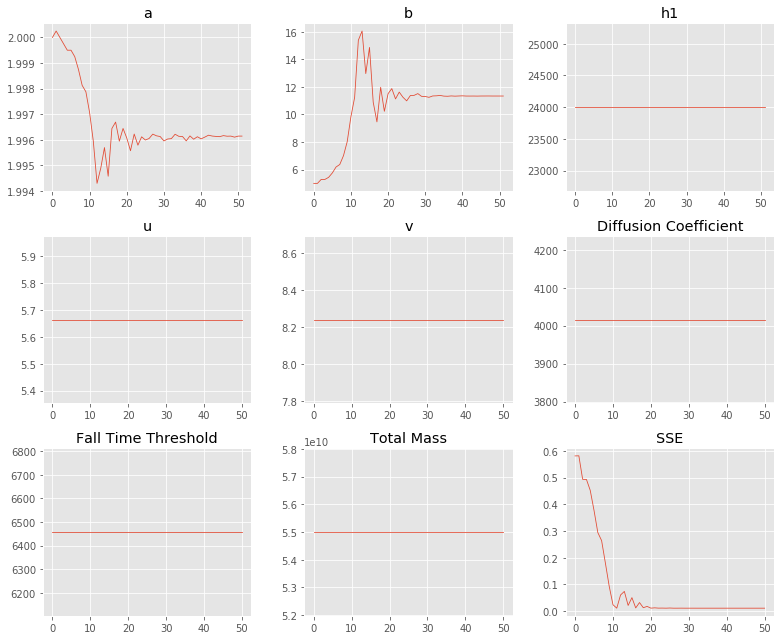

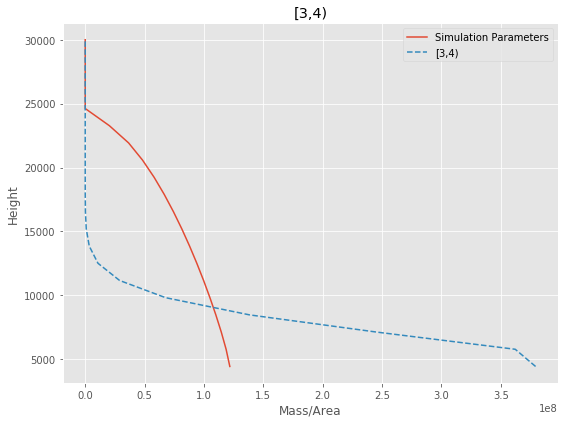

[3,4) Run Time: 0.03177 minutes


Total Run Time: 0.44193 minutes


In [54]:
df = forward_df

H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []
forward_df_list = []

for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = config["ERUPTION_MASS"]
    
    print("========%s========"%phi_step["interval"])
    
    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 2500, [phi_step], (config["ALPHA"],config["BETA"]), 
        config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    
    
    forward_df_list += [post_df]
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    vis.plot_sample(post_df, vent=(0,0), log=True, bounds=None,
                title=phi_step["interval"], cbar_label="Mass/Area", ax = ax)
    plt.tight_layout()
    plt.show()

    out = gaussian_stack_inversion(
        post_df, len(post_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                                config["VENT_ELEVATION"], 
                                params["h1"], 
                                inversion_table["Height"],
                                mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))


data = forward_df

H = 30000

wind_angle = np.radians(55.5)

t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = data.copy()
    
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    print(mass_in_phi)
    
    print("========%s========"%phi_step["interval"])
    
        grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 2500, [phi_step], (config["ALPHA"],config["BETA"]), 
        config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    
    
    forward_df_list += [post_df]
    fig, ax = plt.subplots(1, 1, figsize=(10,6))

    vis.plot_sample(post_df, vent=(0,0), log=True, bounds=None,
                title=phi_step["interval"], cbar_label="Mass/Area", ax = ax)
    plt.tight_layout()
    plt.show()
    
    out = gaussian_stack_multi_run(
        post_df, len(post_df), 20, 
        config["VENT_ELEVATION"], 
        H, 2500, [phi_step], 
        param_config, runs=5, column_cap=H
    )
    
    masses_list, sse_list, params_list, priors_list, heights = out
    
    best = np.argsort(sse_list)
    
    params = params_list[best[0]]
    

    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                                config["VENT_ELEVATION"], 
                                params["h1"], 
                                heights,
                                mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]

     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                heights,
                                mass_in_phi)

    ax1.plot(q_mass, heights, label="Simulation Parameters")
    
    ax1.plot(inv_mass, heights, 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))
   

NameError: name 'inversion_table' is not defined

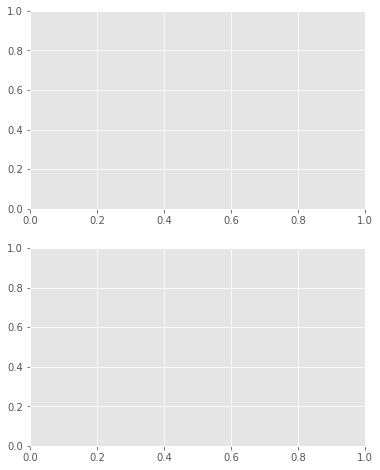

In [18]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]


totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])

ax2.plot(q_mass, heigts, label="Simulation Parameters")
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Grain Size"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Grain Size", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
print(sum(params_df["M"]))
print(config["ERUPTION_MASS"])
print(config["ERUPTION_MASS"] - sum(params_df["M"]))
display(params_df)

Easting  Northing  Elevation  MassArea  [-5,-4)   radius  Residual
16     1499      1506       2500   222.277      100 2,124.86  0.355189
18     1957      1997       2500   157.965      100 2,796.04  0.378631
17     1787      2173       2500   160.881      100 2,813.41  0.321351
37     -770      3082       2500   49.3015      100 3,176.73  0.082928
31    -1673      3152       2500    19.125      100 3,568.48  0.152804

[-5,-4)


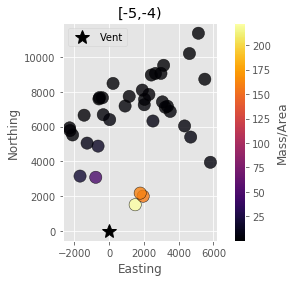

Easting  Northing  Elevation  MassArea  [-4,-3)   radius  Residual
16     1499      1506       2500   312.887      100 2,124.86  0.499979
18     1957      1997       2500   252.026      100 2,796.04  0.604089
17     1787      2173       2500   258.343      100 2,813.41  0.516025
37     -770      3082       2500   76.0382      100 3,176.73  0.127901
31    -1673      3152       2500   29.0344      100 3,568.48  0.231978

[-4,-3)


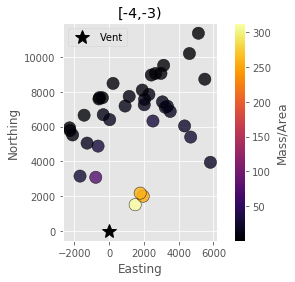

Easting  Northing  Elevation  MassArea  [-3,-2)   radius  Residual
16     1499      1506       2500   320.198      100 2,124.86  0.511662
18     1957      1997       2500   280.225      100 2,796.04   0.67168
17     1787      2173       2500   288.513      100 2,813.41  0.576288
37     -770      3082       2500   81.7047      100 3,176.73  0.137432
31    -1673      3152       2500   30.4694      100 3,568.48  0.243444

[-3,-2)


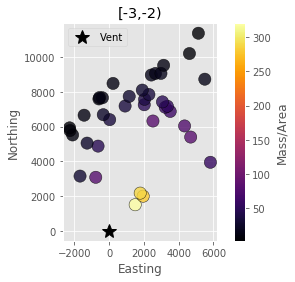

Easting  Northing  Elevation  MassArea  [-2,-1)   radius  Residual
16     1499      1506       2500    244.45      100 2,124.86   0.39062
18     1957      1997       2500   228.605      100 2,796.04  0.547951
17     1787      2173       2500    235.95      100 2,813.41  0.471297
37     -770      3082       2500   64.7957      100 3,176.73   0.10899
31    -1673      3152       2500   23.4223      100 3,568.48  0.187139

[-2,-1)


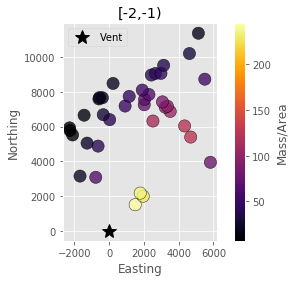

Easting  Northing  Elevation  MassArea  [-1,0)   radius  Residual
16     1499      1506       2500   140.156     100 2,124.86  0.223963
18     1957      1997       2500   143.535     100 2,796.04  0.344044
17     1787      2173       2500   148.448     100 2,813.41  0.296516
37     -770      3082       2500   40.9097     100 3,176.73 0.0688125
31    -1673      3152       2500   14.5664     100 3,568.48  0.116382

[-1,0)


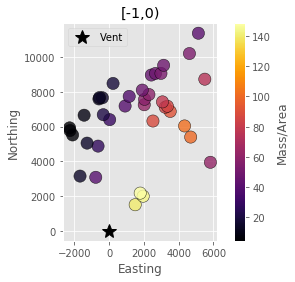

Easting  Northing  Elevation  MassArea  [0,1)   radius  Residual
16     1499      1506       2500   46.3013    100 2,124.86 0.0739874
18     1957      1997       2500   55.6625    100 2,796.04  0.133419
17     1787      2173       2500   57.7844    100 2,813.41  0.115421
37     -770      3082       2500   17.1038    100 3,176.73 0.0287696
31    -1673      3152       2500   6.43141    100 3,568.48 0.0513855

[0,1)


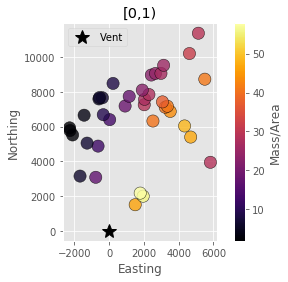

Easting  Northing  Elevation  MassArea  [1,2)   radius   Residual
16     1499      1506       2500   5.80654    100 2,124.86 0.00927859
18     1957      1997       2500   8.66836    100 2,796.04  0.0207775
17     1787      2173       2500   9.05156    100 2,813.41    0.01808
37     -770      3082       2500   3.07262    100 3,176.73 0.00516832
31    -1673      3152       2500   1.34301    100 3,568.48  0.0107303

[1,2)


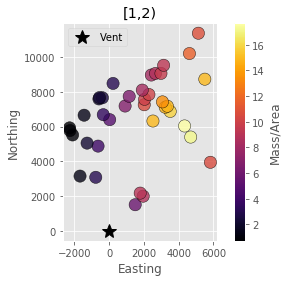

Easting  Northing  Elevation  MassArea  [2,3)   radius    Residual
16     1499      1506       2500  0.198079    100 2,124.86 0.000316521
18     1957      1997       2500  0.346058    100 2,796.04 0.000829477
17     1787      2173       2500  0.362992    100 2,813.41 0.000725056
37     -770      3082       2500  0.136876    100 3,176.73 0.000230233
31    -1673      3152       2500 0.0678033    100 3,568.48 0.000541733

[2,3)


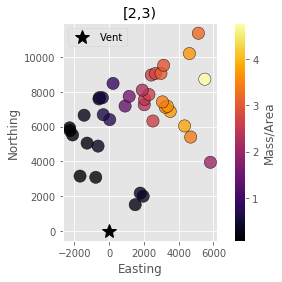

Easting  Northing  Elevation    MassArea  [3,4)   radius    Residual
16     1499      1506       2500 0.000367999    100 2,124.86 5.88046e-07
18     1957      1997       2500 0.000710591    100 2,796.04 1.70324e-06
17     1787      2173       2500 0.000747525    100 2,813.41 1.49314e-06
37     -770      3082       2500  0.00030304    100 3,176.73 5.09731e-07
31    -1673      3152       2500 0.000164168    100 3,568.48 1.31167e-06

[3,4)


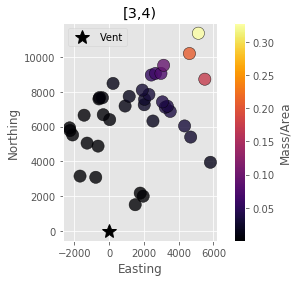

In [41]:
t2_gs_data = []
for i in range(9):
    df, _, _, _ = io.read_tephra2("data/colima/colima_gs_trial/colima_%d_out.txt"%i)
    df["Residual"] = df["MassArea"].values/obs_df["MassArea"].values
    display(df.head())
    t2_gs_data.append(df)
    print(phi_steps[i]["interval"])
    vis.plot_sample(df, vent=(0,0), log=False, title=phi_steps[i]["interval"], cbar_label="Mass/Area")
    plt.show()

========[-5,-4)========
a* = -0.76874	b* = 0.11450	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.46360	b = 2.12131	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 62
SSE: 0.08975978424367945


Height  Suspended Mass
0  4,430.75     3.64691e+09
1   5,776.5     4.64286e+09
2  7,122.25     5.14117e+09
3     8,468     5.35203e+09
4  9,813.75     5.36181e+09
5  11,159.5     5.21774e+09
6  12,505.2     4.94998e+09
7    13,851     4.57986e+09
8  15,196.8     4.12374e+09
9  16,542.5     3.59513e+09
10 17,888.2     3.00601e+09
11   19,234     2.36807e+09
12 20,579.8     1.69408e+09
13 21,925.5     1.00085e+09
14 23,271.2     3.19748e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

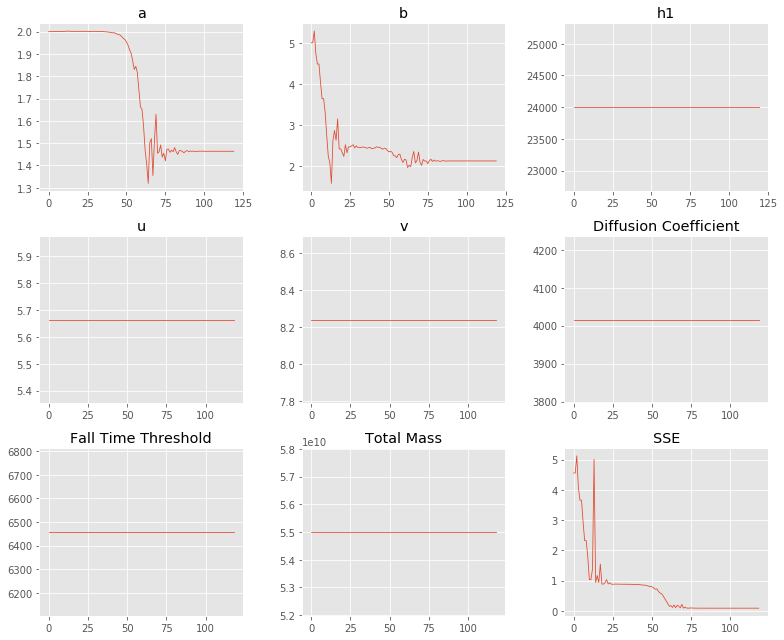

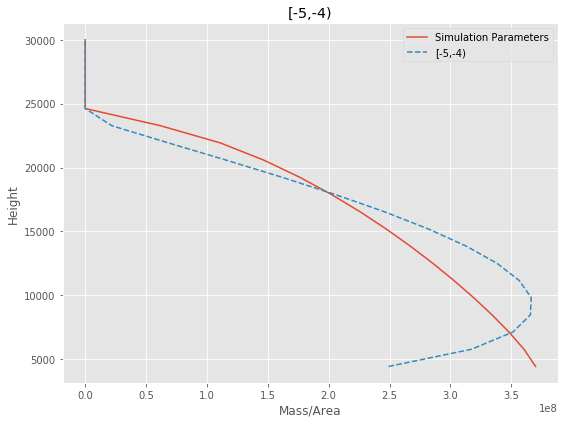

[-5,-4) Run Time: 0.03906 minutes


========[-4,-3)========
a* = -0.93198	b* = 0.10167	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.39377	b = 2.10702	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 65
SSE: 0.6311187155430233


Height  Suspended Mass
0  4,430.75      4.0598e+09
1   5,776.5     4.92934e+09
2  7,122.25     5.31185e+09
3     8,468     5.42618e+09
4  9,813.75     5.35899e+09
5  11,159.5     5.15637e+09
6  12,505.2     4.84705e+09
7    13,851     4.45092e+09
8  15,196.8     3.98291e+09
9  16,542.5     3.45508e+09
10 17,888.2     2.87793e+09
11   19,234     2.26146e+09
12 20,579.8     1.61644e+09
13 21,925.5     9.56862e+08
14 23,271.2     3.08808e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

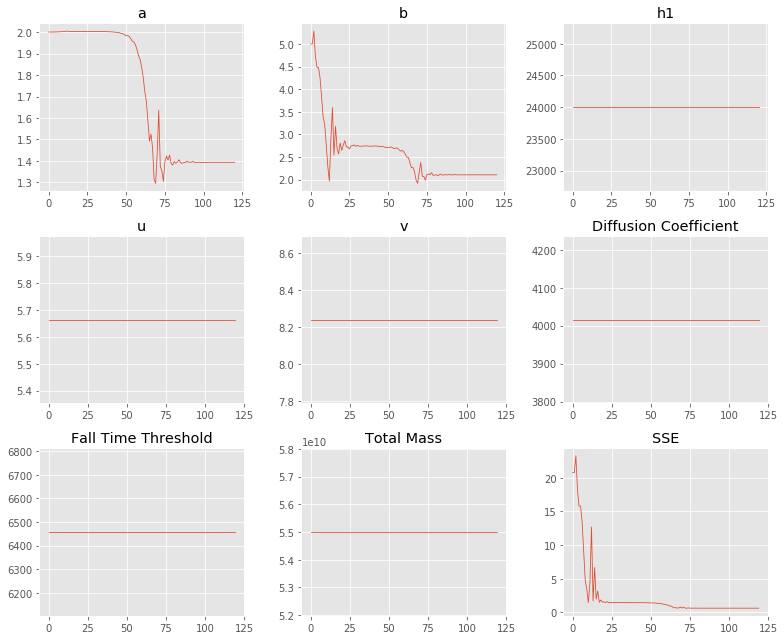

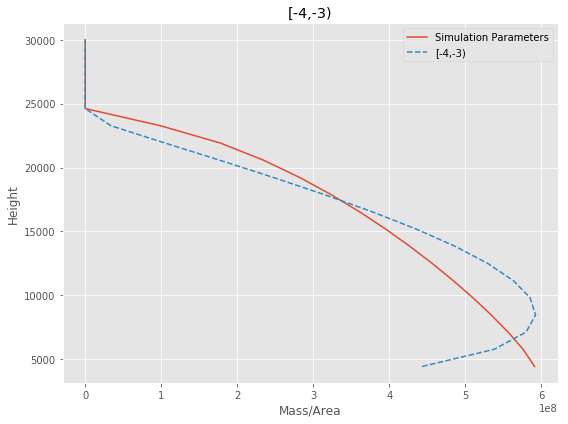

[-4,-3) Run Time: 0.04193 minutes


========[-3,-2)========
a* = -2.18589	b* = -0.29227	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.11238	b = 1.74657	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 78
SSE: 2.1261385611740797


Height  Suspended Mass
0  4,430.75     5.21664e+09
1   5,776.5     5.34711e+09
2  7,122.25     5.28487e+09
3     8,468     5.13019e+09
4  9,813.75     4.91631e+09
5  11,159.5     4.65824e+09
6  12,505.2     4.36363e+09
7    13,851      4.0364e+09
8  15,196.8     3.67806e+09
9  16,542.5      3.2883e+09
10 17,888.2     2.86483e+09
11   19,234     2.40275e+09
12 20,579.8      1.8925e+09
13 21,925.5     1.31384e+09
14 23,271.2     6.06341e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

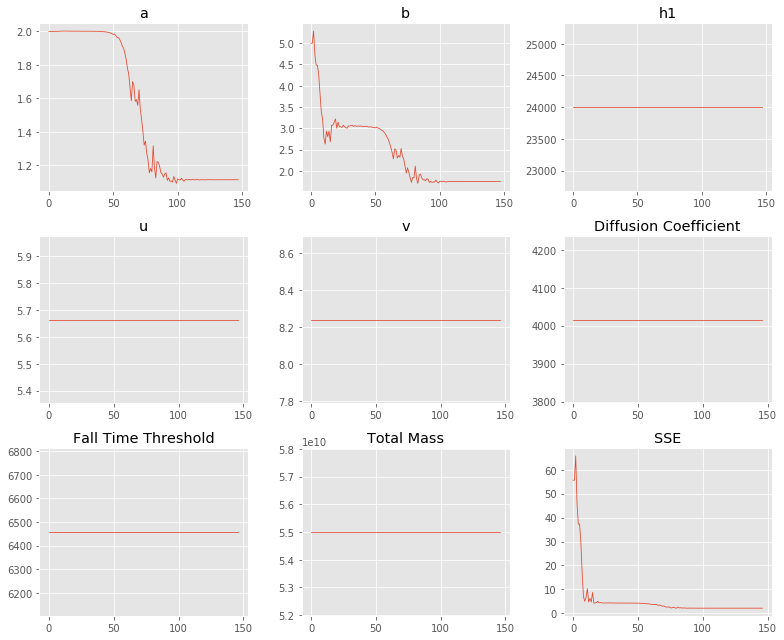

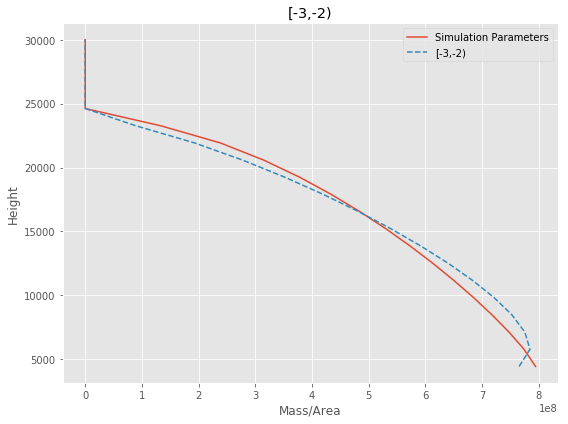

[-3,-2) Run Time: 0.04557 minutes


========[-2,-1)========
a* = -1.59052	b* = -0.07671	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.20382	b = 1.92616	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 75
SSE: 3.0204154197233923


Height  Suspended Mass
0  4,430.75     4.98989e+09
1   5,776.5     5.38008e+09
2  7,122.25     5.44281e+09
3     8,468     5.34399e+09
4  9,813.75     5.14238e+09
5  11,159.5     4.86647e+09
6  12,505.2     4.53239e+09
7    13,851     4.15015e+09
8  15,196.8     3.72625e+09
9  16,542.5     3.26489e+09
10 17,888.2      2.7686e+09
11   19,234     2.23834e+09
12 20,579.8     1.67323e+09
13 21,925.5     1.06907e+09
14 23,271.2     4.11461e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

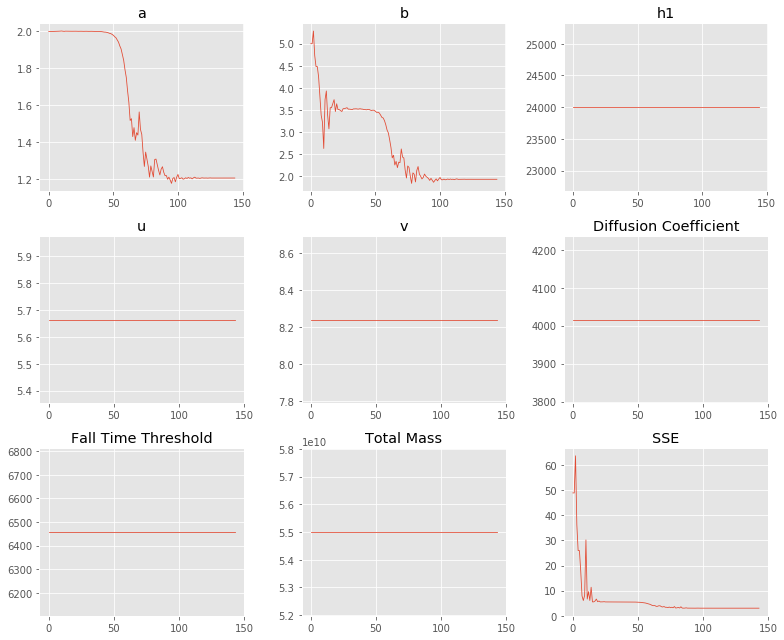

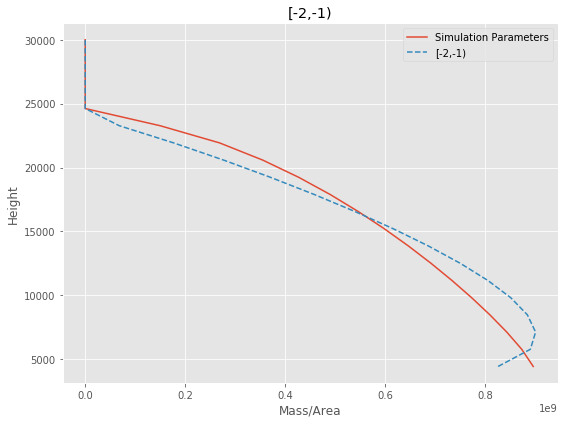

[-2,-1) Run Time: 0.04115 minutes


========[-1,0)========
a* = -1.44974	b* = 0.15211	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.23463	b = 2.16429	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 68
SSE: 1.3388192454733288


Height  Suspended Mass
0  4,430.75     5.38805e+09
1   5,776.5     5.83495e+09
2  7,122.25     5.86899e+09
3     8,468     5.69983e+09
4  9,813.75     5.40473e+09
5  11,159.5     5.02291e+09
6  12,505.2     4.57806e+09
7    13,851     4.08628e+09
8  15,196.8     3.55959e+09
9  16,542.5     3.00781e+09
10 17,888.2     2.43969e+09
11   19,234       1.864e+09
12 20,579.8     1.29072e+09
13 21,925.5     7.33779e+08
14 23,271.2     2.20607e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

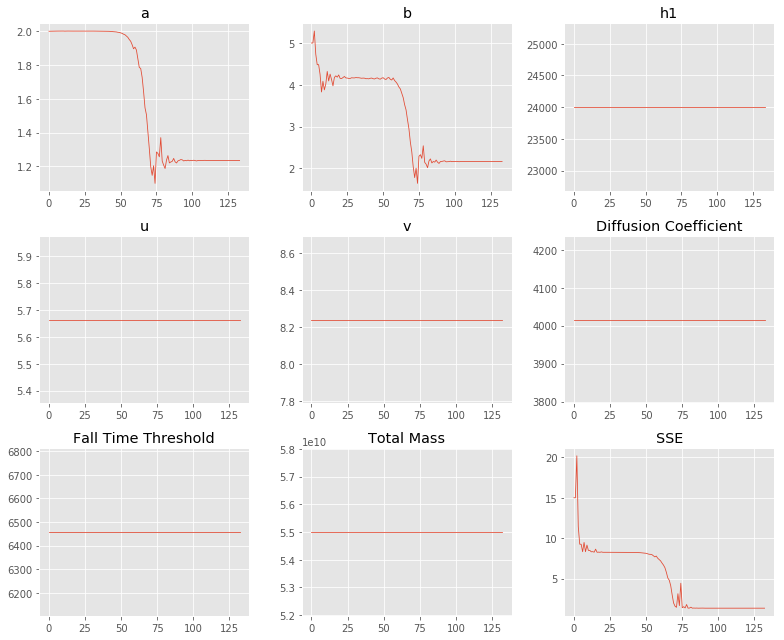

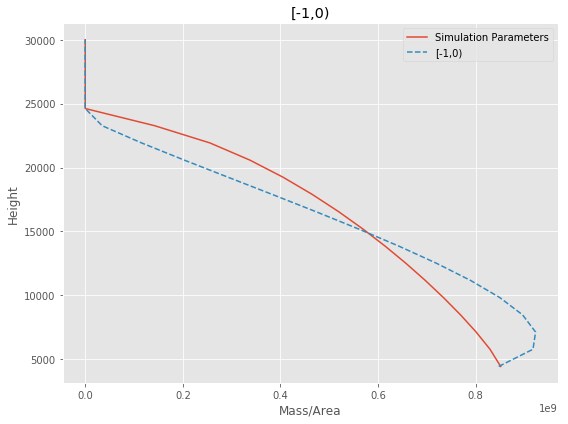

[-1,0) Run Time: 0.03880 minutes


========[0,1)========
a* = -3.07611	b* = -0.08601	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.04614	b = 1.91759	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 73
SSE: 0.6273664606250359


Height  Suspended Mass
0  4,430.75     6.34403e+09
1   5,776.5     6.13567e+09
2  7,122.25      5.8266e+09
3     8,468       5.471e+09
4  9,813.75     5.08654e+09
5  11,159.5      4.6812e+09
6  12,505.2     4.25918e+09
7    13,851     3.82281e+09
8  15,196.8     3.37329e+09
9  16,542.5     2.91107e+09
10 17,888.2     2.43589e+09
11   19,234     1.94667e+09
12 20,579.8     1.44104e+09
13 21,925.5     9.13927e+08
14 23,271.2     3.51078e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

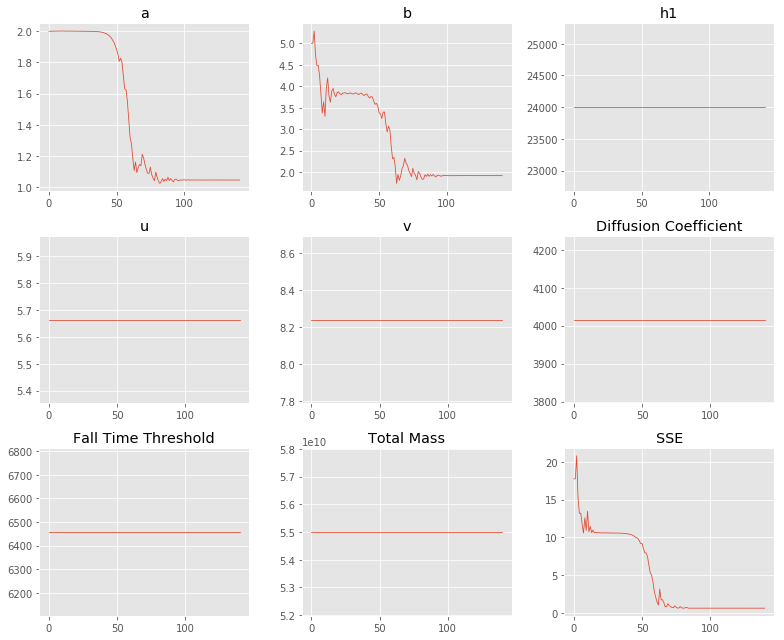

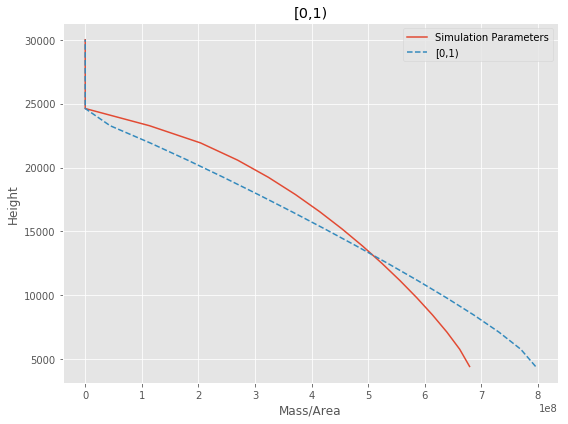

[0,1) Run Time: 0.04297 minutes


========[1,2)========
a* = -1.51295	b* = 0.30471	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.22026	b = 2.35623	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 69
SSE: 0.9619308881773343


Height  Suspended Mass
0  4,430.75     6.03079e+09
1   5,776.5     6.37844e+09
2  7,122.25     6.28513e+09
3     8,468     5.98261e+09
4  9,813.75     5.55719e+09
5  11,159.5     5.05348e+09
6  12,505.2      4.4991e+09
7    13,851     3.91345e+09
8  15,196.8      3.3116e+09
9  16,542.5     2.70646e+09
10 17,888.2      2.1101e+09
11   19,234     1.53511e+09
12 20,579.8     9.96249e+08
13 21,925.5     5.13997e+08
14 23,271.2     1.26293e+08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

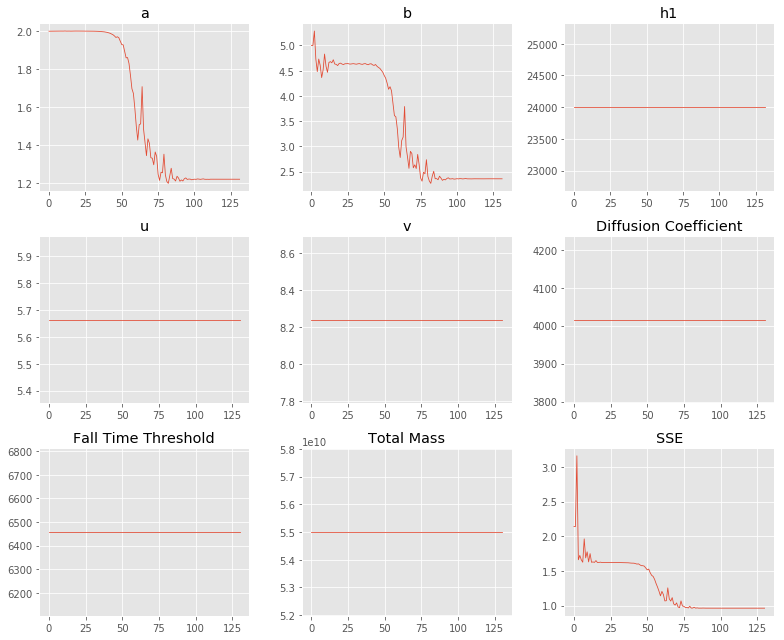

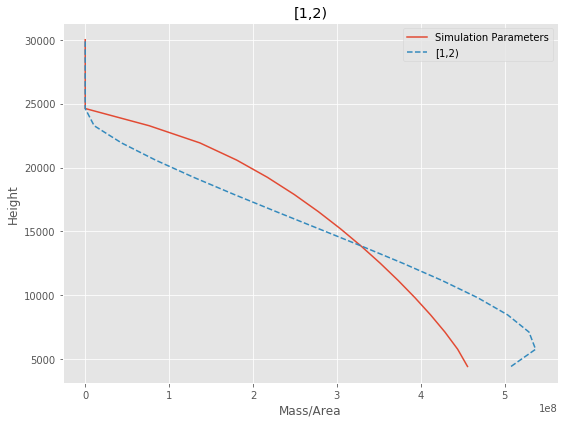

[1,2) Run Time: 0.04010 minutes


========[2,3)========
a* = -3.64715	b* = 0.35777	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.02607	b = 2.43014	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 95
SSE: 0.44101438978404184


Height  Suspended Mass
0  4,430.75     8.18097e+09
1   5,776.5     7.52314e+09
2  7,122.25     6.81303e+09
3     8,468     6.09519e+09
4  9,813.75     5.38547e+09
5  11,159.5     4.69226e+09
6  12,505.2     4.02126e+09
7    13,851     3.37705e+09
8  15,196.8     2.76386e+09
9  16,542.5     2.18609e+09
10 17,888.2      1.6487e+09
11   19,234     1.15786e+09
12 20,579.8      7.2191e+08
13 21,925.5     3.53813e+08
14 23,271.2     7.93946e+07
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

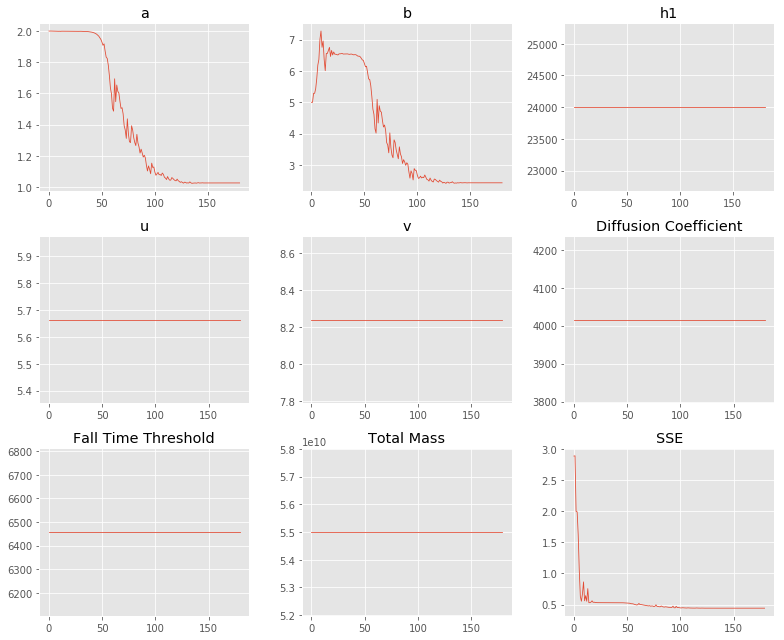

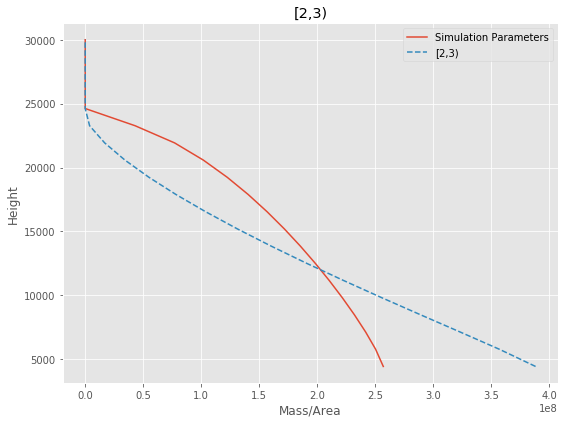

[2,3) Run Time: 0.04766 minutes


========[3,4)========
a* = -0.00517	b* = 2.58127	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.99484	b = 14.21396	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 29
SSE: 0.006729396804031414


Height  Suspended Mass
0  4,430.75     2.21047e+10
1   5,776.5     1.71827e+10
2  7,122.25     9.33299e+09
3     8,468     4.14439e+09
4  9,813.75     1.56233e+09
5  11,159.5     5.01846e+08
6  12,505.2     1.35461e+08
7    13,851       2.985e+07
8  15,196.8     5.12237e+06
9  16,542.5         635,228
10 17,888.2        50,356.7
11   19,234        2,053.01
12 20,579.8         27.7263
13 21,925.5       0.0403249
14 23,271.2     4.28369e-08
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

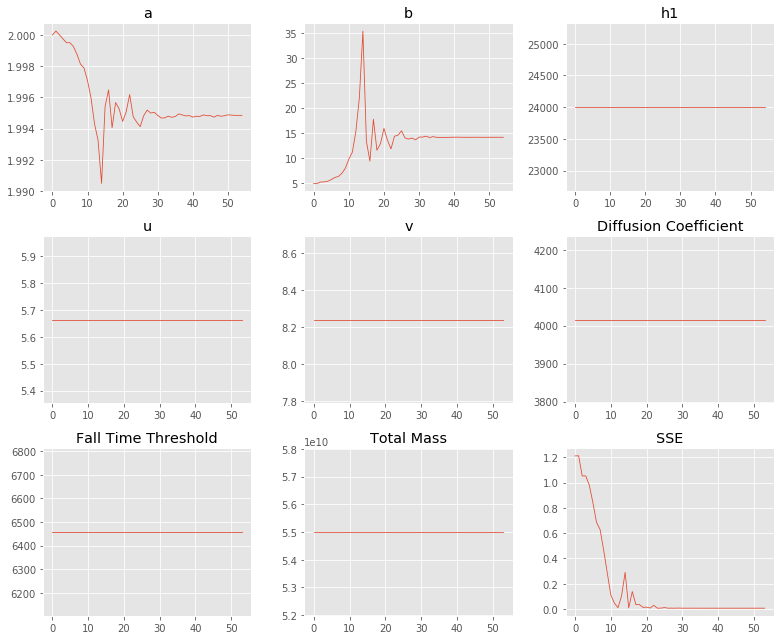

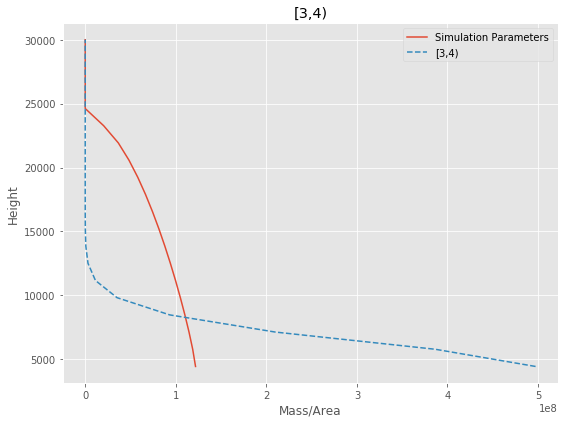

[3,4) Run Time: 0.02682 minutes


Total Run Time: 0.36406 minutes


In [42]:
df = t2_const_df

priors_vals = {
    "a": 2,
    "b": 5,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : False,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = config["ERUPTION_MASS"]
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                            config["VENT_ELEVATION"], 
                            params["h1"], 
                            inversion_table["Height"],
                            mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

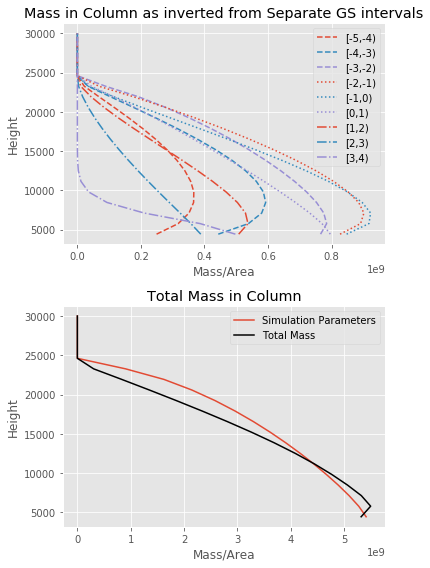

Grain Size       a       b     h1       u       v     D   ftt       M
0    [-5,-4)  1.4636 2.12131 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
1    [-4,-3) 1.39377 2.10702 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
2    [-3,-2) 1.11238 1.74657 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
3    [-2,-1) 1.20382 1.92616 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
4     [-1,0) 1.23463 2.16429 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
5      [0,1) 1.04614 1.91759 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
6      [1,2) 1.22026 2.35623 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
7      [2,3) 1.02607 2.43014 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
8      [3,4) 1.99484  14.214 24,000 5.66406 8.24126 4,016 6,458 5.5e+10

In [43]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]


totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])

ax2.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Grain Size"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Grain Size", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

========[-5,-4)========
a* = -3.85785	b* = 2.59646	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.02111	b = 14.41617	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 92
SSE: 46.889526013199


Height  Suspended Mass
0  4,430.75     3.44699e+10
1   5,776.5     1.34483e+10
2  7,122.25     4.84612e+09
3     8,468     1.59912e+09
4  9,813.75     4.76288e+08
5  11,159.5     1.25549e+08
6  12,505.2     2.85197e+07
7    13,851     5.38111e+06
8  15,196.8         800,014
9  16,542.5        86,582.8
10 17,888.2        6,008.65
11   19,234         214.029
12 20,579.8         2.50027
13 21,925.5      0.00305787
14 23,271.2     2.45819e-09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

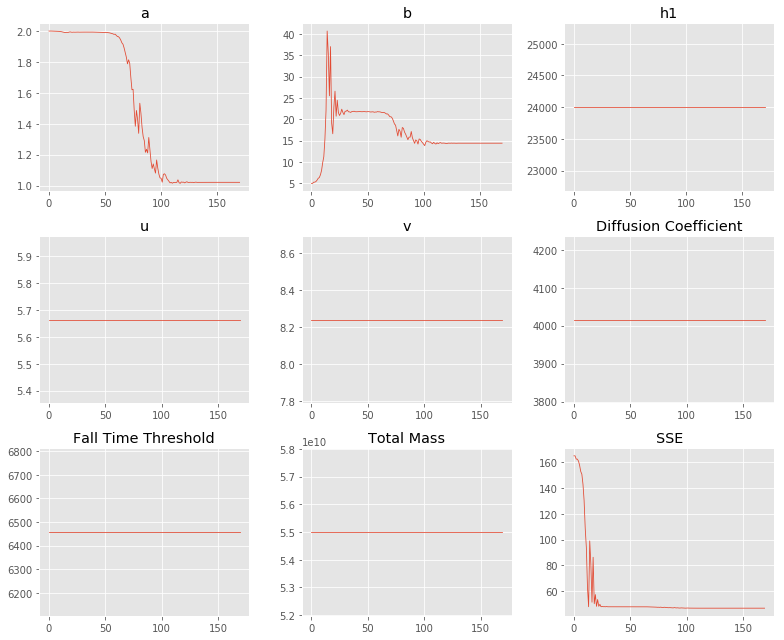

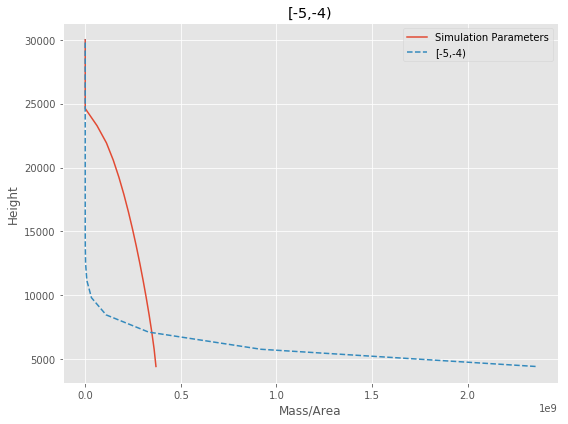

[-5,-4) Run Time: 0.04870 minutes


========[-4,-3)========
a* = 0.40044	b* = -3.24263	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 2.49249	b = 1.03906	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 63
SSE: 58.527277834179145


Height  Suspended Mass
0  4,430.75     1.57092e+08
1   5,776.5     4.40788e+08
2  7,122.25     8.04901e+08
3     8,468     1.23254e+09
4  9,813.75     1.71357e+09
5  11,159.5     2.24073e+09
6  12,505.2      2.8082e+09
7    13,851     3.41089e+09
8  15,196.8     4.04389e+09
9  16,542.5     4.70194e+09
10 17,888.2     5.37873e+09
11   19,234      6.0654e+09
12 20,579.8     6.74703e+09
13 21,925.5     7.39037e+09
14 23,271.2     7.86392e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

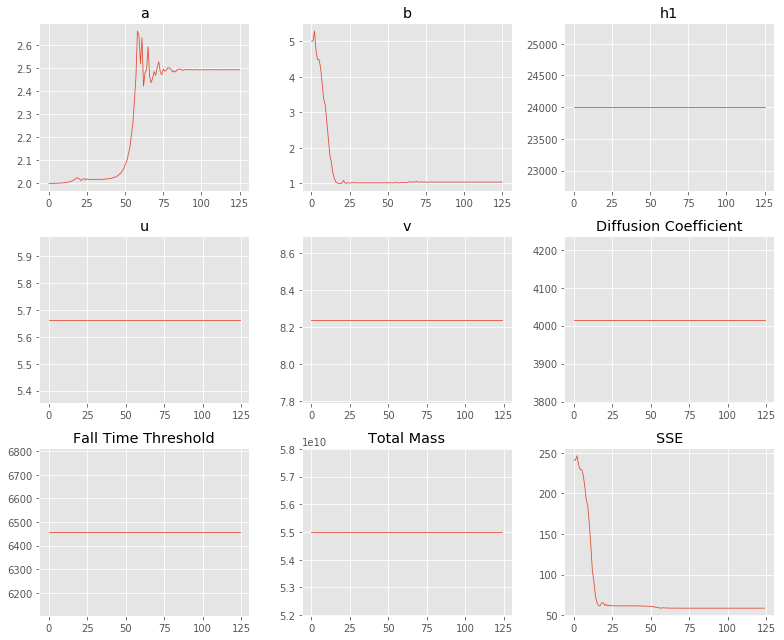

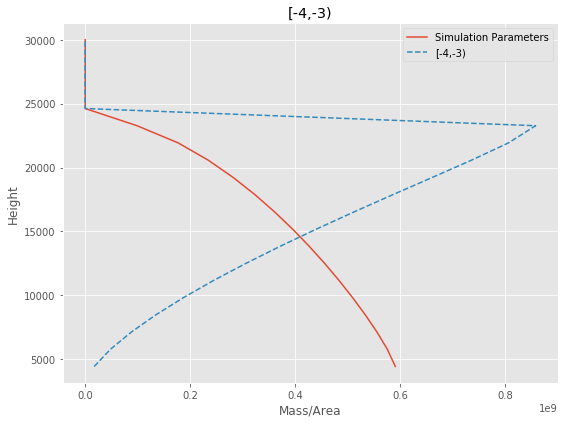

[-4,-3) Run Time: 0.04010 minutes


========[-3,-2)========
a* = -0.11446	b* = -2.74105	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.89185	b = 1.06450	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 63
SSE: 93.4041234901894


Height  Suspended Mass
0  4,430.75     6.34525e+08
1   5,776.5       1.172e+09
2  7,122.25     1.67426e+09
3     8,468      2.1524e+09
4  9,813.75     2.61104e+09
5  11,159.5     3.05238e+09
6  12,505.2     3.47731e+09
7    13,851     3.88576e+09
8  15,196.8     4.27672e+09
9  16,542.5     4.64807e+09
10 17,888.2      4.9959e+09
11   19,234      5.3131e+09
12 20,579.8     5.58543e+09
13 21,925.5     5.77769e+09
14 23,271.2     5.74342e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

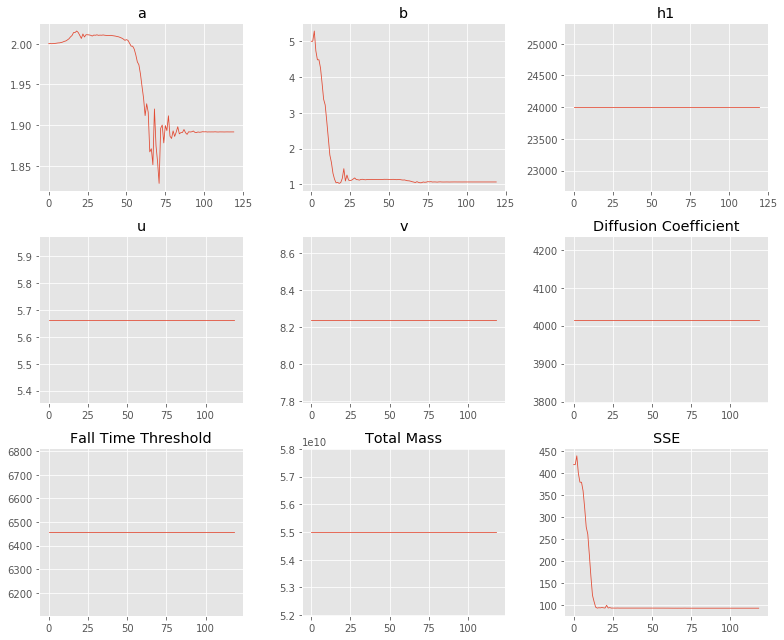

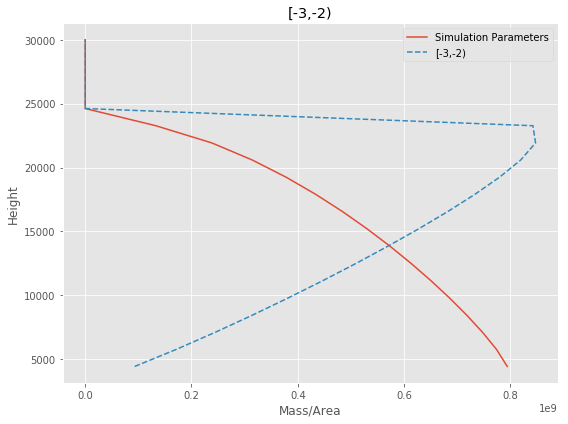

[-3,-2) Run Time: 0.03932 minutes


========[-2,-1)========
a* = -0.62243	b* = -3.25041	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.53664	b = 1.03876	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 62
SSE: 101.00831209764058


Height  Suspended Mass
0  4,430.75     1.31689e+09
1   5,776.5       1.905e+09
2  7,122.25     2.36103e+09
3     8,468     2.74631e+09
4  9,813.75     3.08482e+09
5  11,159.5     3.38879e+09
6  12,505.2     3.66528e+09
7    13,851     3.91861e+09
8  15,196.8     4.15133e+09
9  16,542.5     4.36466e+09
10 17,888.2     4.55841e+09
11   19,234     4.73049e+09
12 20,579.8     4.87501e+09
13 21,925.5     4.97544e+09
14 23,271.2     4.95794e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

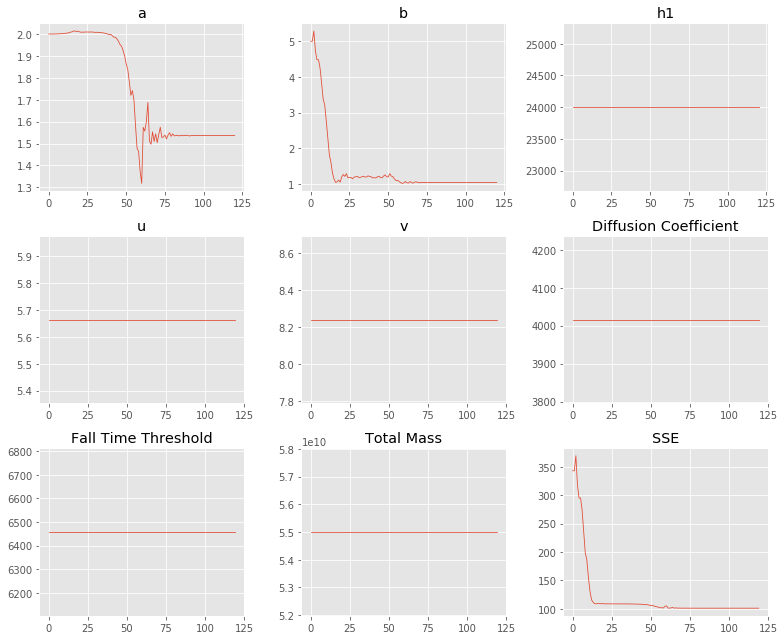

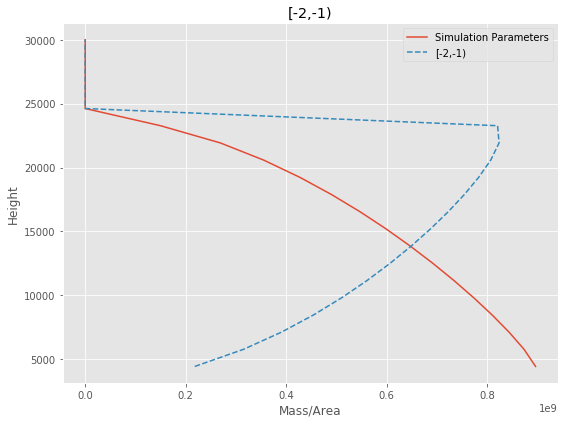

[-2,-1) Run Time: 0.03932 minutes


========[-1,0)========
a* = 0.02934	b* = -0.30276	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 2.02978	b = 1.73878	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 58
SSE: 56.88395733973519


Height  Suspended Mass
0  4,430.75     9.72413e+08
1   5,776.5     1.88358e+09
2  7,122.25     2.70213e+09
3     8,468     3.41747e+09
4  9,813.75     4.02181e+09
5  11,159.5     4.50799e+09
6  12,505.2     4.86856e+09
7    13,851     5.09529e+09
8  15,196.8     5.17849e+09
9  16,542.5     5.10616e+09
10 17,888.2     4.86261e+09
11   19,234     4.42575e+09
12 20,579.8     3.76122e+09
13 21,925.5     2.80576e+09
14 23,271.2     1.39077e+09
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

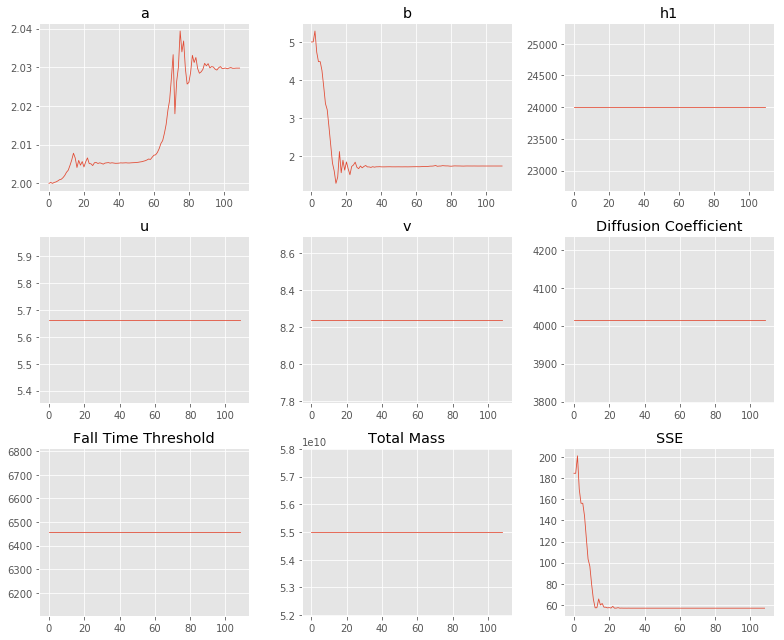

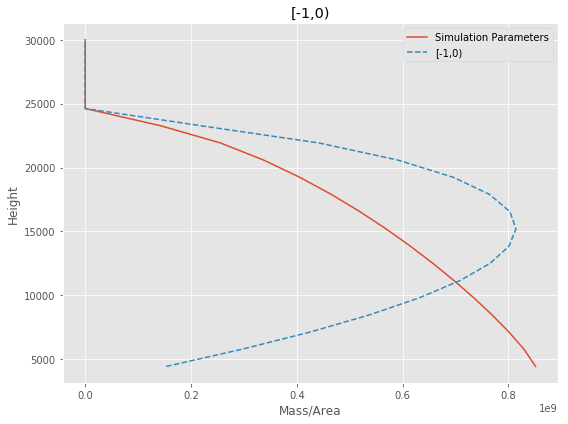

[-1,0) Run Time: 0.03568 minutes


========[0,1)========
a* = 1.14871	b* = 1.91478	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 4.15412	b = 7.78546	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 65
SSE: 38.32557135169948


Height  Suspended Mass
0  4,430.75     5.65201e+08
1   5,776.5     3.10262e+09
2  7,122.25     6.62322e+09
3     8,468     9.33841e+09
4  9,813.75     1.02062e+10
5  11,159.5     9.22356e+09
6  12,505.2     7.07612e+09
7    13,851     4.63209e+09
8  15,196.8     2.55806e+09
9  16,542.5     1.15703e+09
10 17,888.2     4.04996e+08
11   19,234     9.85672e+07
12 20,579.8     1.33542e+07
13 21,925.5         567,163
14 23,271.2         582.567
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

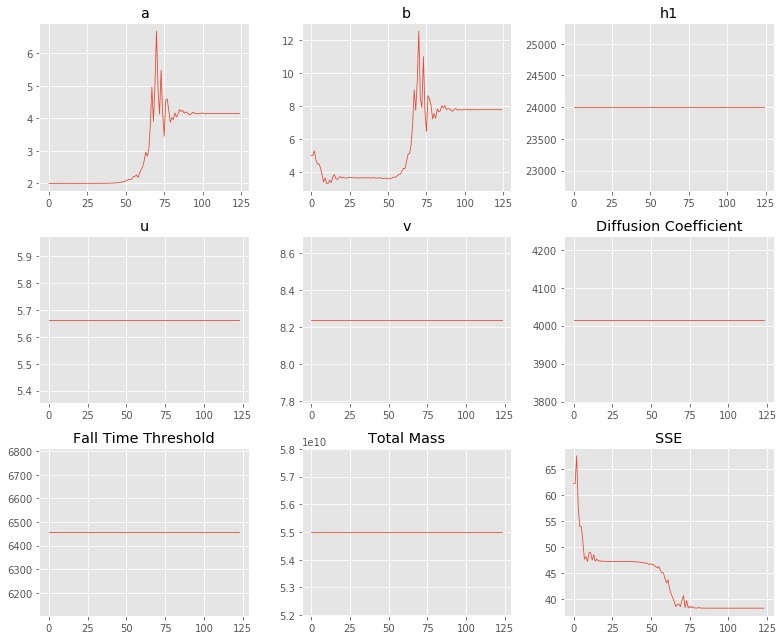

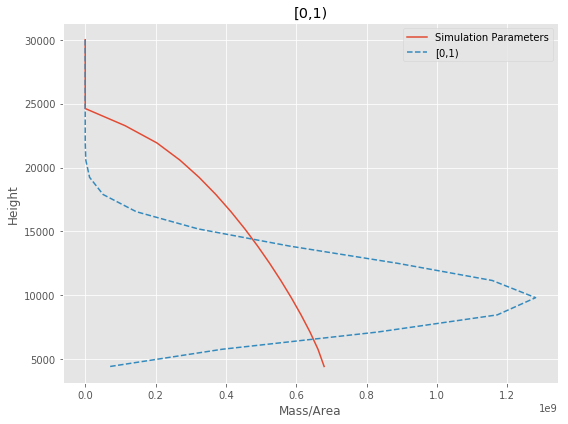

[0,1) Run Time: 0.03854 minutes


========[1,2)========
a* = 1.23722	b* = 2.32152	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 4.44603	b = 11.19112	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 66
SSE: 13.929800062241261


Height  Suspended Mass
0  4,430.75     1.11157e+09
1   5,776.5     5.86082e+09
2  7,122.25     1.08451e+10
3     8,468     1.25317e+10
4  9,813.75      1.0736e+10
5  11,159.5     7.28746e+09
6  12,505.2      4.0111e+09
7    13,851     1.78652e+09
8  15,196.8     6.29032e+08
9  16,542.5     1.66758e+08
10 17,888.2     3.04742e+07
11   19,234     3.26133e+06
12 20,579.8         146,112
13 21,925.5        1,155.18
14 23,271.2       0.0343342
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

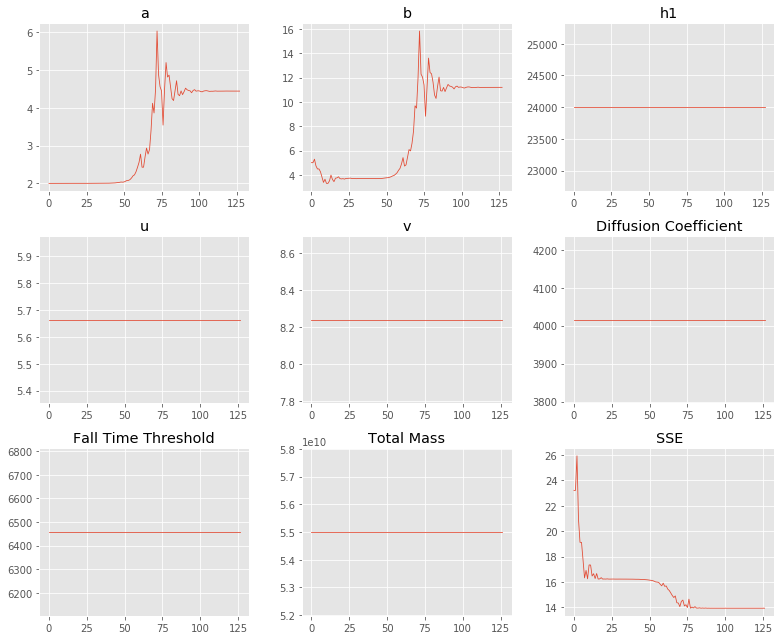

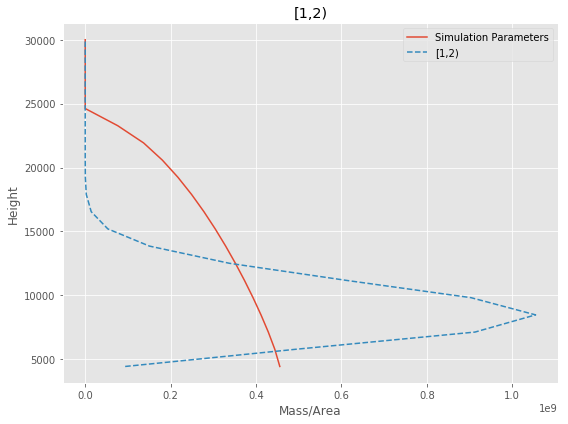

[1,2) Run Time: 0.03906 minutes


========[2,3)========
a* = -1.53937	b* = 0.72526	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.21452	b = 3.06528	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 24.68605318625505


Height  Suspended Mass
0  4,430.75     8.01657e+09
1   5,776.5     8.02897e+09
2  7,122.25     7.47524e+09
3     8,468     6.69725e+09
4  9,813.75     5.82635e+09
5  11,159.5     4.93157e+09
6  12,505.2     4.05549e+09
7    13,851     3.22701e+09
8  15,196.8     2.46706e+09
9  16,542.5      1.7914e+09
10 17,888.2      1.2122e+09
11   19,234     7.38938e+08
12 20,579.8     3.78849e+08
13 21,925.5     1.37059e+08
14 23,271.2     1.60327e+07
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

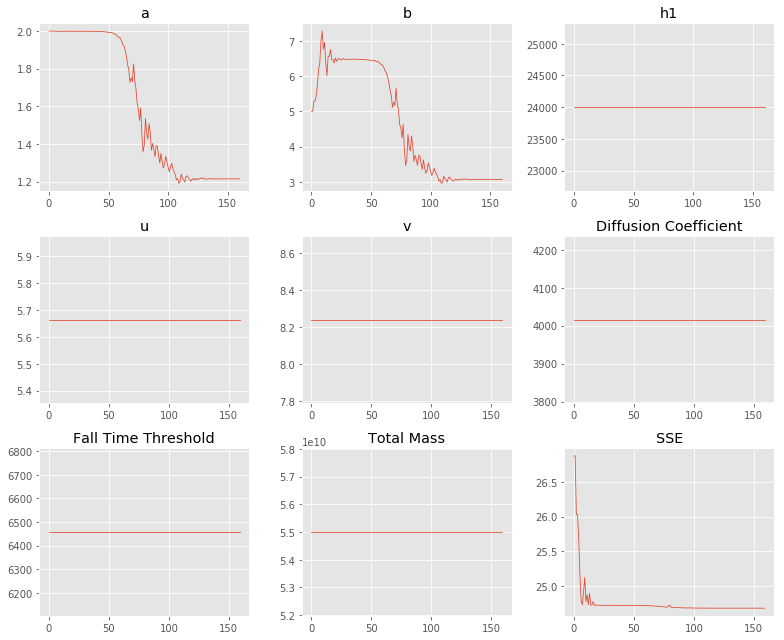

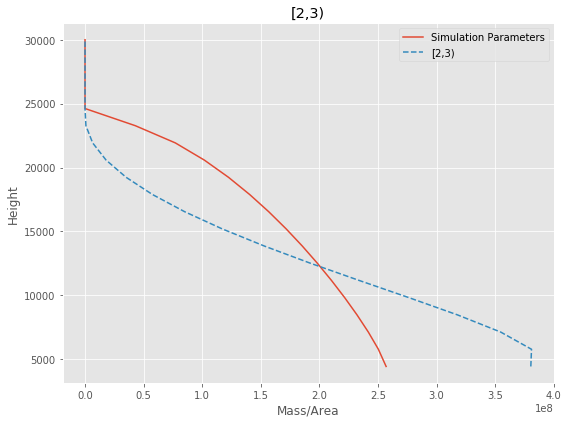

[2,3) Run Time: 0.04453 minutes


========[3,4)========


C:\Users\nmostert\Documents\repos\inversion_project\utils.py:431: RuntimeWarning: invalid value encountered in true_divide
  ret = (plume/sum(plume))*tot_mass


a* = -0.03408	b* = 9.33170	            h1* = 1.49994	u* = 5.66406	v* = 8.24126	            D* = 8.29804	ftt* = 8.77307	TM* = 24.73060
a = 1.96650	b = 11291.29822	            h1 = 24000.00000	u = 5.66406	v = 8.24126	            D = 4016.00000	ftt = 6458.00000	TM = 55000000000.00002
Success: True, Optimization terminated successfully.
Iterations: 44
SSE: 189.36582634816662


Height  Suspended Mass
0  4,430.75         5.5e+10
1   5,776.5               0
2  7,122.25               0
3     8,468               0
4  9,813.75               0
5  11,159.5               0
6  12,505.2               0
7    13,851               0
8  15,196.8               0
9  16,542.5               0
10 17,888.2               0
11   19,234               0
12 20,579.8               0
13 21,925.5               0
14 23,271.2               0
15   24,617               0
16 25,962.8               0
17 27,308.5               0
18 28,654.2               0
19   30,000               0

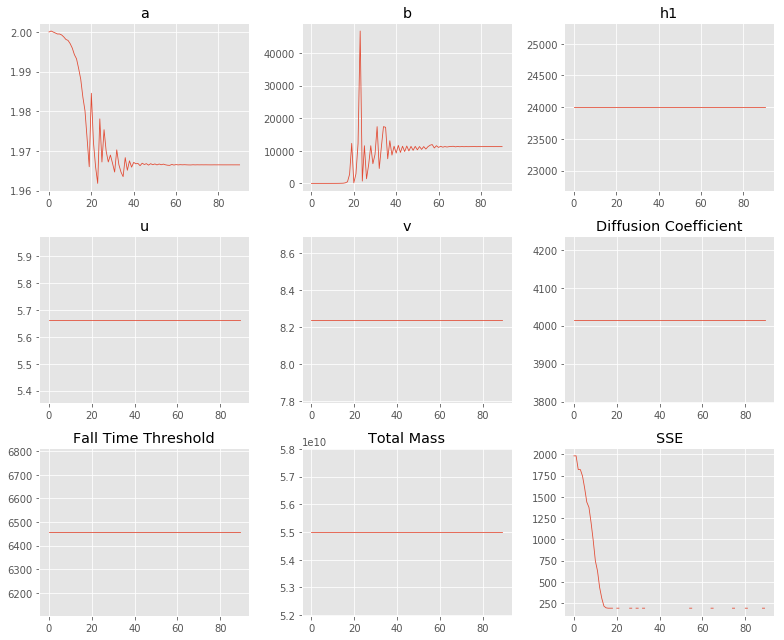

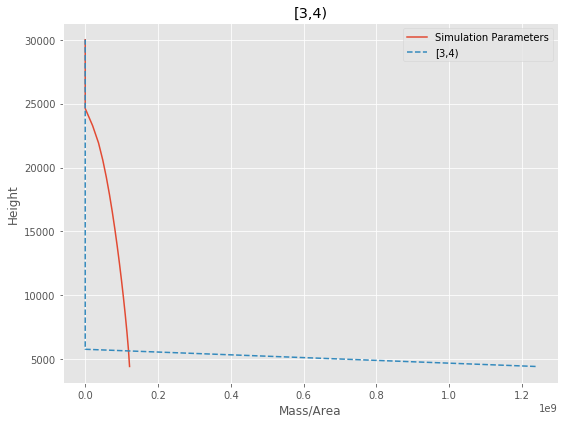

[3,4) Run Time: 0.03255 minutes


Total Run Time: 0.35781 minutes


In [44]:
df = obs_df

priors_vals = {
    "a": 2,
    "b": 5,
    "h1": config["PLUME_HEIGHT"],
    "u": u,
    "v": v,
    "D": config["DIFFUSION_COEFFICIENT"],
    "ftt": config["FALL_TIME_THRESHOLD"],
    "M": config["ERUPTION_MASS"]
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : False,
    "u": False,
    "v": False,
    "D": False,
    "ftt": False,
    "M": False
}


H = 30000

wind_angle = np.radians(55.5)


t_tot = process_time()
single_run_time = 0

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
inverted_masses_list = []
params_list = []


for phi_step in phi_steps:
    t = process_time()
    
    phi_df = df.copy()
    phi_df["MassArea"] = phi_df["MassArea"]*phi_df[phi_step["interval"]]/100
    phi_df[phi_step["interval"]] = 100
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    
    priors_vals["M"] = config["ERUPTION_MASS"]
    
    print("========%s========"%phi_step["interval"])
    
    out = gaussian_stack_inversion(
        phi_df, len(phi_df), 20, config["VENT_ELEVATION"], 
        H, 2500, [phi_step],
        invert_params=invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, plume_trace, param_trace, sse_trace = out
    inv_mass = mass_dist_in_plume(params["a"],params["b"], 
                            config["VENT_ELEVATION"], 
                            params["h1"], 
                            inversion_table["Height"],
                            mass_in_phi)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    plume_trace = np.array(plume_trace)
    param_trace = np.array(param_trace)
    fig, axs = plt.subplots(3,3, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(plume_trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(plume_trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(plume_trace[:,2], linewidth=.8)
    axs[2].set_title("h1")
    
    axs[3].plot(param_trace[:,0], linewidth=.8)
    axs[3].set_title("u")

    axs[4].plot(param_trace[:,1], linewidth=.8)
    axs[4].set_title("v")
    
    axs[5].plot(param_trace[:,2], linewidth=.8)
    axs[5].set_title("Diffusion Coefficient")
    
    axs[6].plot(param_trace[:,3], linewidth=.8)
    axs[6].set_title("Fall Time Threshold")
    
    axs[7].plot(param_trace[:,4], linewidth=.8)
    axs[7].set_title("Total Mass")

    axs[8].plot(sse_trace, linewidth=.8)
    axs[8].set_title("SSE")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
     
    fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

    q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], 
                                config["VENT_ELEVATION"], 
                                config["PLUME_HEIGHT"], 
                                inversion_table["Height"],
                                mass_in_phi)

    ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")

    ax1.plot(inv_mass, inversion_table["Height"], 
             '--', label=phi_step["interval"])
    ax1.legend()
    ax1.set_title("%s"%phi_step["interval"])
    ax1.set_ylabel("Height")
    ax1.set_xlabel("Mass/Area")

    plt.tight_layout()
    plt.show()
    run_time = process_time() - t
    print("%s Run Time: %.5f minutes\n\n"%(phi_step["interval"], run_time/60))

total_run_time = process_time() - t_tot

print("Total Run Time: %.5f minutes"%(total_run_time/60))

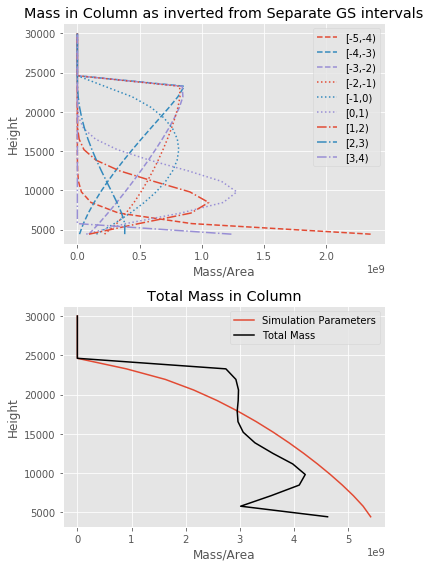

Grain Size       a        b     h1       u       v     D   ftt       M
0    [-5,-4) 1.02111  14.4162 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
1    [-4,-3) 2.49249  1.03906 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
2    [-3,-2) 1.89185   1.0645 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
3    [-2,-1) 1.53664  1.03876 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
4     [-1,0) 2.02978  1.73878 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
5      [0,1) 4.15412  7.78546 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
6      [1,2) 4.44603  11.1911 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
7      [2,3) 1.21452  3.06528 24,000 5.66406 8.24126 4,016 6,458 5.5e+10
8      [3,4)  1.9665 11,291.3 24,000 5.66406 8.24126 4,016 6,458 5.5e+10

In [45]:
fig, axs = plt.subplots(2,1, figsize=(
    6, 8), facecolor='w', edgecolor='k')
ax1, ax2 = axs.ravel()
    
q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

linestyles = ["C0--","C1--","C2--","C0:","C1:","C2:","C0-.","C1-.","C2-."]


totmass = np.zeros(len(inverted_masses_list[0]))
    
for i, (phi_step, mass) in enumerate(zip(phi_steps, inverted_masses_list)):
    totmass += mass
    ax1.plot(mass, 
         inversion_table["Height"], 
         linestyles[i], label=phi_step["interval"])

ax2.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
ax2.plot(totmass, inversion_table["Height"], "k-", label="Total Mass")
ax1.legend()
ax2.legend()

ax1.set_title("Mass in Column as inverted from Separate GS intervals")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.set_title("Total Mass in Column")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

params_df = pd.DataFrame(params_list)
params_df["Grain Size"] = [phi_step["interval"] for phi_step in phi_steps]
params_df = params_df[["Grain Size", "a", "b", "h1", "u", "v", "D", "ftt", "M"]]
display(params_df)

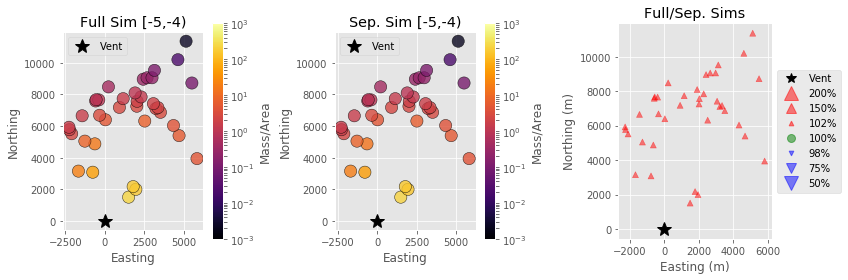

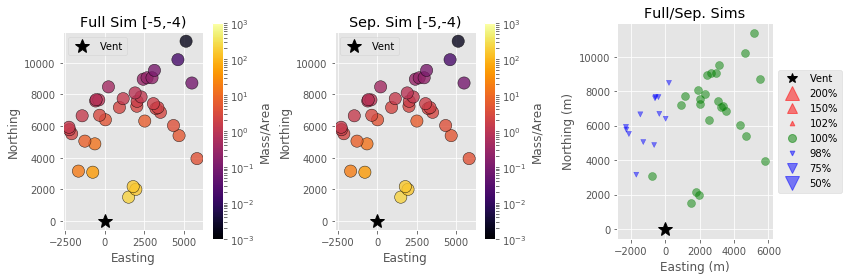

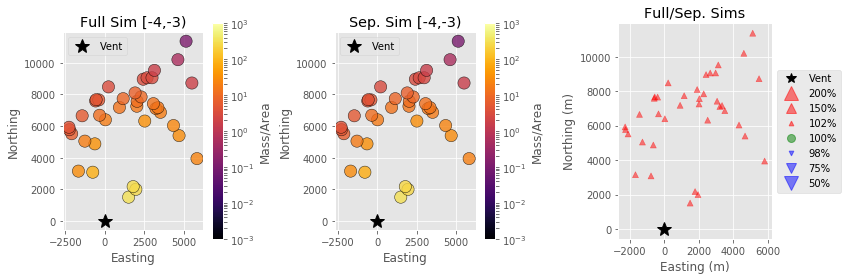

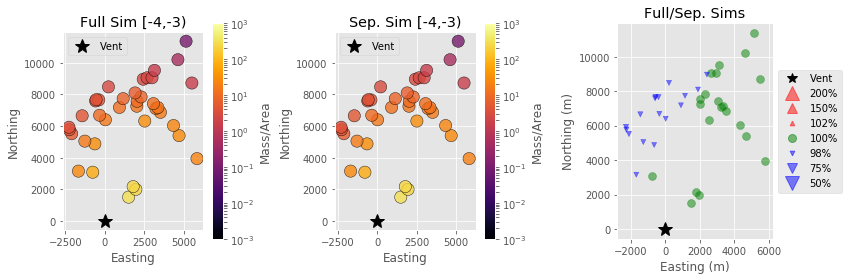

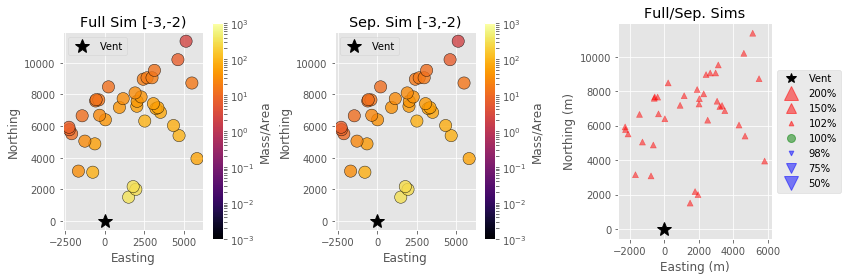

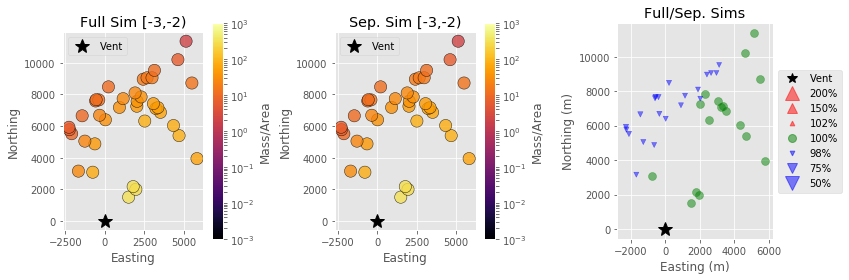

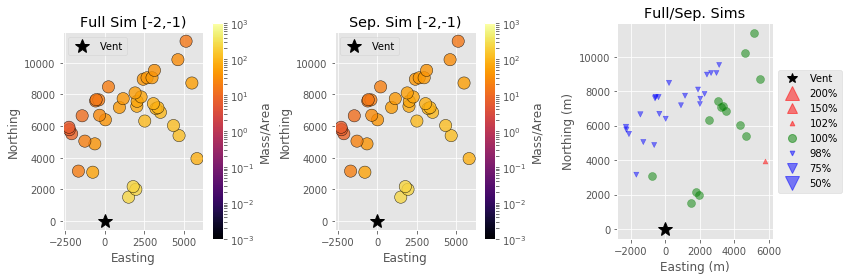

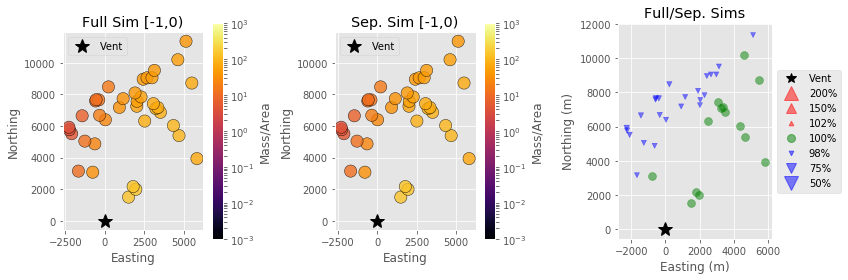

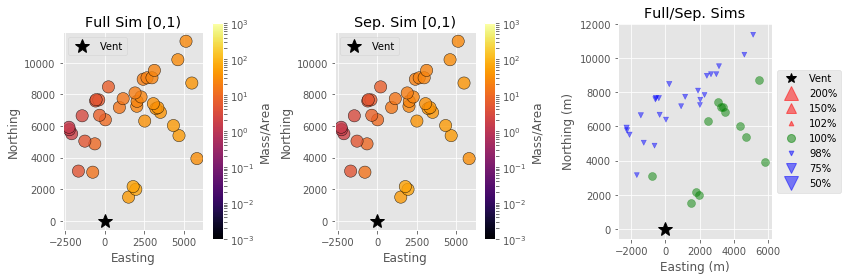

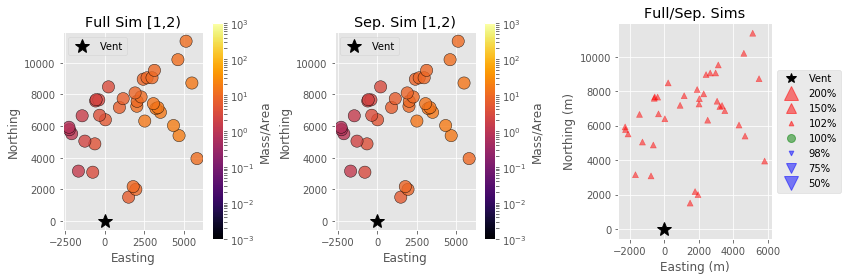

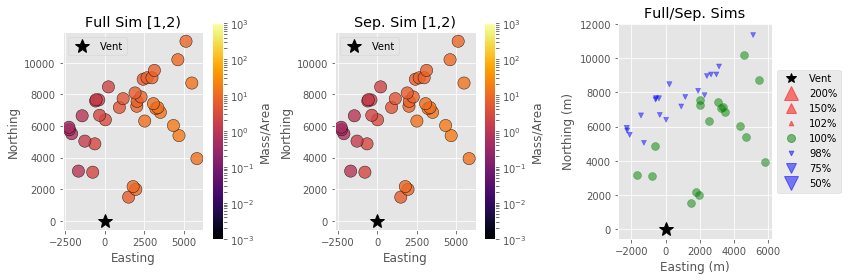

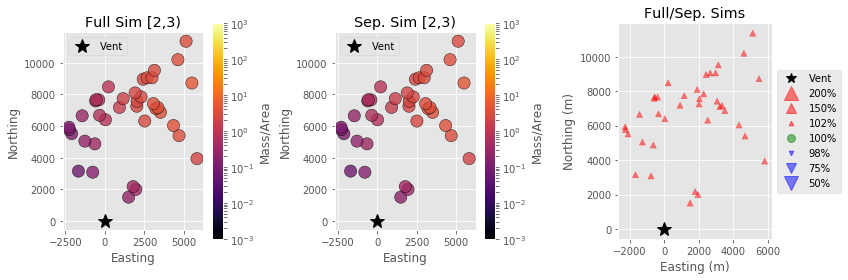

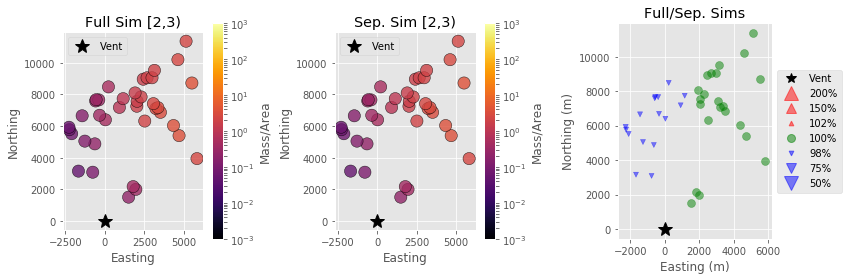

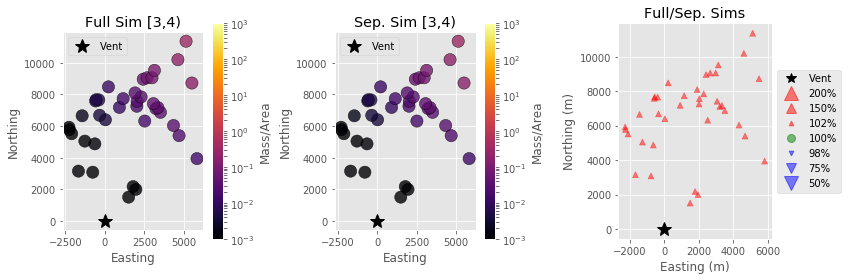

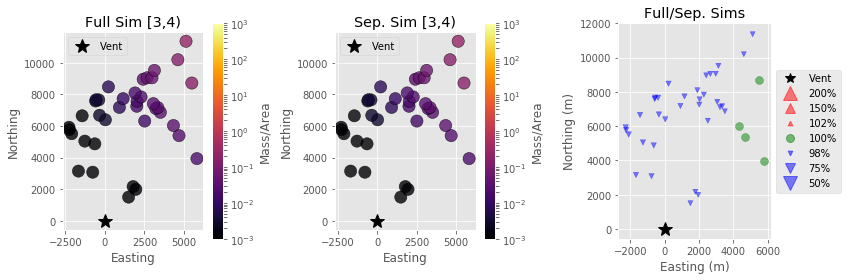

In [63]:
bounds=(0.001, 1000)
for i, phi_step in enumerate(phi_steps):
    
    t2_part = t2_const_df.copy()
    fw_part = forward_df.copy()
    
    t2_part["MassArea"] = t2_part["MassArea"].values*t2_const_df[phi_step["interval"]].values/100
    fw_part["MassArea"] = fw_part["MassArea"].values*forward_df[phi_step["interval"]].values/100
    
#     print(t2_const_df[phi_step["interval"]])
    
    t2_part["Change"] = t2_part["MassArea"].values/t2_gs_data[i]["MassArea"].values
    fw_part["Change"] = fw_part["MassArea"].values/forward_df_list[i]["MassArea"].values
    
#     display(fw_part["MassArea"])
#     display(forward_df_list[i]["MassArea"])
#     display(fw_part["Change"])
    
    fig, axs = plt.subplots(1,3, figsize=(
        12, 4), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    vis.plot_sample(t2_part, vent=(0,0), log=True, bounds=bounds,
                title="Full Sim %s"%phi_step["interval"], cbar_label="Mass/Area", ax = axs[0])
    vis.plot_sample(t2_gs_data[i], vent=(0,0), log=True, bounds=bounds,
                title="Sep. Sim %s"%phi_step["interval"], cbar_label="Mass/Area", ax = axs[1])
    vis.plot_residuals(t2_part, vent=(0,0), values="Change", plot_type="size",
                title="Full/Sep. Sims", ax=axs[2])
    
    fig, axs = plt.subplots(1,3, figsize=(
        12, 4), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    vis.plot_sample(fw_part, vent=(0,0), log=True, bounds=bounds,
                title="Full Sim %s"%phi_step["interval"], cbar_label="Mass/Area", ax = axs[0])
    vis.plot_sample(forward_df_list[i], vent=(0,0), log=True, bounds=bounds,
                title="Sep. Sim %s"%phi_step["interval"], cbar_label="Mass/Area", ax = axs[1])
    vis.plot_residuals(fw_part, vent=(0,0), values="Change", plot_type="size",
                title="Full/Sep. Sims", ax=axs[2])


#     vis.plot_sample(forward_df_list[i], vent=(0,0), log=True, bounds=bounds,
#                 title=phi_step["interval"], cbar_label="Mass/Area", ax=axs[1])
#     vis.plot_sample(fw_part, vent=(0,0), log=True, bounds=bounds,
#                 title=phi_step["interval"], cbar_label="Mass/Area", ax=axs[3])
    plt.show()